In [ ]:
#| default_exp models

In [ ]:
#| hide
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# <span style="color:DarkOrange"> Models </span>

> StatsForecast contains highly efficient Python implementations of univariate statistical and econometric forecasting models and parallelization and distributed computation utilities. StatsForecast library contains two main components:<br><br> The first component is a high-level `core.StatsForecast` wrapper class that operates with (potentially large) sets of time series data through pandas DataFrames. The second component comprises low-level model estimator classes like `models.AutoARIMA` and `models.AutoETS` that operate like sklearn classes with univariate time series NumPy inputs and outputs.<br><br>


In [ ]:
#| hide
import warnings
warnings.filterwarnings('ignore', category=FutureWarning)
from nbdev.showdoc import add_docs, show_doc
from fastcore.test import test_eq, test_close

In [ ]:
#| export
from typing import Dict, List, Optional, Sequence, Tuple

import numpy as np
from numba import njit
from scipy.optimize import minimize
from scipy.stats import norm

from statsforecast.arima import auto_arima_f, forecast_arima, fitted_arima, Arima as arima_model
from statsforecast.ets import ets_f, forecast_ets

In [ ]:
#| hide
from statsforecast.utils import AirPassengers as ap

In [ ]:
#| exporti
class _TS:
    
    def new(self):
        b = type(self).__new__(type(self))
        b.__dict__.update(self.__dict__)
        return b

In [ ]:
#| exporti
# Functions used for calculating prediction intervals 
def _quantiles(level): 
    z = norm.ppf(0.5+level/200)   
    return z

def _calculate_intervals(out, level, h, sigmah):
    z = _quantiles(np.asarray(level))
    zz = np.repeat(z, h)
    zz = zz.reshape(z.shape[0], h)
    lower = out['mean'] - zz * sigmah
    upper = out['mean'] + zz * sigmah
    pred_int = {**{f'lo-{lv}': lower[i] for i, lv in enumerate(level)}, 
                **{f'hi-{lv}': upper[i] for i, lv in enumerate(level)}}    
    return pred_int

def _calculate_sigma(residuals, n): 
    sigma = np.nansum(residuals ** 2) 
    sigma = sigma / n
    sigma = np.sqrt(sigma)
    return sigma

# <span style="color:DarkBlue"> 1. Automatic Forecasting </span>

##  AutoARIMA

In [ ]:
#| export
class AutoARIMA(_TS):
    """AutoARIMA model.
    [Source code](https://github.com/Nixtla/statsforecast/blob/main/statsforecast/arima.py).

    Automatically selects the best ARIMA (AutoRegressive Integrated Moving Average) 
    model using an information criterion. Default is Akaike Information Criterion (AICc). 
    
    **Parameters:**<br>
    `d`: int, order of first-differencing.<br>
    `D`: int, order of seasonal-differencing.<br>
    `max_p`: int, max autorregresives p.<br>
    `max_q`: int, max moving averages q.<br>
    `max_P`: int, max seasonal autorregresives P.<br>
    `max_Q`: int, max seasonal moving averages Q.<br>
    `max_order`: int, max p+q+P+Q value if not stepwise selection.<br>
    `max_d`: int, max non-seasonal differences.<br>
    `max_D`: int, max seasonal differences.<br>
    `start_p`: int, starting value of p in stepwise procedure.<br>
    `start_q`: int, starting value of q in stepwise procedure.<br>
    `start_P`: int, starting value of P in stepwise procedure.<br>
    `start_Q`: int, starting value of Q in stepwise procedure.<br>
    `stationary`: bool, if True, restricts search to stationary models.<br>
    `seasonal`: bool, if False, restricts search to non-seasonal models.<br>
    `ic`: str, information criterion to be used in model selection.<br>
    `stepwise`: bool, if True, will do stepwise selection (faster).<br>
    `nmodels`: int, number of models considered in stepwise search.<br>
    `trace`: bool, if True, the searched ARIMA models is reported.<br>
    `approximation`: bool, if True, conditional sums-of-squares estimation, final MLE.<br>
    `method`: str, fitting method between maximum likelihood or sums-of-squares.<br>
    `truncate`: int, observations truncated series used in model selection.<br>
    `test`: str (default 'kpss'), unit root test to use. See `ndiffs` for details.<br>
    `test_kwargs`: str optional (default None), unit root test additional arguments.<br>
    `seasonal_test`: str (default 'seas'), selection method for seasonal differences.<br>
    `seasonal_test_kwargs`: dict (optional), seasonal unit root test arguments.<br>
    `allowdrift`: bool (default True), If True, drift models terms considered.<br>
    `allowmean`: bool (default True), If True, non-zero mean models considered.<br>
    `blambda`: float optional (default None), Box-Cox transformation parameter.<br>
    `biasadj`: bool (default False), Use adjusted back-transformed mean Box-Cox.<br>
    `parallel`: bool, If True and stepwise=False, then parallel search.<br>
    `num_cores`: int, amount of parallel processes to be used if parallel=True.<br>
    `season_length`: int, number of observations per unit of time. Ex: 24 Hourly data.<br>
    
    **Note:**<br>
    This implementation is a mirror of Hyndman's [forecast::auto.arima](https://github.com/robjhyndman/forecast).
    
    **References:**<br>
    [Rob J. Hyndman, Yeasmin Khandakar (2008). "Automatic Time Series Forecasting: The forecast package for R"](https://www.jstatsoft.org/article/view/v027i03).
    """
    def __init__(
        self,
        d: Optional[int] = None,
        D: Optional[int] = None,
        max_p: int = 5,
        max_q: int = 5,
        max_P: int = 2,
        max_Q: int = 2,
        max_order: int = 5,
        max_d: int = 2,
        max_D: int = 1,
        start_p: int = 2,
        start_q: int = 2,
        start_P: int = 1,
        start_Q: int = 1,
        stationary: bool = False,
        seasonal: bool = True,
        ic: str = 'aicc',
        stepwise: bool = True,
        nmodels: int = 94,
        trace: bool = False,
        approximation: Optional[bool] = False,
        method: Optional[str] = None,
        truncate: Optional[bool] = None,
        test: str = 'kpss',
        test_kwargs: Optional[str] = None,
        seasonal_test: str = 'seas',
        seasonal_test_kwargs: Optional[Dict] = None,
        allowdrift: bool = False,
        allowmean: bool = False,
        blambda: Optional[float] = None,
        biasadj: bool = False,
        parallel: bool = False,
        num_cores: int = 2,
        season_length: int = 1
    ):
        self.d=d
        self.D=D
        self.max_p=max_p
        self.max_q=max_q
        self.max_P=max_P
        self.max_Q=max_Q
        self.max_order=max_order
        self.max_d=max_d
        self.max_D=max_D
        self.start_p=start_p
        self.start_q=start_q
        self.start_P=start_P
        self.start_Q=start_Q
        self.stationary=stationary
        self.seasonal=seasonal
        self.ic=ic
        self.stepwise=stepwise
        self.nmodels=nmodels
        self.trace=trace
        self.approximation=approximation
        self.method=method
        self.truncate=truncate
        self.test=test
        self.test_kwargs=test_kwargs
        self.seasonal_test=seasonal_test
        self.seasonal_test_kwargs=seasonal_test_kwargs
        self.allowdrift=allowdrift
        self.allowmean=allowmean
        self.blambda=blambda
        self.biasadj=biasadj
        self.parallel=parallel
        self.num_cores=num_cores
        self.season_length=season_length
        
    def __repr__(self):
        return 'AutoARIMA'
    
    def fit(
            self, 
            y: np.ndarray,
            X: Optional[np.ndarray] = None,
        ):
        """Fit the AutoARIMA model.

        Fit an AutoARIMA to a time series (numpy array) `y`
        and optionally exogenous variables (numpy array) `X`.

        **Parameters:**<br>
        `y`: numpy array of shape (t, ), clean time series.<br>
        `X`: array-like of shape (t, n_x) optional exogenous (default=None).<br>

        **Returns:**<br>
        `self`: AutoARIMA fitted model.
        """
        with np.errstate(invalid='ignore'):
            self.model_ = auto_arima_f(
                x=y,
                d=self.d,
                D=self.D,
                max_p=self.max_p,
                max_q=self.max_q,
                max_P=self.max_P,
                max_Q=self.max_Q,
                max_order=self.max_order,
                max_d=self.max_d,
                max_D=self.max_D,
                start_p=self.start_p,
                start_q=self.start_q,
                start_P=self.start_P,
                start_Q=self.start_Q,
                stationary=self.stationary,
                seasonal=self.seasonal,
                ic=self.ic,
                stepwise=self.stepwise,
                nmodels=self.nmodels,
                trace=self.trace,
                approximation=self.approximation,
                method=self.method,
                truncate=self.truncate,
                xreg=X,
                test=self.test,
                test_kwargs=self.test_kwargs,
                seasonal_test=self.seasonal_test,
                seasonal_test_kwargs=self.seasonal_test_kwargs,
                allowdrift=self.allowdrift,
                allowmean=self.allowmean,
                blambda=self.blambda,
                biasadj=self.biasadj,
                parallel=self.parallel,
                num_cores=self.num_cores,
                period=self.season_length
            )
        return self
    
    def predict(
            self, 
            h: int,
            X: np.ndarray = None,
            level: Optional[Tuple[int]] = None,
        ):
        """Predict with fitted AutoArima.

        **Parameters:**<br>
        `h`: int, forecast horizon.<br>
        `X`: array-like of shape (h, n_x) optional exogenous (default=None).<br>

        **Returns:**<br>
        `forecasts`: dictionary, with entries 'mean' for point predictions and
            'level_*' for probabilistic predictions.<br>
        """
        fcst = forecast_arima(self.model_, h=h, xreg=X, level=level)
        mean = fcst['mean']
        if level is None:
            return {'mean': mean}
        return {
            'mean': mean,
            **{f'lo-{l}': fcst['lower'][f'{l}%'] for l in reversed(level)},
            **{f'hi-{l}': fcst['upper'][f'{l}%'] for l in level},
        }
    
    def predict_in_sample(self, level: Optional[Tuple[int]] = None):
        """Access fitted AutoArima insample predictions.

        **Parameters:**<br>
        `X`: array-like of shape (t, n_x) optional exogenous (default=None).<br>
        `level`: float list 0-100, confidence levels for prediction intervals.<br>

        **Returns:**<br>
        `forecasts`: dictionary, with entries 'mean' for point predictions and
            'level_*' for probabilistic predictions.<br>
        """
        if level is not None:
            return NotImplementedError
        mean = fitted_arima(self.model_)
        return {'mean': mean}
    
    def forecast(
            self,
            y: np.ndarray,
            h: int,
            X: np.ndarray = None,
            X_future: np.ndarray = None,
            level: Optional[List[int]] = None,
            fitted: bool = False,
        ):
        """Memory Efficient AutoARIMA predictions.

        This method avoids memory burden due from object storage.
        It is analogous to `fit_predict` without storing information.
        It assumes you know the forecast horizon in advance.

        **Parameters:**<br>
        `y`: numpy array of shape (n,), clean time series.<br>
        `h`: int, forecast horizon.<br>
        `X`: array-like of shape (t, n_x) optional insample exogenous (default=None).<br>
        `X_future`: array-like of shape (h, n_x) optional exogenous (default=None).<br>
        `level`: float list 0-100, confidence levels for prediction intervals.<br>
        `fitted`: bool, wether or not returns insample predictions.<br>

        **Returns:**<br>
        `forecasts`: dictionary, with entries 'mean' for point predictions and
            'level_*' for probabilistic predictions.<br>
        """
        with np.errstate(invalid='ignore'):
            mod = auto_arima_f(
                x=y,
                d=self.d,
                D=self.D,
                max_p=self.max_p,
                max_q=self.max_q,
                max_P=self.max_P,
                max_Q=self.max_Q,
                max_order=self.max_order,
                max_d=self.max_d,
                max_D=self.max_D,
                start_p=self.start_p,
                start_q=self.start_q,
                start_P=self.start_P,
                start_Q=self.start_Q,
                stationary=self.stationary,
                seasonal=self.seasonal,
                ic=self.ic,
                stepwise=self.stepwise,
                nmodels=self.nmodels,
                trace=self.trace,
                approximation=self.approximation,
                method=self.method,
                truncate=self.truncate,
                xreg=X,
                test=self.test,
                test_kwargs=self.test_kwargs,
                seasonal_test=self.seasonal_test,
                seasonal_test_kwargs=self.seasonal_test_kwargs,
                allowdrift=self.allowdrift,
                allowmean=self.allowmean,
                blambda=self.blambda,
                biasadj=self.biasadj,
                parallel=self.parallel,
                num_cores=self.num_cores,
                period=self.season_length
            )
        fcst = forecast_arima(mod, h, xreg=X_future, level=level)
        res = {'mean': fcst['mean']}
        if fitted:
            res['fitted'] = fitted_arima(mod)
        if level is not None:
            level = sorted(level)
            res = {
                **res,
                **{f'lo-{l}': fcst['lower'][f'{l}%'] for l in reversed(level)},
                **{f'hi-{l}': fcst['upper'][f'{l}%'] for l in level},
            }
            if fitted:
                # add prediction intervals for fitted values
                arr_level = np.asarray(level) 
                se = np.sqrt(mod['sigma2'])
                quantiles = norm.ppf(0.5 * (1 + arr_level / 100))

                lo = res['fitted'].reshape(-1, 1) - quantiles * se.reshape(-1, 1)
                hi = res['fitted'].reshape(-1, 1) + quantiles * se.reshape(-1, 1)
                lo = lo[:, ::-1]
                lo = {f'fitted-lo-{l}': lo[:, i] for i, l in enumerate(reversed(level))}
                hi = {f'fitted-hi-{l}': hi[:, i] for i, l in enumerate(level)}
                res = {**res, **lo, **hi}
        return res

In [ ]:
#| hide
from statsforecast.utils import AirPassengers as ap

def test_class(cls_, x, h, skip_insample=False):
    cls_ = cls_.fit(x)
    fcst_cls = cls_.predict(h=h)
    test_eq(len(fcst_cls['mean']), h)
    # test fit + predict equals forecast
    test_eq(
        cls_.forecast(y=x, h=h)['mean'],
        fcst_cls['mean']
    )
    if not skip_insample:
        test_eq(len(cls_.predict_in_sample()['mean']), len(x))
        assert isinstance(cls_.predict_in_sample()['mean'], np.ndarray)
        np.testing.assert_array_equal(
            cls_.forecast(y=x, h=h, fitted=True)['fitted'],
            cls_.predict_in_sample()['mean'], 
        )

In [ ]:
#| hide
arima = AutoARIMA(season_length=12) 
test_class(arima, x=ap, h=12)

In [ ]:
AutoARIMA(season_length=12).forecast(ap, 12, level=(80,90), fitted=True)

{'mean': array([444.30005077, 418.2100203 , 446.23703401, 488.22892853,
        499.23136059, 562.23063085, 649.23084981, 633.23078411,
        535.23080382, 488.23079791, 417.23079968, 459.23079915]),
 'fitted': array([111.93533678, 117.96643416, 131.96619385, 128.97744815,
        120.98924613, 134.97817413, 147.96920714, 147.97307246,
        135.98742515, 119.00485619, 104.01874673, 118.0777757 ,
        115.42699043, 121.23080941, 138.49974616, 137.69994923,
        127.90015231, 139.60010154, 158.99949231, 167.59959385,
        158.        , 141.        , 120.40040615, 129.20020308,
        133.39939078, 153.59959385, 166.80030461, 168.09934001,
        155.70045692, 190.29903539, 204.40091384, 199.        ,
        187.        , 159.90015231, 142.09984769, 171.09984769,
        172.80030461, 176.        , 206.79979693, 182.50076153,
        189.09984769, 191.10035538, 230.29852771, 232.70045692,
        223.39939078, 192.40091384, 173.79979693, 192.90015231,
        198.39989846

In [ ]:
show_doc(AutoARIMA, title_level=3)

---

### AutoARIMA

>      AutoARIMA (d:Optional[int]=None, D:Optional[int]=None, max_p:int=5,
>                 max_q:int=5, max_P:int=2, max_Q:int=2, max_order:int=5,
>                 max_d:int=2, max_D:int=1, start_p:int=2, start_q:int=2,
>                 start_P:int=1, start_Q:int=1, stationary:bool=False,
>                 seasonal:bool=True, ic:str='aicc', stepwise:bool=True,
>                 nmodels:int=94, trace:bool=False,
>                 approximation:Optional[bool]=False, method:Optional[str]=None,
>                 truncate:Optional[bool]=None, test:str='kpss',
>                 test_kwargs:Optional[str]=None, seasonal_test:str='seas',
>                 seasonal_test_kwargs:Optional[Dict]=None,
>                 allowdrift:bool=False, allowmean:bool=False,
>                 blambda:Optional[float]=None, biasadj:bool=False,
>                 parallel:bool=False, num_cores:int=2, season_length:int=1)

AutoARIMA model.
[Source code](https://github.com/Nixtla/statsforecast/blob/main/statsforecast/arima.py).

Automatically selects the best ARIMA (AutoRegressive Integrated Moving Average) 
model using an information criterion. Default is Akaike Information Criterion (AICc). 

**Parameters:**<br>
`d`: int, order of first-differencing.<br>
`D`: int, order of seasonal-differencing.<br>
`max_p`: int, max autorregresives p.<br>
`max_q`: int, max moving averages q.<br>
`max_P`: int, max seasonal autorregresives P.<br>
`max_Q`: int, max seasonal moving averages Q.<br>
`max_order`: int, max p+q+P+Q value if not stepwise selection.<br>
`max_d`: int, max non-seasonal differences.<br>
`max_D`: int, max seasonal differences.<br>
`start_p`: int, starting value of p in stepwise procedure.<br>
`start_q`: int, starting value of q in stepwise procedure.<br>
`start_P`: int, starting value of P in stepwise procedure.<br>
`start_Q`: int, starting value of Q in stepwise procedure.<br>
`stationary`: bool, if True, restricts search to stationary models.<br>
`seasonal`: bool, if False, restricts search to non-seasonal models.<br>
`ic`: str, information criterion to be used in model selection.<br>
`stepwise`: bool, if True, will do stepwise selection (faster).<br>
`nmodels`: int, number of models considered in stepwise search.<br>
`trace`: bool, if True, the searched ARIMA models is reported.<br>
`approximation`: bool, if True, conditional sums-of-squares estimation, final MLE.<br>
`method`: str, fitting method between maximum likelihood or sums-of-squares.<br>
`truncate`: int, observations truncated series used in model selection.<br>
`test`: str (default 'kpss'), unit root test to use. See `ndiffs` for details.<br>
`test_kwargs`: str optional (default None), unit root test additional arguments.<br>
`seasonal_test`: str (default 'seas'), selection method for seasonal differences.<br>
`seasonal_test_kwargs`: dict (optional), seasonal unit root test arguments.<br>
`allowdrift`: bool (default True), If True, drift models terms considered.<br>
`allowmean`: bool (default True), If True, non-zero mean models considered.<br>
`blambda`: float optional (default None), Box-Cox transformation parameter.<br>
`biasadj`: bool (default False), Use adjusted back-transformed mean Box-Cox.<br>
`parallel`: bool, If True and stepwise=False, then parallel search.<br>
`num_cores`: int, amount of parallel processes to be used if parallel=True.<br>
`season_length`: int, number of observations per unit of time. Ex: 24 Hourly data.<br>

**Note:**<br>
This implementation is a mirror of Hyndman's [forecast::auto.arima](https://github.com/robjhyndman/forecast).

**References:**<br>
[Rob J. Hyndman, Yeasmin Khandakar (2008). "Automatic Time Series Forecasting: The forecast package for R"](https://www.jstatsoft.org/article/view/v027i03).

In [ ]:
show_doc(AutoARIMA.fit, title_level=3)

---

#### AutoARIMA.fit

>      AutoARIMA.fit (y:numpy.ndarray, X:Optional[numpy.ndarray]=None)

Fit the AutoARIMA model.

Fit an AutoARIMA to a time series (numpy array) `y`
and optionally exogenous variables (numpy array) `X`.

**Parameters:**<br>
`y`: numpy array of shape (t, ), clean time series.<br>
`X`: array-like of shape (t, n_x) optional exogenous (default=None).<br>

**Returns:**<br>
`self`: AutoARIMA fitted model.

In [ ]:
show_doc(AutoARIMA.predict, title_level=3)

---

#### AutoARIMA.predict

>      AutoARIMA.predict (h:int, X:numpy.ndarray=None,
>                         level:Optional[Tuple[int]]=None)

Predict with fitted AutoArima.

**Parameters:**<br>
`h`: int, forecast horizon.<br>
`X`: array-like of shape (h, n_x) optional exogenous (default=None).<br>

**Returns:**<br>
`forecasts`: dictionary, with entries 'mean' for point predictions and
    'level_*' for probabilistic predictions.<br>

In [ ]:
show_doc(AutoARIMA.predict_in_sample, title_level=3)

---

#### AutoARIMA.predict_in_sample

>      AutoARIMA.predict_in_sample (level:Optional[Tuple[int]]=None)

Access fitted AutoArima insample predictions.

**Parameters:**<br>
`X`: array-like of shape (t, n_x) optional exogenous (default=None).<br>
`level`: float list 0-100, confidence levels for prediction intervals.<br>

**Returns:**<br>
`forecasts`: dictionary, with entries 'mean' for point predictions and
    'level_*' for probabilistic predictions.<br>

In [ ]:
show_doc(AutoARIMA.forecast, title_level=3)

---

#### AutoARIMA.forecast

>      AutoARIMA.forecast (y:numpy.ndarray, h:int, X:numpy.ndarray=None,
>                          X_future:numpy.ndarray=None,
>                          level:Optional[List[int]]=None, fitted:bool=False)

Memory Efficient AutoARIMA predictions.

This method avoids memory burden due from object storage.
It is analogous to `fit_predict` without storing information.
It assumes you know the forecast horizon in advance.

**Parameters:**<br>
`y`: numpy array of shape (n,), clean time series.<br>
`h`: int, forecast horizon.<br>
`X`: array-like of shape (t, n_x) optional insample exogenous (default=None).<br>
`X_future`: array-like of shape (h, n_x) optional exogenous (default=None).<br>
`level`: float list 0-100, confidence levels for prediction intervals.<br>
`fitted`: bool, wether or not returns insample predictions.<br>

**Returns:**<br>
`forecasts`: dictionary, with entries 'mean' for point predictions and
    'level_*' for probabilistic predictions.<br>

In [ ]:
# AutoARIMA's usage example

from statsforecast.models import AutoARIMA
from statsforecast.utils import AirPassengers as ap


arima = AutoARIMA(season_length=4)
arima = arima.fit(y=ap)
y_hat_dict = arima.predict(h=4, level=[80])
y_hat_dict

{'mean': array([497.95290508, 486.78068838, 500.08214791, 494.10983724]),
 'lo-80': 0    467.167463
 1    442.112228
 2    450.786735
 3    440.963292
 Name: 80%, dtype: float64,
 'hi-80': 0    528.738347
 1    531.449149
 2    549.377561
 3    547.256382
 Name: 80%, dtype: float64}

## AutoETS

In [ ]:
#| export
class ETS(_TS):
    """Exponential Smoothing model.
    [Source code](https://github.com/Nixtla/statsforecast/blob/main/statsforecast/ets.py).

    Automatically selects the best ETS (Error, Trend, Seasonality) 
    model using an information criterion. Default is Akaike Information Criterion (AICc), while particular models are estimated using maximum likelihood.
    The state-space equations can be determined based on their $M$ multiplicative, $A$ additive, 
    $Z$ optimized or $N$ ommited components. The `model` string parameter defines the ETS equations: 
    E in [$M, A, Z$], T in [$N, A, M, Z$], and S in [$N, A, M, Z$].
    
    For example when model='ANN' (additive error, no trend, and no seasonality), ETS will 
    explore only a simple exponential smoothing.
    
    If the component is selected as 'Z', it operates as a placeholder to ask the AutoETS model
    to figure out the best parameter.
    
    **Parameters:**<br>
    `model`: str, controlling state-space-equations.<br>
    `season_length`: int, number of observations per unit of time. Ex: 24 Hourly data.<br>
    
    **Note:**<br>
    This implementation is a mirror of Hyndman's [forecast::ets](https://github.com/robjhyndman/forecast).
    
    **References:**<br>
    [Rob J. Hyndman, Yeasmin Khandakar (2008). "Automatic Time Series Forecasting: The forecast package for R"](https://www.jstatsoft.org/article/view/v027i03).
    
    [Hyndman, Rob, et al (2008). "Forecasting with exponential smoothing: the state space approach"](https://robjhyndman.com/expsmooth/).
    """
    def __init__(
            self, 
            season_length: int = 1,
            model: str = 'ZZZ'
        ):
        self.season_length = season_length
        self.model = model
    
    def __repr__(self):
        return 'ETS'
    
    def fit(
            self,
            y: np.ndarray,
            X: np.ndarray = None
        ):
        """Fit the Exponential Smoothing model.

        Fit an Exponential Smoothing model to a time series (numpy array) `y`
        and optionally exogenous variables (numpy array) `X`.

        **Parameters:**<br>
        `y`: numpy array of shape (t, ), clean time series.<br>
        `X`: array-like of shape (t, n_x) optional exogenous (default=None).<br>

        **Returns:**<br>
        `self`: Exponential Smoothing fitted model.
        """
        self.model_ = ets_f(y, m=self.season_length, model=self.model)
        return self
    
    def predict(
            self,
            h: int,
            X: np.ndarray = None
        ):
        """Predict with fitted Exponential Smoothing.

        **Parameters:**<br>
        `h`: int, forecast horizon.<br>
        `X`: array-like of shape (h, n_x) optional exogenous (default=None).<br>

        **Returns:**<br>
        `forecasts`: dictionary, with entries 'mean' for point predictions and
            'level_*' for probabilistic predictions.<br>
        """
        mean = forecast_ets(self.model_, h=h)['mean']
        res = {'mean': mean}
        return res
    
    def predict_in_sample(self):
        """Access fitted Exponential Smoothing insample predictions.

        **Parameters:**<br>
        `X`: array-like of shape (t, n_x) optional exogenous (default=None).<br>
        `level`: float list 0-100, confidence levels for prediction intervals.<br>

        **Returns:**<br>
        `forecasts`: dictionary, with entries 'mean' for point predictions and
            'level_*' for probabilistic predictions.<br>
        """
        res = {'mean': self.model_['fitted']}
        return res
    
    def forecast(
            self,
            y: np.ndarray,
            h: int,
            X: np.ndarray = None,
            X_future: np.ndarray = None,
            fitted: bool = False,
        ):
        """Memory Efficient Exponential Smoothing predictions.

        This method avoids memory burden due from object storage.
        It is analogous to `fit_predict` without storing information.
        It assumes you know the forecast horizon in advance.

        **Parameters:**<br>
        `y`: numpy array of shape (n,), clean time series.<br>
        `h`: int, forecast horizon.<br>
        `X`: array-like of shape (t, n_x) optional insample exogenous (default=None).<br>
        `X_future`: array-like of shape (h, n_x) optional exogenous (default=None).<br>
        `level`: float list 0-100, confidence levels for prediction intervals.<br>
        `fitted`: bool, wether or not returns insample predictions.<br>

        **Returns:**<br>
        `forecasts`: dictionary, with entries 'mean' for point predictions and
            'level_*' for probabilistic predictions.<br>
        """
        mod = ets_f(y, m=self.season_length, model=self.model)
        fcst = forecast_ets(mod, h)
        keys = ['mean']
        if fitted:
            keys.append('fitted')
        return {key: fcst[key] for key in keys}

In [ ]:
#| hide
ets = ETS(season_length=12)
test_class(ets, x=ap, h=12)

In [ ]:
show_doc(ETS, title_level=3)

---

### ETS

>      ETS (season_length:int=1, model:str='ZZZ')

Exponential Smoothing model.
[Source code](https://github.com/Nixtla/statsforecast/blob/main/statsforecast/ets.py).

Automatically selects the best ETS (Error, Trend, Seasonality) 
model using an information criterion. Default is Akaike Information Criterion (AICc), while particular models are estimated using maximum likelihood.
The state-space equations can be determined based on their $M$ multiplicative, $A$ additive, 
$Z$ optimized or $N$ ommited components. The `model` string parameter defines the ETS equations: 
E in [$M, A, Z$], T in [$N, A, M, Z$], and S in [$N, A, M, Z$].

For example when model='ANN' (additive error, no trend, and no seasonality), ETS will 
explore only a simple exponential smoothing.

If the component is selected as 'Z', it operates as a placeholder to ask the AutoETS model
to figure out the best parameter.

**Parameters:**<br>
`model`: str, controlling state-space-equations.<br>
`season_length`: int, number of observations per unit of time. Ex: 24 Hourly data.<br>

**Note:**<br>
This implementation is a mirror of Hyndman's [forecast::ets](https://github.com/robjhyndman/forecast).

**References:**<br>
[Rob J. Hyndman, Yeasmin Khandakar (2008). "Automatic Time Series Forecasting: The forecast package for R"](https://www.jstatsoft.org/article/view/v027i03).

[Hyndman, Rob, et al (2008). "Forecasting with exponential smoothing: the state space approach"](https://robjhyndman.com/expsmooth/).

In [ ]:
show_doc(ETS.fit, title_level=3)

---

#### ETS.fit

>      ETS.fit (y:numpy.ndarray, X:numpy.ndarray=None)

Fit the Exponential Smoothing model.

Fit an Exponential Smoothing model to a time series (numpy array) `y`
and optionally exogenous variables (numpy array) `X`.

**Parameters:**<br>
`y`: numpy array of shape (t, ), clean time series.<br>
`X`: array-like of shape (t, n_x) optional exogenous (default=None).<br>

**Returns:**<br>
`self`: Exponential Smoothing fitted model.

In [ ]:
show_doc(ETS.predict, title_level=3)

---

#### ETS.predict

>      ETS.predict (h:int, X:numpy.ndarray=None)

Predict with fitted Exponential Smoothing.

**Parameters:**<br>
`h`: int, forecast horizon.<br>
`X`: array-like of shape (h, n_x) optional exogenous (default=None).<br>

**Returns:**<br>
`forecasts`: dictionary, with entries 'mean' for point predictions and
    'level_*' for probabilistic predictions.<br>

In [ ]:
show_doc(ETS.predict_in_sample, title_level=3)

---

#### ETS.predict_in_sample

>      ETS.predict_in_sample ()

Access fitted Exponential Smoothing insample predictions.

**Parameters:**<br>
`X`: array-like of shape (t, n_x) optional exogenous (default=None).<br>
`level`: float list 0-100, confidence levels for prediction intervals.<br>

**Returns:**<br>
`forecasts`: dictionary, with entries 'mean' for point predictions and
    'level_*' for probabilistic predictions.<br>

In [ ]:
show_doc(ETS.forecast, title_level=3)

---

#### ETS.forecast

>      ETS.forecast (y:numpy.ndarray, h:int, X:numpy.ndarray=None,
>                    X_future:numpy.ndarray=None, fitted:bool=False)

Memory Efficient Exponential Smoothing predictions.

This method avoids memory burden due from object storage.
It is analogous to `fit_predict` without storing information.
It assumes you know the forecast horizon in advance.

**Parameters:**<br>
`y`: numpy array of shape (n,), clean time series.<br>
`h`: int, forecast horizon.<br>
`X`: array-like of shape (t, n_x) optional insample exogenous (default=None).<br>
`X_future`: array-like of shape (h, n_x) optional exogenous (default=None).<br>
`level`: float list 0-100, confidence levels for prediction intervals.<br>
`fitted`: bool, wether or not returns insample predictions.<br>

**Returns:**<br>
`forecasts`: dictionary, with entries 'mean' for point predictions and
    'level_*' for probabilistic predictions.<br>

In [ ]:
# ETS' usage example

from statsforecast.models import ETS
from statsforecast.utils import AirPassengers as ap

# Multiplicative trend, optimal error and seasonality
ets = ETS(model='ZMZ',  
          season_length=4)
ets = ets.fit(y=ap)
y_hat_dict = ets.predict(h=4)
y_hat_dict

{'mean': array([416.72150528, 419.72970329, 442.61205868, 457.25022941])}

# <span style="color:DarkBlue"> 2. ExponentialSmoothing </span>

## SimpleSmooth

In [ ]:
#| export
@njit
def _ses_fcst_mse(x: np.ndarray, alpha: float) -> Tuple[float, float, np.ndarray]:
    """Perform simple exponential smoothing on a series.

    This function returns the one step ahead prediction
    as well as the mean squared error of the fit.
    """
    smoothed = x[0]
    n = x.size
    mse = 0.
    fitted = np.full(n, np.nan, np.float32)

    for i in range(1, n):
        smoothed = (alpha * x[i - 1] + (1 - alpha) * smoothed).item()
        error = x[i] - smoothed
        mse += error * error
        fitted[i] = smoothed

    mse /= n
    forecast = alpha * x[-1] + (1 - alpha) * smoothed
    return forecast, mse, fitted


def _ses_mse(alpha: float, x: np.ndarray) -> float:
    """Compute the mean squared error of a simple exponential smoothing fit."""
    _, mse, _ = _ses_fcst_mse(x, alpha)
    return mse


@njit
def _ses_forecast(x: np.ndarray, alpha: float) -> Tuple[float, np.ndarray]:
    """One step ahead forecast with simple exponential smoothing."""
    forecast, _, fitted = _ses_fcst_mse(x, alpha)
    return forecast, fitted


@njit
def _demand(x: np.ndarray) -> np.ndarray:
    """Extract the positive elements of a vector."""
    return x[x > 0]


@njit
def _intervals(x: np.ndarray) -> np.ndarray:
    """Compute the intervals between non zero elements of a vector."""
    y = []

    ctr = 1
    for val in x:
        if val == 0:
            ctr += 1
        else:
            y.append(ctr)
            ctr = 1

    return np.array(y)


@njit
def _probability(x: np.ndarray) -> np.ndarray:
    """Compute the element probabilities of being non zero."""
    return (x != 0).astype(np.int32)


def _optimized_ses_forecast(
        x: np.ndarray,
        bounds: Sequence[Tuple[float, float]] = [(0.1, 0.3)]
    ) -> Tuple[float, np.ndarray]:
    """Searches for the optimal alpha and computes SES one step forecast."""
    alpha = minimize(
        fun=_ses_mse,
        x0=(0,),
        args=(x,),
        bounds=bounds,
        method='L-BFGS-B'
    ).x[0]
    forecast, fitted = _ses_forecast(x, alpha)
    return forecast, fitted


@njit
def _chunk_sums(array: np.ndarray, chunk_size: int) -> np.ndarray:
    """Splits an array into chunks and returns the sum of each chunk."""
    n = array.size
    n_chunks = n // chunk_size
    sums = np.empty(n_chunks)
    for i, start in enumerate(range(0, n, chunk_size)):
        sums[i] = array[start : start + chunk_size].sum()
    return sums

@njit
def _repeat_val(val: float, h: int):
    return np.full(h, val, np.float32)

@njit
def _repeat_val_seas(season_vals: np.ndarray, h: int, season_length: int):
    out = np.empty(h, np.float32)
    for i in range(h):
        out[i] = season_vals[i % season_length]
    return out

In [ ]:
#| exporti
@njit
def _ses(
        y: np.ndarray, # time series
        h: int, # forecasting horizon
        fitted: bool, # fitted values
        alpha: float, # smoothing parameter
    ): 
    fcst, _, fitted_vals = _ses_fcst_mse(y, alpha)
    mean = _repeat_val(val=fcst, h=h)
    fcst = {'mean': mean}
    if fitted:
        fcst['fitted'] = fitted_vals
    return fcst

In [ ]:
#| export
class SimpleExponentialSmoothing(_TS):
    """SimpleExponentialSmoothing model.
    [Source code](https://github.com/Nixtla/statsforecast/blob/main/statsforecast/smoothing.py).

    Uses a weighted average of all past observations where the weights decrease exponentially into the past. 
    Suitable for data with no clear trend or seasonality. 
    Assuming there are $t$ observations, the one-step forecast is given by: $\hat{y}_{t+1} = \\alpha y_t + (1-\\alpha) \hat{y}_{t-1}$

    The rate $0 \leq \\alpha \leq 1$ at which the weights decrease is called the smoothing parameter. When $\\alpha = 1$, SES is equal to the naive method.

    **Parameters:**<br>
    `alpha`: float, smoothing parameter.<br>

    **References:**<br>
    [Charles C Holt (1957). “Forecasting seasonals and trends by exponentially weighted moving averages”](https://doi.org/10.1016/j.ijforecast).

    """
    def __init__(
            self, 
            alpha: float
        ):
        self.alpha = alpha
        
    def __repr__(self):
        return 'SES'
    
    def fit(
            self,
            y: np.ndarray,
            X: np.ndarray = None
        ):
        """Fit the SimpleExponentialSmoothing model.

        Fit an SimpleExponentialSmoothing to a time series (numpy array) `y`
        and optionally exogenous variables (numpy array) `X`.

        **Parameters:**<br>
        `y`: numpy array of shape (t, ), clean time series.<br>
        `X`: array-like of shape (t, n_x) optional exogenous (default=None).<br>

        **Returns:**<br>
        `self`: SimpleExponentialSmoothing fitted model.
        """
        mod = _ses(y=y, alpha=self.alpha, h=1, fitted=True)
        self.model_ = dict(mod)
        return self
        
    def predict(
            self,
            h: int,
            X: np.ndarray = None
        ):
        """Predict with fitted SimpleExponentialSmoothing.

        **Parameters:**<br>
        `h`: int, forecast horizon.<br>

        **Returns:**<br>
        `forecasts`: dictionary, with entries 'mean' for point predictions and
            'level_*' for probabilistic predictions.<br>
        """
        mean = _repeat_val(val=self.model_['mean'][0], h=h)
        res = {'mean': mean}
        return res
    
    def predict_in_sample(self):
        """Access fitted SimpleExponentialSmoothing insample predictions.

        **Parameters:**<br>
        `level`: float list 0-100, confidence levels for prediction intervals.<br>

        **Returns:**<br>
        `forecasts`: dictionary, with entries 'mean' for point predictions and
            'level_*' for probabilistic predictions.<br>
        """
        res = {'mean': self.model_['fitted']}
        return res
    
    def forecast(
            self, 
            y: np.ndarray,
            h: int,
            X: np.ndarray = None,
            X_future: np.ndarray = None,
            fitted: bool = False,
        ):
        """Memory Efficient SimpleExponentialSmoothing predictions.

        This method avoids memory burden due from object storage.
        It is analogous to `fit_predict` without storing information.
        It assumes you know the forecast horizon in advance.

        **Parameters:**<br>
        `y`: numpy array of shape (n,), clean time series.<br>
        `h`: int, forecast horizon.<br>
        `level`: float list 0-100, confidence levels for prediction intervals.<br>
        `fitted`: bool, wether or not returns insample predictions.<br>

        **Returns:**<br>
        `forecasts`: dictionary, with entries 'mean' for point predictions and
            'level_*' for probabilistic predictions.<br>
        """
        out = _ses(y=y, h=h, fitted=fitted, alpha=self.alpha)
        return out

In [ ]:
#| hide
ses = SimpleExponentialSmoothing(alpha=0.1)
test_class(ses, x=ap, h=12)
#more tests
ses = ses.fit(ap)
fcst_ses = ses.predict(12)
test_close(fcst_ses['mean'], np.repeat(460.3028, 12), eps=1e-4)
#to recover these residuals from R
#you have to pass initial="simple"
#in the `ses` function
np.testing.assert_allclose(
    ses.predict_in_sample()['mean'][[0, 1, -1]], 
    np.array([np.nan, 118 - 6., 432 + 31.447525])
)

In [ ]:
show_doc(SimpleExponentialSmoothing, title_level=3)

---

### SimpleExponentialSmoothing

>      SimpleExponentialSmoothing (alpha:float)

SimpleExponentialSmoothing model.
[Source code](https://github.com/Nixtla/statsforecast/blob/main/statsforecast/smoothing.py).

Uses a weighted average of all past observations where the weights decrease exponentially into the past. 
Suitable for data with no clear trend or seasonality. 
Assuming there are $t$ observations, the one-step forecast is given by: $\hat{y}_{t+1} = \alpha y_t + (1-\alpha) \hat{y}_{t-1}$

The rate $0 \leq \alpha \leq 1$ at which the weights decrease is called the smoothing parameter. When $\alpha = 1$, SES is equal to the naive method.

**Parameters:**<br>
`alpha`: float, smoothing parameter.<br>

**References:**<br>
[Charles C Holt (1957). “Forecasting seasonals and trends by exponentially weighted moving averages”](https://doi.org/10.1016/j.ijforecast).

In [ ]:
show_doc(SimpleExponentialSmoothing.forecast, title_level=3)

---

#### SimpleExponentialSmoothing.forecast

>      SimpleExponentialSmoothing.forecast (y:numpy.ndarray, h:int,
>                                           X:numpy.ndarray=None,
>                                           X_future:numpy.ndarray=None,
>                                           fitted:bool=False)

Memory Efficient SimpleExponentialSmoothing predictions.

This method avoids memory burden due from object storage.
It is analogous to `fit_predict` without storing information.
It assumes you know the forecast horizon in advance.

**Parameters:**<br>
`y`: numpy array of shape (n,), clean time series.<br>
`h`: int, forecast horizon.<br>
`level`: float list 0-100, confidence levels for prediction intervals.<br>
`fitted`: bool, wether or not returns insample predictions.<br>

**Returns:**<br>
`forecasts`: dictionary, with entries 'mean' for point predictions and
    'level_*' for probabilistic predictions.<br>

In [ ]:
show_doc(SimpleExponentialSmoothing.fit, title_level=3)

---

#### SimpleExponentialSmoothing.fit

>      SimpleExponentialSmoothing.fit (y:numpy.ndarray, X:numpy.ndarray=None)

Fit the SimpleExponentialSmoothing model.

Fit an SimpleExponentialSmoothing to a time series (numpy array) `y`
and optionally exogenous variables (numpy array) `X`.

**Parameters:**<br>
`y`: numpy array of shape (t, ), clean time series.<br>
`X`: array-like of shape (t, n_x) optional exogenous (default=None).<br>

**Returns:**<br>
`self`: SimpleExponentialSmoothing fitted model.

In [ ]:
show_doc(SimpleExponentialSmoothing.predict, title_level=3)

---

#### SimpleExponentialSmoothing.predict

>      SimpleExponentialSmoothing.predict (h:int, X:numpy.ndarray=None)

Predict with fitted SimpleExponentialSmoothing.

**Parameters:**<br>
`h`: int, forecast horizon.<br>

**Returns:**<br>
`forecasts`: dictionary, with entries 'mean' for point predictions and
    'level_*' for probabilistic predictions.<br>

In [ ]:
show_doc(SimpleExponentialSmoothing.predict_in_sample, title_level=3)

---

#### SimpleExponentialSmoothing.predict_in_sample

>      SimpleExponentialSmoothing.predict_in_sample ()

Access fitted SimpleExponentialSmoothing insample predictions.

**Parameters:**<br>
`level`: float list 0-100, confidence levels for prediction intervals.<br>

**Returns:**<br>
`forecasts`: dictionary, with entries 'mean' for point predictions and
    'level_*' for probabilistic predictions.<br>

In [ ]:
# SimpleExponentialSmoothing's usage example

from statsforecast.models import SimpleExponentialSmoothing
from statsforecast.utils import AirPassengers as ap


ses = SimpleExponentialSmoothing(alpha=0.5)
ses = ses.fit(y=ap)
y_hat_dict = ses.predict(h=4)
y_hat_dict

{'mean': array([439.256, 439.256, 439.256, 439.256], dtype=float32)}

## SimpleSmoothOptimized

In [ ]:
#| exporti
def _ses_optimized(
        y: np.ndarray, # time series
        h: int, # forecasting horizon
        fitted: bool, # fitted values
    ):
    fcst_, fitted_vals = _optimized_ses_forecast(y, [(0.01, 0.99)])
    mean = _repeat_val(val=fcst_, h=h)
    fcst = {'mean': mean}
    if fitted:
        fcst['fitted'] = fitted_vals
    return fcst

In [ ]:
#| export
class SimpleExponentialSmoothingOptimized(_TS):
    """SimpleExponentialSmoothing model.
    [Source code](https://github.com/Nixtla/statsforecast/blob/main/statsforecast/smoothing.py).

    Uses a weighted average of all past observations where the weights decrease exponentially into the past. 
    Suitable for data with no clear trend or seasonality. 
    Assuming there are $t$ observations, the one-step forecast is given by: $\hat{y}_{t+1} = \\alpha y_t + (1-\\alpha) \hat{y}_{t-1}$

    The smoothing parameter $\\alpha^*$ is optimized by square error minimization.

    **Parameters:**<br>

    **References:**<br>
    [Charles C Holt (1957). “Forecasting seasonals and trends by exponentially weighted moving averages”](https://doi.org/10.1016/j.ijforecast).

    """
    def __init__(self):
        pass
    
    def __repr__(self):
        return 'SESOpt'

    def fit(
            self,
            y: np.ndarray,
            X: np.ndarray = None
        ):
        """Fit the SimpleExponentialSmoothingOptimized model.

        Fit an SimpleExponentialSmoothingOptimized to a time series (numpy array) `y`
        and optionally exogenous variables (numpy array) `X`.

        **Parameters:**<br>
        `y`: numpy array of shape (t, ), clean time series.<br>
        `X`: array-like of shape (t, n_x) optional exogenous (default=None).<br>

        **Returns:**<br>
        `self`: SimpleExponentialSmoothingOptimized fitted model.
        """
        mod = _ses_optimized(y=y, h=1, fitted=True)
        self.model_ = dict(mod)
        return self

    def predict(
            self,
            h: int,
            X: np.ndarray = None
        ):
        """Predict with fitted SimpleExponentialSmoothingOptimized.

        **Parameters:**<br>
        `h`: int, forecast horizon.<br>

        **Returns:**<br>
        `forecasts`: dictionary, with entries 'mean' for point predictions and
            'level_*' for probabilistic predictions.<br>
        """
        mean = _repeat_val(val=self.model_['mean'][0], h=h)
        res = {'mean': mean}
        return res

    def predict_in_sample(self):
        """Access fitted SimpleExponentialSmoothingOptimized insample predictions.

        **Parameters:**<br>
        `level`: float list 0-100, confidence levels for prediction intervals.<br>

        **Returns:**<br>
        `forecasts`: dictionary, with entries 'mean' for point predictions and
            'level_*' for probabilistic predictions.<br>
        """
        res = {'mean': self.model_['fitted']}
        return res

    def forecast(
            self, 
            y: np.ndarray,
            h: int,
            X: np.ndarray = None,
            X_future: np.ndarray = None,
            fitted: bool = False,
        ):
        """Memory Efficient SimpleExponentialSmoothingOptimized predictions.

        This method avoids memory burden due from object storage.
        It is analogous to `fit_predict` without storing information.
        It assumes you know the forecast horizon in advance.

        **Parameters:**<br>
        `y`: numpy array of shape (n,), clean time series.<br>
        `h`: int, forecast horizon.<br>
        `level`: float list 0-100, confidence levels for prediction intervals.<br>
        `fitted`: bool, wether or not returns insample predictions.<br>

        **Returns:**<br>
        `forecasts`: dictionary, with entries 'mean' for point predictions and
            'level_*' for probabilistic predictions.<br>
        """
        out = _ses_optimized(y=y, h=h, fitted=fitted)
        return out

In [ ]:
#| hide
ses_op = SimpleExponentialSmoothingOptimized()
test_class(ses_op, x=ap, h=12)

In [ ]:
show_doc(SimpleExponentialSmoothingOptimized, title_level=3)

---

### SimpleExponentialSmoothingOptimized

>      SimpleExponentialSmoothingOptimized ()

SimpleExponentialSmoothing model.
[Source code](https://github.com/Nixtla/statsforecast/blob/main/statsforecast/smoothing.py).

Uses a weighted average of all past observations where the weights decrease exponentially into the past. 
Suitable for data with no clear trend or seasonality. 
Assuming there are $t$ observations, the one-step forecast is given by: $\hat{y}_{t+1} = \alpha y_t + (1-\alpha) \hat{y}_{t-1}$

The smoothing parameter $\alpha^*$ is optimized by square error minimization.

**Parameters:**<br>

**References:**<br>
[Charles C Holt (1957). “Forecasting seasonals and trends by exponentially weighted moving averages”](https://doi.org/10.1016/j.ijforecast).

In [ ]:
show_doc(SimpleExponentialSmoothingOptimized.fit, title_level=3)

---

#### SimpleExponentialSmoothingOptimized.fit

>      SimpleExponentialSmoothingOptimized.fit (y:numpy.ndarray,
>                                               X:numpy.ndarray=None)

Fit the SimpleExponentialSmoothingOptimized model.

Fit an SimpleExponentialSmoothingOptimized to a time series (numpy array) `y`
and optionally exogenous variables (numpy array) `X`.

**Parameters:**<br>
`y`: numpy array of shape (t, ), clean time series.<br>
`X`: array-like of shape (t, n_x) optional exogenous (default=None).<br>

**Returns:**<br>
`self`: SimpleExponentialSmoothingOptimized fitted model.

In [ ]:
show_doc(SimpleExponentialSmoothingOptimized.predict, title_level=3)

---

#### SimpleExponentialSmoothingOptimized.predict

>      SimpleExponentialSmoothingOptimized.predict (h:int, X:numpy.ndarray=None)

Predict with fitted SimpleExponentialSmoothingOptimized.

**Parameters:**<br>
`h`: int, forecast horizon.<br>

**Returns:**<br>
`forecasts`: dictionary, with entries 'mean' for point predictions and
    'level_*' for probabilistic predictions.<br>

In [ ]:
show_doc(SimpleExponentialSmoothingOptimized.predict_in_sample, title_level=3)

---

#### SimpleExponentialSmoothingOptimized.predict_in_sample

>      SimpleExponentialSmoothingOptimized.predict_in_sample ()

Access fitted SimpleExponentialSmoothingOptimized insample predictions.

**Parameters:**<br>
`level`: float list 0-100, confidence levels for prediction intervals.<br>

**Returns:**<br>
`forecasts`: dictionary, with entries 'mean' for point predictions and
    'level_*' for probabilistic predictions.<br>

In [ ]:
show_doc(SimpleExponentialSmoothingOptimized.forecast, title_level=3)

---

#### SimpleExponentialSmoothingOptimized.forecast

>      SimpleExponentialSmoothingOptimized.forecast (y:numpy.ndarray, h:int,
>                                                    X:numpy.ndarray=None, X_fut
>                                                    ure:numpy.ndarray=None,
>                                                    fitted:bool=False)

Memory Efficient SimpleExponentialSmoothingOptimized predictions.

This method avoids memory burden due from object storage.
It is analogous to `fit_predict` without storing information.
It assumes you know the forecast horizon in advance.

**Parameters:**<br>
`y`: numpy array of shape (n,), clean time series.<br>
`h`: int, forecast horizon.<br>
`level`: float list 0-100, confidence levels for prediction intervals.<br>
`fitted`: bool, wether or not returns insample predictions.<br>

**Returns:**<br>
`forecasts`: dictionary, with entries 'mean' for point predictions and
    'level_*' for probabilistic predictions.<br>

In [ ]:
# SimpleExponentialSmoothingOptimized's usage example

from statsforecast.models import SimpleExponentialSmoothingOptimized
from statsforecast.utils import AirPassengers as ap


seso = SimpleExponentialSmoothingOptimized()
seso = seso.fit(y=ap)
y_hat_dict = seso.predict(h=4)
y_hat_dict

{'mean': array([431.58716, 431.58716, 431.58716, 431.58716], dtype=float32)}

## SeasonalSmooth

In [ ]:
#| exporti
@njit
def _seasonal_exponential_smoothing(
        y: np.ndarray, # time series
        h: int, # forecasting horizon
        fitted: bool, # fitted values
        season_length: int, # length of season
        alpha: float, # smoothing parameter
    ):
    if y.size < season_length:
        return {'mean': np.full(h, np.nan, np.float32)}
    season_vals = np.empty(season_length, np.float32)
    fitted_vals = np.full(y.size, np.nan, np.float32)
    for i in range(season_length):
        season_vals[i], fitted_vals[i::season_length] = _ses_forecast(y[i::season_length], alpha)
    out = _repeat_val_seas(season_vals=season_vals, h=h, season_length=season_length)
    fcst = {'mean': out}
    if fitted:
        fcst['fitted'] = fitted_vals
    return fcst

In [ ]:
#| export
class SeasonalExponentialSmoothing(_TS):
    """SeasonalExponentialSmoothing model.
    [Source code](https://github.com/Nixtla/statsforecast/blob/main/statsforecast/smoothing.py).

    Uses a weighted average of all past observations where the weights decrease exponentially into the past. 
    Suitable for data with no clear trend or seasonality. 
    Assuming there are $t$ observations and season $s$, the one-step forecast is given by: 
    $\hat{y}_{t+1,s} = \\alpha y_t + (1-\\alpha) \hat{y}_{t-1,s}$

    **Note:**<br>
    This method is an extremely simplified of Holt-Winter's method where the trend and level are set to zero.
    And a single seasonal smoothing parameter $\\alpha$ is shared across seasons.

    **Parameters:**<br>
    `alpha`: float, smoothing parameter.<br>
    `season_length`: int, number of observations per unit of time. Ex: 24 Hourly data.<br>    

    **References:**<br>
    [Charles. C. Holt (1957). "Forecasting seasonals and trends by exponentially weighted moving averages", ONR Research Memorandum, Carnegie Institute of Technology 52.](https://www.sciencedirect.com/science/article/abs/pii/S0169207003001134).

    [Peter R. Winters (1960). "Forecasting sales by exponentially weighted moving averages". Management Science](https://pubsonline.informs.org/doi/abs/10.1287/mnsc.6.3.324).
    """
    def __init__(
            self, 
            season_length: int,
            alpha: float,
        ):
        self.season_length = season_length
        self.alpha = alpha
    
    def __repr__(self):
        return 'SeasonalES'
    
    def fit(
            self,
            y: np.ndarray,
            X: np.ndarray = None
        ):
        """Fit the SeasonalExponentialSmoothing model.

        Fit an SeasonalExponentialSmoothing to a time series (numpy array) `y`
        and optionally exogenous variables (numpy array) `X`.

        **Parameters:**<br>
        `y`: numpy array of shape (t, ), clean time series.<br>
        `X`: array-like of shape (t, n_x) optional exogenous (default=None).<br>

        **Returns:**<br>
        `self`: SeasonalExponentialSmoothing fitted model.
        """
        mod = _seasonal_exponential_smoothing(
            y=y, 
            season_length=self.season_length, 
            alpha=self.alpha,
            fitted=True,
            h=self.season_length,
        )
        self.model_ = dict(mod)
        return self
        
    def predict(
            self,
            h: int,
            X: np.ndarray = None
        ):
        """Predict with fitted SeasonalExponentialSmoothing.

        **Parameters:**<br>
        `h`: int, forecast horizon.<br>

        **Returns:**<br>
        `forecasts`: dictionary, with entries 'mean' for point predictions and
            'level_*' for probabilistic predictions.<br>
        """
        mean = _repeat_val_seas(self.model_['mean'], season_length=self.season_length, h=h)
        res = {'mean': mean}
        return res
    
    def predict_in_sample(self):
        """Access fitted SeasonalExponentialSmoothing insample predictions.

        **Parameters:**<br>
        `level`: float list 0-100, confidence levels for prediction intervals.<br>

        **Returns:**<br>
        `forecasts`: dictionary, with entries 'mean' for point predictions and
            'level_*' for probabilistic predictions.<br>
        """
        res = {'mean': self.model_['fitted']}
        return res
    
    def forecast(
            self, 
            y: np.ndarray,
            h: int,
            X: np.ndarray = None,
            X_future: np.ndarray = None,
            fitted: bool = False,
        ):
        """Memory Efficient SeasonalExponentialSmoothing predictions.

        This method avoids memory burden due from object storage.
        It is analogous to `fit_predict` without storing information.
        It assumes you know the forecast horizon in advance.

        **Parameters:**<br>
        `y`: numpy array of shape (n,), clean time series.<br>
        `h`: int, forecast horizon.<br>
        `level`: float list 0-100, confidence levels for prediction intervals.<br>
        `fitted`: bool, wether or not returns insample predictions.<br>

        **Returns:**<br>
        `forecasts`: dictionary, with entries 'mean' for point predictions and
            'level_*' for probabilistic predictions.<br>
        """
        out = _seasonal_exponential_smoothing(
            y=y, h=h, fitted=fitted, 
            alpha=self.alpha,
            season_length=self.season_length
        )
        return out

In [ ]:
#| hide
seas_es = SeasonalExponentialSmoothing(season_length=12, alpha=1.)
test_class(seas_es, x=ap, h=12)
test_eq(seas_es.predict_in_sample()['mean'][-3:],  np.array([461 - 54., 390 - 28., 432 - 27.]))

In [ ]:
show_doc(SeasonalExponentialSmoothing, title_level=3)

---

### SeasonalExponentialSmoothing

>      SeasonalExponentialSmoothing (season_length:int, alpha:float)

SeasonalExponentialSmoothing model.
[Source code](https://github.com/Nixtla/statsforecast/blob/main/statsforecast/smoothing.py).

Uses a weighted average of all past observations where the weights decrease exponentially into the past. 
Suitable for data with no clear trend or seasonality. 
Assuming there are $t$ observations and season $s$, the one-step forecast is given by: 
$\hat{y}_{t+1,s} = \alpha y_t + (1-\alpha) \hat{y}_{t-1,s}$

**Note:**<br>
This method is an extremely simplified of Holt-Winter's method where the trend and level are set to zero.
And a single seasonal smoothing parameter $\alpha$ is shared across seasons.

**Parameters:**<br>
`alpha`: float, smoothing parameter.<br>
`season_length`: int, number of observations per unit of time. Ex: 24 Hourly data.<br>    

**References:**<br>
[Charles. C. Holt (1957). "Forecasting seasonals and trends by exponentially weighted moving averages", ONR Research Memorandum, Carnegie Institute of Technology 52.](https://www.sciencedirect.com/science/article/abs/pii/S0169207003001134).

[Peter R. Winters (1960). "Forecasting sales by exponentially weighted moving averages". Management Science](https://pubsonline.informs.org/doi/abs/10.1287/mnsc.6.3.324).

In [ ]:
show_doc(SeasonalExponentialSmoothing.fit, title_level=3)

---

#### SeasonalExponentialSmoothing.fit

>      SeasonalExponentialSmoothing.fit (y:numpy.ndarray, X:numpy.ndarray=None)

Fit the SeasonalExponentialSmoothing model.

Fit an SeasonalExponentialSmoothing to a time series (numpy array) `y`
and optionally exogenous variables (numpy array) `X`.

**Parameters:**<br>
`y`: numpy array of shape (t, ), clean time series.<br>
`X`: array-like of shape (t, n_x) optional exogenous (default=None).<br>

**Returns:**<br>
`self`: SeasonalExponentialSmoothing fitted model.

In [ ]:
show_doc(SeasonalExponentialSmoothing.predict, title_level=3)

---

#### SeasonalExponentialSmoothing.predict

>      SeasonalExponentialSmoothing.predict (h:int, X:numpy.ndarray=None)

Predict with fitted SeasonalExponentialSmoothing.

**Parameters:**<br>
`h`: int, forecast horizon.<br>

**Returns:**<br>
`forecasts`: dictionary, with entries 'mean' for point predictions and
    'level_*' for probabilistic predictions.<br>

In [ ]:
show_doc(SeasonalExponentialSmoothing.predict_in_sample, title_level=3)

---

#### SeasonalExponentialSmoothing.predict_in_sample

>      SeasonalExponentialSmoothing.predict_in_sample ()

Access fitted SeasonalExponentialSmoothing insample predictions.

**Parameters:**<br>
`level`: float list 0-100, confidence levels for prediction intervals.<br>

**Returns:**<br>
`forecasts`: dictionary, with entries 'mean' for point predictions and
    'level_*' for probabilistic predictions.<br>

In [ ]:
show_doc(SeasonalExponentialSmoothing.forecast, title_level=3)

---

#### SeasonalExponentialSmoothing.forecast

>      SeasonalExponentialSmoothing.forecast (y:numpy.ndarray, h:int,
>                                             X:numpy.ndarray=None,
>                                             X_future:numpy.ndarray=None,
>                                             fitted:bool=False)

Memory Efficient SeasonalExponentialSmoothing predictions.

This method avoids memory burden due from object storage.
It is analogous to `fit_predict` without storing information.
It assumes you know the forecast horizon in advance.

**Parameters:**<br>
`y`: numpy array of shape (n,), clean time series.<br>
`h`: int, forecast horizon.<br>
`level`: float list 0-100, confidence levels for prediction intervals.<br>
`fitted`: bool, wether or not returns insample predictions.<br>

**Returns:**<br>
`forecasts`: dictionary, with entries 'mean' for point predictions and
    'level_*' for probabilistic predictions.<br>

In [ ]:
# SeasonalExponentialSmoothing's usage example

from statsforecast.models import SeasonalExponentialSmoothing
from statsforecast.utils import AirPassengers as ap


model = SeasonalExponentialSmoothing(alpha=0.5, season_length=12)
model = model.fit(y=ap)
y_hat_dict = model.predict(h=4)
y_hat_dict

{'mean': array([376.28955, 354.71094, 396.02002, 412.06738], dtype=float32)}

## SeasonalSmoothOptimized

In [ ]:
#| exporti
def _seasonal_ses_optimized(
        y: np.ndarray, # time series
        h: int, # forecasting horizon
        fitted: bool , # fitted values
        season_length: int, # season length
    ): 
    if y.size < season_length:
        return {'mean': np.full(h, np.nan, np.float32)}
    season_vals = np.empty(season_length, np.float32)
    fitted_vals = np.full(y.size, np.nan, np.float32)
    for i in range(season_length):
        season_vals[i], fitted_vals[i::season_length] = _optimized_ses_forecast(y[i::season_length], [(0.01, 0.99)])
    out = _repeat_val_seas(season_vals=season_vals, h=h, season_length=season_length)
    fcst = {'mean': out}
    if fitted:
        fcst['fitted'] = fitted_vals
    return fcst

In [ ]:
#| export
class SeasonalExponentialSmoothingOptimized(_TS):
    
    def __init__(
            self, 
            season_length: int,
        ):
        """SeasonalExponentialSmoothingOptimized model.
        [Source code](https://github.com/Nixtla/statsforecast/blob/main/statsforecast/smoothing.py).

        Uses a weighted average of all past observations where the weights decrease exponentially into the past. 
        Suitable for data with no clear trend or seasonality. 
        Assuming there are $t$ observations and season $s$, the one-step forecast is given by: 
        $\hat{y}_{t+1,s} = \\alpha y_t + (1-\\alpha) \hat{y}_{t-1,s}$
        
        The smoothing parameter $\\alpha^*$ is optimized by square error minimization.        

        **Note:**<br>
        This method is an extremely simplified of Holt-Winter's method where the trend and level are set to zero.
        And a single seasonal smoothing parameter $\\alpha$ is shared across seasons.

        **Parameters:**<br>
        `season_length`: int, number of observations per unit of time. Ex: 24 Hourly data.<br>

        **References:**<br>
        [Charles. C. Holt (1957). "Forecasting seasonals and trends by exponentially weighted moving averages", ONR Research Memorandum, Carnegie Institute of Technology 52.](https://www.sciencedirect.com/science/article/abs/pii/S0169207003001134).

        [Peter R. Winters (1960). "Forecasting sales by exponentially weighted moving averages". Management Science](https://pubsonline.informs.org/doi/abs/10.1287/mnsc.6.3.324).
        """
        self.season_length = season_length

    def __repr__(self):
        return 'SeasESOpt'

    def fit(
            self,
            y: np.ndarray,
            X: np.ndarray = None
        ):
        """Fit the SeasonalExponentialSmoothingOptimized model.

        Fit an SeasonalExponentialSmoothingOptimized to a time series (numpy array) `y`
        and optionally exogenous variables (numpy array) `X`.

        **Parameters:**<br>
        `y`: numpy array of shape (t, ), clean time series.<br>
        `X`: array-like of shape (t, n_x) optional exogenous (default=None).<br>

        **Returns:**<br>
        `self`: SeasonalExponentialSmoothingOptimized fitted model.
        """
        mod = _seasonal_ses_optimized(
            y=y, 
            season_length=self.season_length, 
            fitted=True,
            h=self.season_length,
        )
        self.model_ = dict(mod)
        return self
        
    def predict(
            self,
            h: int,
            X: np.ndarray = None
        ):
        """Predict with fitted SeasonalExponentialSmoothingOptimized.

        **Parameters:**<br>
        `h`: int, forecast horizon.<br>

        **Returns:**<br>
        `forecasts`: dictionary, with entries 'mean' for point predictions and
            'level_*' for probabilistic predictions.<br>
        """
        mean = _repeat_val_seas(self.model_['mean'], season_length=self.season_length, h=h)
        res = {'mean': mean}
        return res
    
    def predict_in_sample(self):
        """Access fitted SeasonalExponentialSmoothingOptimized insample predictions.

        **Parameters:**<br>
        `level`: float list 0-100, confidence levels for prediction intervals.<br>

        **Returns:**<br>
        `forecasts`: dictionary, with entries 'mean' for point predictions and
            'level_*' for probabilistic predictions.<br>
        """
        res = {'mean': self.model_['fitted']}
        return res
    
    def forecast(
            self, 
            y: np.ndarray,
            h: int,
            X: np.ndarray = None,
            X_future: np.ndarray = None,
            fitted: bool = False,
        ):
        """Memory Efficient SeasonalExponentialSmoothingOptimized predictions.

        This method avoids memory burden due from object storage.
        It is analogous to `fit_predict` without storing information.
        It assumes you know the forecast horizon in advance.

        **Parameters:**<br>
        `y`: numpy array of shape (n,), clean time series.<br>
        `h`: int, forecast horizon.<br>
        `level`: float list 0-100, confidence levels for prediction intervals.<br>
        `fitted`: bool, wether or not returns insample predictions.<br>

        **Returns:**<br>
        `forecasts`: dictionary, with entries 'mean' for point predictions and
            'level_*' for probabilistic predictions.<br>
        """
        out = _seasonal_ses_optimized(
            y=y, h=h, fitted=fitted, 
            season_length=self.season_length
        )
        return out

In [ ]:
#| hide
seas_es_opt = SeasonalExponentialSmoothingOptimized(season_length=12)
test_class(seas_es_opt, x=ap, h=12)

In [ ]:
show_doc(SeasonalExponentialSmoothingOptimized, title_level=3)

---

### SeasonalExponentialSmoothingOptimized

>      SeasonalExponentialSmoothingOptimized (season_length:int)

SeasonalExponentialSmoothingOptimized model.
[Source code](https://github.com/Nixtla/statsforecast/blob/main/statsforecast/smoothing.py).

Uses a weighted average of all past observations where the weights decrease exponentially into the past. 
Suitable for data with no clear trend or seasonality. 
Assuming there are $t$ observations and season $s$, the one-step forecast is given by: 
$\hat{y}_{t+1,s} = \alpha y_t + (1-\alpha) \hat{y}_{t-1,s}$

The smoothing parameter $\alpha^*$ is optimized by square error minimization.        

**Note:**<br>
This method is an extremely simplified of Holt-Winter's method where the trend and level are set to zero.
And a single seasonal smoothing parameter $\alpha$ is shared across seasons.

**Parameters:**<br>
`season_length`: int, number of observations per unit of time. Ex: 24 Hourly data.<br>

**References:**<br>
[Charles. C. Holt (1957). "Forecasting seasonals and trends by exponentially weighted moving averages", ONR Research Memorandum, Carnegie Institute of Technology 52.](https://www.sciencedirect.com/science/article/abs/pii/S0169207003001134).

[Peter R. Winters (1960). "Forecasting sales by exponentially weighted moving averages". Management Science](https://pubsonline.informs.org/doi/abs/10.1287/mnsc.6.3.324).

In [ ]:
show_doc(SeasonalExponentialSmoothingOptimized.forecast, title_level=3)

---

#### SeasonalExponentialSmoothingOptimized.forecast

>      SeasonalExponentialSmoothingOptimized.forecast (y:numpy.ndarray, h:int,
>                                                      X:numpy.ndarray=None, X_f
>                                                      uture:numpy.ndarray=None,
>                                                      fitted:bool=False)

Memory Efficient SeasonalExponentialSmoothingOptimized predictions.

This method avoids memory burden due from object storage.
It is analogous to `fit_predict` without storing information.
It assumes you know the forecast horizon in advance.

**Parameters:**<br>
`y`: numpy array of shape (n,), clean time series.<br>
`h`: int, forecast horizon.<br>
`level`: float list 0-100, confidence levels for prediction intervals.<br>
`fitted`: bool, wether or not returns insample predictions.<br>

**Returns:**<br>
`forecasts`: dictionary, with entries 'mean' for point predictions and
    'level_*' for probabilistic predictions.<br>

In [ ]:
show_doc(SeasonalExponentialSmoothingOptimized.fit, title_level=3)

---

#### SeasonalExponentialSmoothingOptimized.fit

>      SeasonalExponentialSmoothingOptimized.fit (y:numpy.ndarray,
>                                                 X:numpy.ndarray=None)

Fit the SeasonalExponentialSmoothingOptimized model.

Fit an SeasonalExponentialSmoothingOptimized to a time series (numpy array) `y`
and optionally exogenous variables (numpy array) `X`.

**Parameters:**<br>
`y`: numpy array of shape (t, ), clean time series.<br>
`X`: array-like of shape (t, n_x) optional exogenous (default=None).<br>

**Returns:**<br>
`self`: SeasonalExponentialSmoothingOptimized fitted model.

In [ ]:
show_doc(SeasonalExponentialSmoothingOptimized.predict, title_level=3)

---

#### SeasonalExponentialSmoothingOptimized.predict

>      SeasonalExponentialSmoothingOptimized.predict (h:int,
>                                                     X:numpy.ndarray=None)

Predict with fitted SeasonalExponentialSmoothingOptimized.

**Parameters:**<br>
`h`: int, forecast horizon.<br>

**Returns:**<br>
`forecasts`: dictionary, with entries 'mean' for point predictions and
    'level_*' for probabilistic predictions.<br>

In [ ]:
show_doc(SeasonalExponentialSmoothingOptimized.predict_in_sample, title_level=3)

---

#### SeasonalExponentialSmoothingOptimized.predict_in_sample

>      SeasonalExponentialSmoothingOptimized.predict_in_sample ()

Access fitted SeasonalExponentialSmoothingOptimized insample predictions.

**Parameters:**<br>
`level`: float list 0-100, confidence levels for prediction intervals.<br>

**Returns:**<br>
`forecasts`: dictionary, with entries 'mean' for point predictions and
    'level_*' for probabilistic predictions.<br>

In [ ]:
# SeasonalExponentialSmoothingOptimized's usage example

from statsforecast.models import SeasonalExponentialSmoothingOptimized
from statsforecast.utils import AirPassengers as ap


model = SeasonalExponentialSmoothingOptimized(season_length=12)
model = model.fit(y=ap)
y_hat_dict = model.predict(h=4)
y_hat_dict

{'mean': array([416.42798, 390.50757, 418.8656 , 460.3452 ], dtype=float32)}

## Holt's method 

In [ ]:
#|export
class Holt(ETS): 
    """ Holt's method. 

    Also known as double exponential smoothing, Holt's method is an extension of exponential smoothing for series with a trend.
    This implementation returns the corresponding `ETS` model with additive (A) or multiplicative (M) errors (so either 'AAN' or 'MAN'). 

    **Parameters:**<br>
     `season_length`: int, number of observations per unit of time. Ex: 12 Monthly data. <br>  
     `error_type`: The type of error of the ETS model. Can be additive (A) or multiplicative (M). <br> 

    **References:**<br>
    - [Rob J. Hyndman and George Athanasopoulos (2018). "Forecasting principles and practice, Methods with trend"](https://otexts.com/fpp3/holt.html).
    """

    def __init__(
            self, 
            season_length: int = 1, 
            error_type: str = 'A'
        ): 

        self.season_length = season_length
        self.error_type = error_type
        model = error_type + 'AN'
        super().__init__(season_length, model)
        
    def __rep__(self):
        return 'Holt'

In [ ]:
#| hide 
holt = Holt(season_length=12, error_type='A')
fcast_holt = holt.forecast(ap,12)

ets = ETS(season_length=12, model='AAN')
fcast_ets = ets.forecast(ap,12)

np.testing.assert_equal(
    fcast_holt, 
    fcast_ets
)

In [ ]:
#| hide 
holt = Holt(season_length=12, error_type='A')
holt.fit(ap)
fcast_holt = holt.predict(12)

ets = ETS(season_length=12, model='AAN')
fcast_ets = ets.forecast(ap,12)

np.testing.assert_equal(
    fcast_holt, 
    fcast_ets
)

In [ ]:
show_doc(Holt, title_level=3)

---

### Holt

>      Holt (season_length:int=1, error_type:str='A')

Holt's method. 

Also known as double exponential smoothing, Holt's method is an extension of exponential smoothing for series with a trend.
This implementation returns the corresponding `ETS` model with additive (A) or multiplicative (M) errors (so either 'AAN' or 'MAN'). 

**Parameters:**<br>
 `season_length`: int, number of observations per unit of time. Ex: 12 Monthly data. <br>  
 `error_type`: The type of error of the ETS model. Can be additive (A) or multiplicative (M). <br> 

**References:**<br>
- [Rob J. Hyndman and George Athanasopoulos (2018). "Forecasting principles and practice, Methods with trend"](https://otexts.com/fpp3/holt.html).

In [ ]:
show_doc(Holt.forecast, name='Holt.forecast', title_level=3)

---

#### Holt.forecast

>      Holt.forecast (y:numpy.ndarray, h:int, X:numpy.ndarray=None,
>                     X_future:numpy.ndarray=None, fitted:bool=False)

Memory Efficient Exponential Smoothing predictions.

This method avoids memory burden due from object storage.
It is analogous to `fit_predict` without storing information.
It assumes you know the forecast horizon in advance.

**Parameters:**<br>
`y`: numpy array of shape (n,), clean time series.<br>
`h`: int, forecast horizon.<br>
`X`: array-like of shape (t, n_x) optional insample exogenous (default=None).<br>
`X_future`: array-like of shape (h, n_x) optional exogenous (default=None).<br>
`level`: float list 0-100, confidence levels for prediction intervals.<br>
`fitted`: bool, wether or not returns insample predictions.<br>

**Returns:**<br>
`forecasts`: dictionary, with entries 'mean' for point predictions and
    'level_*' for probabilistic predictions.<br>

In [ ]:
show_doc(Holt.fit, name='Holt.fit', title_level=3)

---

#### Holt.fit

>      Holt.fit (y:numpy.ndarray, X:numpy.ndarray=None)

Fit the Exponential Smoothing model.

Fit an Exponential Smoothing model to a time series (numpy array) `y`
and optionally exogenous variables (numpy array) `X`.

**Parameters:**<br>
`y`: numpy array of shape (t, ), clean time series.<br>
`X`: array-like of shape (t, n_x) optional exogenous (default=None).<br>

**Returns:**<br>
`self`: Exponential Smoothing fitted model.

In [ ]:
show_doc(Holt.predict, name='Holt.predict', title_level=3)

---

#### Holt.predict

>      Holt.predict (h:int, X:numpy.ndarray=None)

Predict with fitted Exponential Smoothing.

**Parameters:**<br>
`h`: int, forecast horizon.<br>
`X`: array-like of shape (h, n_x) optional exogenous (default=None).<br>

**Returns:**<br>
`forecasts`: dictionary, with entries 'mean' for point predictions and
    'level_*' for probabilistic predictions.<br>

In [ ]:
show_doc(Holt.predict_in_sample, name='Holt.predict_in_sample', title_level=3)

---

#### Holt.predict_in_sample

>      Holt.predict_in_sample ()

Access fitted Exponential Smoothing insample predictions.

**Parameters:**<br>
`X`: array-like of shape (t, n_x) optional exogenous (default=None).<br>
`level`: float list 0-100, confidence levels for prediction intervals.<br>

**Returns:**<br>
`forecasts`: dictionary, with entries 'mean' for point predictions and
    'level_*' for probabilistic predictions.<br>

In [ ]:
# Holt's usage example

#from statsforecast.models import Holt
from statsforecast.utils import AirPassengers as ap


model = Holt(season_length=12, error_type='A')
model = model.fit(y=ap)
y_hat_dict = model.predict(h=4)
y_hat_dict

{'mean': array([434.22919544, 436.46237502, 438.69555461, 440.9287342 ])}

## Holt-Winters' method

In [ ]:
#|export
class HoltWinters(ETS): 
    """ Holt-Winters' method. 
    
    Also known as triple exponential smoothing, Holt-Winters' method is an extension of exponential smoothing for series that contain both trend and seasonality.
    This implementation returns the corresponding `ETS` model with additive (A) or multiplicative (M) errors (so either 'AAA' or 'MAM'). 
    
    **Parameters:**<br>
     `season_length`: int, number of observations per unit of time. Ex: 12 Monthly data. <br>  
     `error_type`: The type of error of the ETS model. Can be additive (A) or multiplicative (M). <br> 

    **References:**<br>
    - [Rob J. Hyndman and George Athanasopoulos (2018). "Forecasting principles and practice, Methods with seasonality"](https://otexts.com/fpp3/holt-winters.html).
    """
        
    def __init__(
            self, 
            season_length: int = 1, # season length
            error_type: str = 'A' # error type
        ): 
        self.season_length = season_length
        self.error_type = error_type
        model = error_type + 'A' + error_type
        super().__init__(season_length, model)
        
    def __rep__(self):
        return 'HoltWinters'

In [ ]:
#| hide 
hw = HoltWinters(season_length=12, error_type='A')
fcast_hw = hw.forecast(ap,12)

ets = ETS(season_length=12, model='AAA')
fcast_ets = ets.forecast(ap,12)

np.testing.assert_equal(
    fcast_hw, 
    fcast_ets
)

In [ ]:
#| hide 
hw = HoltWinters(season_length=12, error_type='A')
hw.fit(ap)
fcast_hw = hw.predict(12)

ets = ETS(season_length=12, model='AAA')
fcast_ets = ets.forecast(ap,12)

np.testing.assert_equal(
    fcast_hw, 
    fcast_ets
)

In [ ]:
show_doc(HoltWinters, title_level=3)

---

### HoltWinters

>      HoltWinters (season_length:int=1, error_type:str='A')

Holt-Winters' method. 

Also known as triple exponential smoothing, Holt-Winters' method is an extension of exponential smoothing for series that contain both trend and seasonality.
This implementation returns the corresponding `ETS` model with additive (A) or multiplicative (M) errors (so either 'AAA' or 'MAM'). 

**Parameters:**<br>
 `season_length`: int, number of observations per unit of time. Ex: 12 Monthly data. <br>  
 `error_type`: The type of error of the ETS model. Can be additive (A) or multiplicative (M). <br> 

**References:**<br>
- [Rob J. Hyndman and George Athanasopoulos (2018). "Forecasting principles and practice, Methods with seasonality"](https://otexts.com/fpp3/holt-winters.html).

|    | **Type** | **Default** | **Details** |
| -- | -------- | ----------- | ----------- |
| season_length | int | 1 | season length |
| error_type | str | A | error type |

In [ ]:
show_doc(HoltWinters.forecast, name='HoltWinters.forecast', title_level=3)

---

#### HoltWinters.forecast

>      HoltWinters.forecast (y:numpy.ndarray, h:int, X:numpy.ndarray=None,
>                            X_future:numpy.ndarray=None, fitted:bool=False)

Memory Efficient Exponential Smoothing predictions.

This method avoids memory burden due from object storage.
It is analogous to `fit_predict` without storing information.
It assumes you know the forecast horizon in advance.

**Parameters:**<br>
`y`: numpy array of shape (n,), clean time series.<br>
`h`: int, forecast horizon.<br>
`X`: array-like of shape (t, n_x) optional insample exogenous (default=None).<br>
`X_future`: array-like of shape (h, n_x) optional exogenous (default=None).<br>
`level`: float list 0-100, confidence levels for prediction intervals.<br>
`fitted`: bool, wether or not returns insample predictions.<br>

**Returns:**<br>
`forecasts`: dictionary, with entries 'mean' for point predictions and
    'level_*' for probabilistic predictions.<br>

In [ ]:
show_doc(HoltWinters.fit, name='HoltWinters.fit', title_level=3) 

---

#### HoltWinters.fit

>      HoltWinters.fit (y:numpy.ndarray, X:numpy.ndarray=None)

Fit the Exponential Smoothing model.

Fit an Exponential Smoothing model to a time series (numpy array) `y`
and optionally exogenous variables (numpy array) `X`.

**Parameters:**<br>
`y`: numpy array of shape (t, ), clean time series.<br>
`X`: array-like of shape (t, n_x) optional exogenous (default=None).<br>

**Returns:**<br>
`self`: Exponential Smoothing fitted model.

In [ ]:
show_doc(HoltWinters.predict, name='HoltWinters.predict', title_level=3)

---

#### HoltWinters.predict

>      HoltWinters.predict (h:int, X:numpy.ndarray=None)

Predict with fitted Exponential Smoothing.

**Parameters:**<br>
`h`: int, forecast horizon.<br>
`X`: array-like of shape (h, n_x) optional exogenous (default=None).<br>

**Returns:**<br>
`forecasts`: dictionary, with entries 'mean' for point predictions and
    'level_*' for probabilistic predictions.<br>

In [ ]:
show_doc(HoltWinters.predict_in_sample, name= 'HoltWinters.predict_in_sample', title_level=3)

---

#### HoltWinters.predict_in_sample

>      HoltWinters.predict_in_sample ()

Access fitted Exponential Smoothing insample predictions.

**Parameters:**<br>
`X`: array-like of shape (t, n_x) optional exogenous (default=None).<br>
`level`: float list 0-100, confidence levels for prediction intervals.<br>

**Returns:**<br>
`forecasts`: dictionary, with entries 'mean' for point predictions and
    'level_*' for probabilistic predictions.<br>

In [ ]:
# Holt-Winters' usage example

#from statsforecast.models import HoltWinters
from statsforecast.utils import AirPassengers as ap


model = HoltWinters(season_length=12, error_type='A')
model = model.fit(y=ap)
y_hat_dict = model.predict(h=4)
y_hat_dict

{'mean': array([440.4192839 , 414.82970205, 449.80384898, 493.35229084])}

# <span style="color:DarkBlue"> 3. Baseline Models </span>

## HistoricAverage

In [ ]:
#| exporti
@njit
def _historic_average(
        y: np.ndarray, # time series
        h: int, # forecasting horizon
        fitted: bool, # fitted values
    ):
    mean = _repeat_val(val=y.mean(), h=h)
    fcst = {'mean': mean}
    if fitted:
        #fitted_vals = np.full(y.size, np.nan, np.float32) # one-step ahead
        #fitted_vals[1:] = y.cumsum()[:-1] / np.arange(1, y.size) 
        fitted_vals = _repeat_val(val=y.mean(), h=len(y))
        fcst['fitted'] = fitted_vals
    return fcst

In [ ]:
#| export
class HistoricAverage(_TS):

    def __init__(self):
        """HistoricAverage model.
        [Source code](https://github.com/Nixtla/statsforecast/blob/main/statsforecast/simple_methods.py).

        Also known as mean method. Uses a simple average of all past observations. 
        Assuming there are $t$ observations, the one-step forecast is given by: 
        $$ \hat{y}_{t+1} = \\frac{1}{t} \sum_{j=1}^t y_j $$

        **Parameters:**<br>

        **References:**<br>
        [Rob J. Hyndman and George Athanasopoulos (2018). "Forecasting principles and practice, Simple Methods"](https://otexts.com/fpp3/simple-methods.html).
        """
        pass
    
    def __repr__(self):
        return 'HistoricAverage'
    
    def fit(
            self,
            y: np.ndarray,
            X: np.ndarray = None
        ):
        """Fit the HistoricAverage model.

        Fit an HistoricAverage to a time series (numpy array) `y`.

        **Parameters:**<br>
        `y`: numpy array of shape (t, ), clean time series.<br>

        **Returns:**<br>
        `self`: HistoricAverage fitted model.
        """        
        mod = _historic_average(y, h=1, fitted=True)
        mod = dict(mod) 
        residuals = y - mod['fitted']
        mod['sigma'] = _calculate_sigma(residuals, len(residuals) - 1)
        mod['n'] = len(y)
        self.model_ = mod
        return self
        
    def predict(
            self, 
            h: int,
            X: np.ndarray = None,
            level: Optional[Tuple[int]] = None,
        ):
        """Predict with fitted HistoricAverage.

        **Parameters:**<br>
        `h`: int, forecast horizon.<br>

        **Returns:**<br>
        `forecasts`: dictionary, with entries 'mean' for point predictions and
            'level_*' for probabilistic predictions.<br>
        """
        mean = _repeat_val(val=self.model_['mean'][0], h=h)
        res = {'mean': mean}
        
        if level is not None: 
            sigma = self.model_['sigma']
            sigmah = sigma * np.sqrt(1 + (1 / self.model_['n']))
            pred_int = _calculate_intervals(res, level, h, sigmah)
            res = {**res, **pred_int}
        
        return res
    
    def predict_in_sample(
            self, 
            level: Optional[Tuple[int]] = None
        ):
        """Access fitted HistoricAverage insample predictions.

        **Parameters:**<br>
        `level`: float list 0-100, confidence levels for prediction intervals.<br>

        **Returns:**<br>
        `forecasts`: dictionary, with entries 'mean' for point predictions and
            'level_*' for probabilistic predictions.<br>
        """
        res = {'mean': self.model_['fitted']}

        if level is not None: 
            sigma = self.model_['sigma']
            sigmah = sigma * np.sqrt(1 + (1 / self.model_['n']))
            pred_int = _calculate_intervals(res, level, self.model_['n'], sigmah)
            int_in_sample = {'fitted-'+str(key): val for key, val in pred_int.items()}
            res = {**res, **int_in_sample}
        
        return res
    
    def forecast(
            self, 
            y: np.ndarray,
            h: int,
            X: np.ndarray = None,
            X_future: np.ndarray = None,
            fitted: bool = False,
            level: Optional[Tuple[int]] = None,
        ):
        """Memory Efficient HistoricAverage predictions.

        This method avoids memory burden due from object storage.
        It is analogous to `fit_predict` without storing information.
        It assumes you know the forecast horizon in advance.

        **Parameters:**<br>
        `y`: numpy array of shape (n,), clean time series.<br>
        `h`: int, forecast horizon.<br>
        `level`: float list 0-100, confidence levels for prediction intervals.<br>
        `fitted`: bool, wether or not returns insample predictions.<br>

        **Returns:**<br>
        `forecasts`: dictionary, with entries 'mean' for point predictions and
            'level_*' for probabilistic predictions.<br>
        """
        fitted = fitted or (level is not None)
        out = _historic_average(y=y, h=h, fitted=fitted)
        res = {'mean': out['mean']}
        
        if fitted:
            res['fitted'] = out['fitted']
        
        if level is not None: 
            residuals = y - out['fitted']
            sigma = _calculate_sigma(residuals, len(residuals) - 1)
            sigmah = sigma * np.sqrt(1 + (1 / len(y)))
            pred_int = _calculate_intervals(out, level, h, sigmah)
            res = {**res, **pred_int}
            
            if fitted: 
                int_in_sample = {'fitted-'+str(key): val for key, val in pred_int.items()}
                res = {**res, **int_in_sample}
                
        return res

In [ ]:
#| hide 
# Test prediction intervals - forecast
ha = HistoricAverage()
ha.forecast(ap, 12, None, None, True, (80,95))

{'mean': array([280.2986, 280.2986, 280.2986, 280.2986, 280.2986, 280.2986,
        280.2986, 280.2986, 280.2986, 280.2986, 280.2986, 280.2986],
       dtype=float32),
 'fitted': array([280.2986, 280.2986, 280.2986, 280.2986, 280.2986, 280.2986,
        280.2986, 280.2986, 280.2986, 280.2986, 280.2986, 280.2986,
        280.2986, 280.2986, 280.2986, 280.2986, 280.2986, 280.2986,
        280.2986, 280.2986, 280.2986, 280.2986, 280.2986, 280.2986,
        280.2986, 280.2986, 280.2986, 280.2986, 280.2986, 280.2986,
        280.2986, 280.2986, 280.2986, 280.2986, 280.2986, 280.2986,
        280.2986, 280.2986, 280.2986, 280.2986, 280.2986, 280.2986,
        280.2986, 280.2986, 280.2986, 280.2986, 280.2986, 280.2986,
        280.2986, 280.2986, 280.2986, 280.2986, 280.2986, 280.2986,
        280.2986, 280.2986, 280.2986, 280.2986, 280.2986, 280.2986,
        280.2986, 280.2986, 280.2986, 280.2986, 280.2986, 280.2986,
        280.2986, 280.2986, 280.2986, 280.2986, 280.2986, 280.2986,
      

In [ ]:
#| hide 
# Test prediction intervals - fit & predict
ha = HistoricAverage()
ha.fit(ap)
ha.predict(12)
ha.predict_in_sample((80,95))

{'mean': array([280.2986, 280.2986, 280.2986, 280.2986, 280.2986, 280.2986,
        280.2986, 280.2986, 280.2986, 280.2986, 280.2986, 280.2986,
        280.2986, 280.2986, 280.2986, 280.2986, 280.2986, 280.2986,
        280.2986, 280.2986, 280.2986, 280.2986, 280.2986, 280.2986,
        280.2986, 280.2986, 280.2986, 280.2986, 280.2986, 280.2986,
        280.2986, 280.2986, 280.2986, 280.2986, 280.2986, 280.2986,
        280.2986, 280.2986, 280.2986, 280.2986, 280.2986, 280.2986,
        280.2986, 280.2986, 280.2986, 280.2986, 280.2986, 280.2986,
        280.2986, 280.2986, 280.2986, 280.2986, 280.2986, 280.2986,
        280.2986, 280.2986, 280.2986, 280.2986, 280.2986, 280.2986,
        280.2986, 280.2986, 280.2986, 280.2986, 280.2986, 280.2986,
        280.2986, 280.2986, 280.2986, 280.2986, 280.2986, 280.2986,
        280.2986, 280.2986, 280.2986, 280.2986, 280.2986, 280.2986,
        280.2986, 280.2986, 280.2986, 280.2986, 280.2986, 280.2986,
        280.2986, 280.2986, 280.2986, 28

In [ ]:
#| hide
ha = HistoricAverage()
test_class(ha, x=ap, h=12)
#more tests
ha.fit(ap)
fcst_ha = ha.predict(12)
test_close(fcst_ha['mean'], np.repeat(ap.mean(), 12), eps=1e-5)
np.testing.assert_almost_equal(
    ha.predict_in_sample()['mean'][:4],
    #np.array([np.nan, 112., 115., 120.6666667]), 
    np.array([280.2986,280.2986,280.2986,280.2986]), 
    decimal=4
)

In [ ]:
#| hide 
ha = HistoricAverage()
fcst_ha = ha.forecast(ap,12,None,None,False,(80,95))
np.testing.assert_almost_equal(
    fcst_ha['lo-80'],
    np.repeat(126.0227,12),
    decimal=4
)

In [ ]:
show_doc(HistoricAverage, title_level=3)

---

### HistoricAverage

>      HistoricAverage ()

HistoricAverage model.
[Source code](https://github.com/Nixtla/statsforecast/blob/main/statsforecast/simple_methods.py).

Also known as mean method. Uses a simple average of all past observations. 
Assuming there are $t$ observations, the one-step forecast is given by: 
$$ \hat{y}_{t+1} = \frac{1}{t} \sum_{j=1}^t y_j $$

**Parameters:**<br>

**References:**<br>
[Rob J. Hyndman and George Athanasopoulos (2018). "Forecasting principles and practice, Simple Methods"](https://otexts.com/fpp3/simple-methods.html).

In [ ]:
show_doc(HistoricAverage.forecast, title_level=3)

---

#### HistoricAverage.forecast

>      HistoricAverage.forecast (y:numpy.ndarray, h:int, X:numpy.ndarray=None,
>                                X_future:numpy.ndarray=None, fitted:bool=False,
>                                level:Optional[Tuple[int]]=None)

Memory Efficient HistoricAverage predictions.

This method avoids memory burden due from object storage.
It is analogous to `fit_predict` without storing information.
It assumes you know the forecast horizon in advance.

**Parameters:**<br>
`y`: numpy array of shape (n,), clean time series.<br>
`h`: int, forecast horizon.<br>
`level`: float list 0-100, confidence levels for prediction intervals.<br>
`fitted`: bool, wether or not returns insample predictions.<br>

**Returns:**<br>
`forecasts`: dictionary, with entries 'mean' for point predictions and
    'level_*' for probabilistic predictions.<br>

In [ ]:
show_doc(HistoricAverage.fit, title_level=3)

---

#### HistoricAverage.fit

>      HistoricAverage.fit (y:numpy.ndarray, X:numpy.ndarray=None)

Fit the HistoricAverage model.

Fit an HistoricAverage to a time series (numpy array) `y`.

**Parameters:**<br>
`y`: numpy array of shape (t, ), clean time series.<br>

**Returns:**<br>
`self`: HistoricAverage fitted model.

In [ ]:
show_doc(HistoricAverage.predict, title_level=3)

---

#### HistoricAverage.predict

>      HistoricAverage.predict (h:int, X:numpy.ndarray=None,
>                               level:Optional[Tuple[int]]=None)

Predict with fitted HistoricAverage.

**Parameters:**<br>
`h`: int, forecast horizon.<br>

**Returns:**<br>
`forecasts`: dictionary, with entries 'mean' for point predictions and
    'level_*' for probabilistic predictions.<br>

In [ ]:
show_doc(HistoricAverage.predict_in_sample, title_level=3)

---

#### HistoricAverage.predict_in_sample

>      HistoricAverage.predict_in_sample (level:Optional[Tuple[int]]=None)

Access fitted HistoricAverage insample predictions.

**Parameters:**<br>
`level`: float list 0-100, confidence levels for prediction intervals.<br>

**Returns:**<br>
`forecasts`: dictionary, with entries 'mean' for point predictions and
    'level_*' for probabilistic predictions.<br>

In [ ]:
# HistoricAverage's usage example

from statsforecast.models import HistoricAverage
from statsforecast.utils import AirPassengers as ap


model = HistoricAverage()
model = model.fit(y=ap)
y_hat_dict = model.predict(h=4)
y_hat_dict

{'mean': array([280.2986, 280.2986, 280.2986, 280.2986], dtype=float32)}

## Naive

In [ ]:
#| exporti
@njit
def _naive(
        y: np.ndarray, # time series
        h: int, # forecasting horizon
        fitted: bool, # fitted values
    ): 
    mean = _repeat_val(val=y[-1], h=h)
    if fitted:
        fitted_vals = np.full(y.size, np.nan, np.float32)
        fitted_vals[1:] = np.roll(y, 1)[1:]
        return {'mean': mean, 'fitted': fitted_vals}
    return {'mean': mean}

In [ ]:
#| export
class Naive(_TS):
    
    def __init__(self):
        """Naive model.
        [Source code](https://github.com/Nixtla/statsforecast/blob/main/statsforecast/simple_methods.py).

        A random walk model, defined as $\hat{y}_{t+1} = y_t$ $\forall t$

        **Parameters:**<br>

        **References:**<br>
        [Rob J. Hyndman and George Athanasopoulos (2018). "forecasting principles and practice, Simple Methods"](https://otexts.com/fpp3/simple-methods.html).
        """
        pass
    
    def __repr__(self):
        return 'Naive'
    
    def fit(
            self, 
            y: np.ndarray,
            X: np.ndarray = None
        ):
        """Fit the Naive model.

        Fit an Naive to a time series (numpy array) `y`.

        **Parameters:**<br>
        `y`: numpy array of shape (t, ), clean time series.<br>

        **Returns:**<br>
        `self`: Naive fitted model.
        """
        mod = _naive(y, h=1, fitted=True)
        mod = dict(mod) 
        residuals = y - mod['fitted']
        sigma = _calculate_sigma(residuals, len(residuals) - 1)
        mod['sigma'] = sigma
        
        sigma_vals = np.zeros(len(y))
        sigma_vals[0] = float("nan")
        for k in range(2,len(y)): 
            model = _naive(y[:k], h=1, fitted=True)
            residuals = y[:k]-model['fitted']
            sigma = _calculate_sigma(residuals, len(residuals)-1)
            sigma_vals[k-1] = sigma 
    
        mod['sigma_vals'] = sigma_vals

        self.model_ = mod
        
        return self
    
    def predict(
            self, 
            h: int, # forecasting horizon 
            X: np.ndarray = None, # exogenous regressors
            level: Optional[Tuple[int]] = None # confidence level
        ):
        """Predict with fitted Naive.

        **Parameters:**<br>
        `h`: int, forecast horizon.<br>

        **Returns:**<br>
        `forecasts`: dictionary, with entries 'mean' for point predictions and
            'level_*' for probabilistic predictions.<br>
        """
        mean = _repeat_val(self.model_['mean'][0], h=h)
        res = {'mean': mean}
        
        if level is not None: 
            steps = np.arange(1,h+1)
            sigma = self.model_['sigma']
            sigmah = sigma * np.sqrt(steps)
            pred_int = _calculate_intervals(res, level, h, sigmah)
            res = {**res, **pred_int}
            
        return res
    
    def predict_in_sample(
            self, 
            level: Optional[Tuple[int]] = None
        ):
        """Access fitted Naive insample predictions.

        **Parameters:**<br>
        `level`: float list 0-100, confidence levels for prediction intervals.<br>

        **Returns:**<br>
        `forecasts`: dictionary, with entries 'mean' for point predictions and
            'level_*' for probabilistic predictions.<br>
        """
        res = {'mean': self.model_['fitted']}
        
        if level is not None: 
            pi = np.zeros([len(self.model_['sigma_vals']), len(level)*2])
            pi[0:2,:] = float("nan")  
            for k in range(1,len(pi)):
                sigma = self.model_['sigma_vals'][k-1]
                vals = {'mean': mod['fitted'][:k+1]}
                intervals = _calculate_intervals(vals, level, 1, sigma)
                vals_int = np.array(list(intervals.values()))
                pi[k,] = vals_int[:,vals_int.shape[1]-1]
        
            fitted_int = {**{f'fitted-lo-{lv}': pi[:,i] for i, lv in enumerate(level)},
                          **{f'fitted-hi-{lv}': pi[:,i+2] for i, lv in enumerate(level)}} 

            res = {**res, **fitted_int}
            
        return res
    
    def forecast(
            self, 
            y: np.ndarray,
            h: int,
            X: np.ndarray = None,
            X_future: np.ndarray = None,
            fitted: bool = False,
            level = None
        ):
        """Memory Efficient Naive predictions.

        This method avoids memory burden due from object storage.
        It is analogous to `fit_predict` without storing information.
        It assumes you know the forecast horizon in advance.

        **Parameters:**<br>
        `y`: numpy array of shape (n,), clean time series.<br>
        `h`: int, forecast horizon.<br>
        `level`: float list 0-100, confidence levels for prediction intervals.<br>
        `fitted`: bool, wether or not returns insample predictions.<br>

        **Returns:**<br>
        `forecasts`: dictionary, with entries 'mean' for point predictions and
            'level_*' for probabilistic predictions.<br>
        """
        fitted = fitted or (level is not None)
        out = _naive(y=y, h=h, fitted=fitted)
        res = {'mean': out['mean']}
        
        if fitted:
            res['fitted'] = out['fitted']
        
        if level is not None: 
            steps = np.arange(1,h+1)
            residuals = y - out['fitted']
            sigma = _calculate_sigma(residuals, len(residuals) - 1)
            sigmah = sigma * np.sqrt(steps)
            pred_int = _calculate_intervals(out, level, h, sigmah)
            res = {**res, **pred_int}
            
            if fitted: 
                pi = np.zeros([len(y),len(level)*2])
                pi[0:2,:] = float("nan")    
                for k in range(2,len(y)): 
                    model = _naive(y=y[:k,], h=1, fitted=fitted)
                    residuals = y[:k]-model['fitted']
                    sigma = _calculate_sigma(residuals, len(residuals)-1)
                    intervals = _calculate_intervals(model, level, 1, sigma)
                    pi[k,] = np.array(list(intervals.values())).reshape(1,len(level)*2)
        
                fitted_int = {**{f'fitted-lo-{lv}': pi[:,i] for i, lv in enumerate(level)},
                              **{f'fitted-hi-{lv}': pi[:,i+2] for i, lv in enumerate(level)}} 

                res = {**res, **fitted_int}
        
        return res

[<matplotlib.lines.Line2D>]

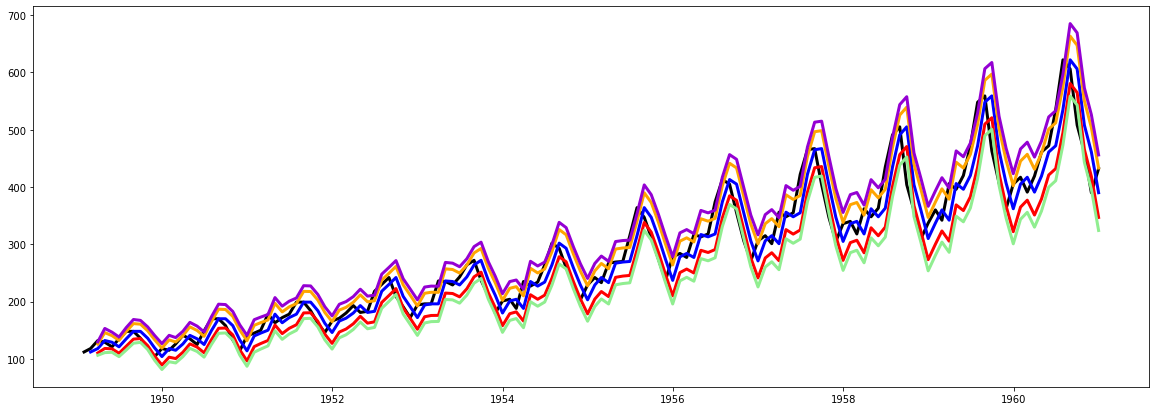

In [ ]:
#| hide 
# In-sample prediction intervals 
import matplotlib.pyplot as plt
import pandas as pd 
from datetime import date, timedelta

naive = Naive()
fcst_naive = naive.forecast(ap,12,None,None,True,(80,95))

# fcst_naive = naive.fit(ap) 
# fcst_naive = naive.predict_in_sample((80,95))

fig, ax = plt.subplots(1, 1, figsize = (20,7))

sdate = date(1949,1,1) # start date 
edate = date(1961,1,1) # end date
dates = pd.date_range(sdate,edate-timedelta(days=1),freq='m')

df = pd.DataFrame({'dates': dates,
                   'actual': ap,
                   'fitted': fcst_naive['fitted'],
                   'fitted_lo_80': fcst_naive['fitted-lo-80'], 
                   'fitted_lo_95': fcst_naive['fitted-lo-95'], 
                   'fitted_hi_80': fcst_naive['fitted-hi-80'],
                   'fitted_hi_95': fcst_naive['fitted-hi-95']})

plt.plot(df.dates, df.actual, color='black', label='fitted-lo-80', linewidth=3)
plt.plot(df.dates, df.fitted, color='blue', label='fitted-lo-80', linewidth=3)
plt.plot(df.dates, df.fitted_lo_80, color='red', label='fitted-lo-80', linewidth=3)
plt.plot(df.dates, df.fitted_lo_95, color='lightgreen', label='fitted-lo-95', linewidth=3)
plt.plot(df.dates, df.fitted_hi_80, color='orange', label='fitted-hi-80', linewidth=3)
plt.plot(df.dates, df.fitted_hi_95, color='darkviolet', label='fitted-hi-95', linewidth=3)

In [ ]:
#| hide
df.sum(axis=0) # this equals the results with the forecast R package 

actual          40363.000000
fitted          39931.000000
fitted_lo_80    36153.715366
fitted_lo_95    34213.430884
fitted_hi_80    43484.284634
fitted_hi_95    45424.569116
dtype: float64

In [ ]:
#| hide
# DEV ENDS HERE 

In [ ]:
#| hide 
# Test prediction intervals - forecast
naive = Naive()
fcst_naive = naive.forecast(ap, 12, None, None, True, (80,95))

In [ ]:
#| hide 
# Test prediction intervals - fit & predict
naive = Naive()
fcst_naive = naive.fit(ap)
fcst_naive = naive.predict(12)

In [ ]:
#| hide
naive = Naive()
test_class(naive, x=ap, h=12)
naive.fit(ap)
fcst_naive = naive.predict(12)
test_close(fcst_naive['mean'], np.repeat(ap[-1], 12), eps=1e-5)

In [ ]:
#| hide 
naive = Naive()
fcst_naive = naive.forecast(ap,12,None,None,False,(80,95))
np.testing.assert_almost_equal(
    fcst_naive['lo-80'],
    np.array([388.7984, 370.9037, 357.1726, 345.5967, 335.3982, 326.1781, 317.6992, 309.8073, 302.3951, 295.3845, 288.7164, 282.3452]),
    decimal=4
) # this is almost equal since Hyndman's forecasts are rounded up to 4 decimals

In [ ]:
show_doc(Naive, title_level=3)

---

### Naive

>      Naive ()

Naive model.
[Source code](https://github.com/Nixtla/statsforecast/blob/main/statsforecast/simple_methods.py).

A random walk model, defined as $\hat{y}_{t+1} = y_t$ $orall t$

**Parameters:**<br>

**References:**<br>
[Rob J. Hyndman and George Athanasopoulos (2018). "forecasting principles and practice, Simple Methods"](https://otexts.com/fpp3/simple-methods.html).

In [ ]:
show_doc(Naive.forecast, title_level=3)

---

#### Naive.forecast

>      Naive.forecast (y:numpy.ndarray, h:int, X:numpy.ndarray=None,
>                      X_future:numpy.ndarray=None, fitted:bool=False,
>                      level=None)

Memory Efficient Naive predictions.

This method avoids memory burden due from object storage.
It is analogous to `fit_predict` without storing information.
It assumes you know the forecast horizon in advance.

**Parameters:**<br>
`y`: numpy array of shape (n,), clean time series.<br>
`h`: int, forecast horizon.<br>
`level`: float list 0-100, confidence levels for prediction intervals.<br>
`fitted`: bool, wether or not returns insample predictions.<br>

**Returns:**<br>
`forecasts`: dictionary, with entries 'mean' for point predictions and
    'level_*' for probabilistic predictions.<br>

In [ ]:
show_doc(Naive.fit, title_level=3)

---

#### Naive.fit

>      Naive.fit (y:numpy.ndarray, X:numpy.ndarray=None)

Fit the Naive model.

Fit an Naive to a time series (numpy array) `y`.

**Parameters:**<br>
`y`: numpy array of shape (t, ), clean time series.<br>

**Returns:**<br>
`self`: Naive fitted model.

In [ ]:
show_doc(Naive.predict, title_level=3)

---

#### Naive.predict

>      Naive.predict (h:int, X:numpy.ndarray=None,
>                     level:Optional[Tuple[int]]=None)

Predict with fitted Naive.

**Parameters:**<br>
`h`: int, forecast horizon.<br>

**Returns:**<br>
`forecasts`: dictionary, with entries 'mean' for point predictions and
    'level_*' for probabilistic predictions.<br>

|    | **Type** | **Default** | **Details** |
| -- | -------- | ----------- | ----------- |
| h | int |  | forecasting horizon |
| X | ndarray | None | exogenous regressors |
| level | typing.Optional[typing.Tuple[int]] | None | confidence level |

In [ ]:
show_doc(Naive.predict_in_sample, title_level=3)

---

#### Naive.predict_in_sample

>      Naive.predict_in_sample (level:Optional[Tuple[int]]=None)

Access fitted Naive insample predictions.

**Parameters:**<br>
`level`: float list 0-100, confidence levels for prediction intervals.<br>

**Returns:**<br>
`forecasts`: dictionary, with entries 'mean' for point predictions and
    'level_*' for probabilistic predictions.<br>

In [ ]:
# Naive's usage example

from statsforecast.models import Naive
from statsforecast.utils import AirPassengers as ap


model = Naive()
model = model.fit(y=ap)
y_hat_dict = model.predict(h=4)
y_hat_dict

{'mean': array([432., 432., 432., 432.], dtype=float32)}

## RandomWalkWithDrift

In [ ]:
#| exporti
@njit
def _random_walk_with_drift(
        y: np.ndarray, # time series
        h: int, # forecasting horizon
        fitted: bool, # fitted values
    ): 
    slope = (y[-1] - y[0]) / (y.size - 1)
    mean = slope * (1 + np.arange(h)) + y[-1]
    fcst = {'mean': mean.astype(np.float32), 
            'slope': np.array([slope], dtype=np.float32), 
            'last_y': np.array([y[-1]], dtype=np.float32)}
    if fitted:
        fitted_vals = np.full(y.size, np.nan, dtype=np.float32)
        fitted_vals[1:] = (slope + y[:-1]).astype(np.float32)
        fcst['fitted'] = fitted_vals
    return fcst

In [ ]:
#| export
class RandomWalkWithDrift(_TS):
    
    def __init__(self):
        """RandomWalkWithDrift model.
        [Source code](https://github.com/Nixtla/statsforecast/blob/main/statsforecast/simple_methods.py).

        A variation of the naive method allows the forecasts to change over time. 
        The amout of change, called drift, is the average change seen in the historical data. 

        $$ \hat{y}_{t+1} = y_t+\\frac{1}{t-1}\sum_{j=1}^t (y_j-y_{j-1}) = y_t+ \\frac{y_t-y_1}{t-1} $$

        From the previous equation, we can see that this is equivalent to extrapolating a line between 
        the first and the last observation. 

        **Parameters:**<br>

        **References:**<br>
        [Rob J. Hyndman and George Athanasopoulos (2018). "forecasting principles and practice, Simple Methods"](https://otexts.com/fpp3/simple-methods.html).
        """
        pass
    
    def __repr__(self):
        return 'RWD'
    
    def fit(
            self,
            y: np.ndarray,
            X: np.ndarray = None
        ):
        """Fit the RandomWalkWithDrift model.

        Fit an RandomWalkWithDrift to a time series (numpy array) `y`.

        **Parameters:**<br>
        `y`: numpy array of shape (t, ), clean time series.<br>

        **Returns:**<br>
        `self`: RandomWalkWithDrift fitted model.
        """        
        mod = _random_walk_with_drift(y, h=1, fitted=True)
        mod = dict(mod) 
        residuals = y - mod['fitted']
        sigma = _calculate_sigma(residuals, len(residuals) - 1)
        mod['sigma'] = sigma
        mod['n'] = len(y)
        
        sigma_vals = np.zeros(len(y))
        sigma_vals[0] = float("nan")
        for k in range(2,len(y)): 
            model = _random_walk_with_drift(y[:k], h=1, fitted=True)
            residuals = y[:k]-model['fitted']
            sigma = _calculate_sigma(residuals, len(residuals)-1)
            sigma_vals[k-1] = sigma 
    
        mod['sigma_vals'] = sigma_vals

        self.model_ = mod
        return self
        
    def predict(
            self,
            h: int, 
            X: np.ndarray = None, 
            level: Optional[Tuple[int]] = None
        ):
        """Predict with fitted RandomWalkWithDrift.

        **Parameters:**<br>
        `h`: int, forecast horizon.<br>

        **Returns:**<br>
        `forecasts`: dictionary, with entries 'mean' for point predictions and
            'level_*' for probabilistic predictions.<br>
        """
        hrange = np.arange(h, dtype=np.float32)
        mean = self.model_['slope'] * (1 + hrange) + self.model_['last_y']
        res = {'mean': mean}
        
        if level is not None: 
            steps = np.arange(1, h + 1)
            sigma = self.model_['sigma']
            sigmah = sigma * np.sqrt(steps * (1 + steps / (self.model_['n'] - 1)))
            pred_int = _calculate_intervals(res, level, h, sigmah)
            res = {**res, **pred_int}
        
        return res
    
    def predict_in_sample(
            self,
            level: Optional[Tuple[int]] = None
        ):
        """Access fitted RandomWalkWithDrift insample predictions.

        **Parameters:**<br>
        `level`: float list 0-100, confidence levels for prediction intervals.<br>

        **Returns:**<br>
        `forecasts`: dictionary, with entries 'mean' for point predictions and
            'level_*' for probabilistic predictions.<br>
        """
        res = {'mean': self.model_['fitted']}
        
        if level is not None: 
            pi = np.zeros([len(self.model_['sigma_vals']), len(level)*2])
            pi[0:2,:] = float("nan")  
            for k in range(1,len(pi)):
                sigma = self.model_['sigma_vals'][k-1]
                vals = {'mean': mod['fitted'][:k+1]}
                intervals = _calculate_intervals(vals, level, 1, sigma)
                vals_int = np.array(list(intervals.values()))
                pi[k,] = vals_int[:,vals_int.shape[1]-1]
        
            fitted_int = {**{f'fitted-lo-{lv}': pi[:,i] for i, lv in enumerate(level)},
                          **{f'fitted-hi-{lv}': pi[:,i+2] for i, lv in enumerate(level)}} 

            res = {**res, **fitted_int}
        
        return res

    def forecast(
            self, 
            y: np.ndarray,
            h: int,
            X: np.ndarray = None,
            X_future: np.ndarray = None,
            fitted: bool = False,
            level: Optional[Tuple[int]] = None,
        ):
        """Memory Efficient RandomWalkWithDrift predictions.

        This method avoids memory burden due from object storage.
        It is analogous to `fit_predict` without storing information.
        It assumes you know the forecast horizon in advance.

        **Parameters:**<br>
        `y`: numpy array of shape (n,), clean time series.<br>
        `h`: int, forecast horizon.<br>
        `level`: float list 0-100, confidence levels for prediction intervals.<br>
        `fitted`: bool, wether or not returns insample predictions.<br>

        **Returns:**<br>
        `forecasts`: dictionary, with entries 'mean' for point predictions and
            'level_*' for probabilistic predictions.<br>
        """
        fitted = fitted or (level is not None)
        out = _random_walk_with_drift(y=y, h=h, fitted=fitted)
        res = {'mean': out['mean']}
        
        if fitted:
            res['fitted'] = out['fitted']
        
        if level is not None: 
            steps = np.arange(1, h + 1)
            residuals = y - out['fitted']
            sigma = _calculate_sigma(residuals, len(residuals) - 1)
            sigmah = sigma * np.sqrt(steps * (1 + steps / (len(y) - 1)))
            pred_int = _calculate_intervals(out, level, h, sigmah)
            res = {**res, **pred_int}
            
            if fitted: 
                pi = np.zeros([len(y),len(level)*2])
                pi[0:3,:] = float("nan")
                for k in range(3,len(y)): 
                    model = _random_walk_with_drift(y=y[:k,], h=1, fitted=fitted)
                    residuals = y[:k]-model['fitted']
                    sigma = _calculate_sigma(residuals, len(residuals)-1)
                    intervals = _calculate_intervals(model, level, 1, sigma)
                    pi[k,] = np.array(list(intervals.values())).reshape(1,len(level)*2)
                    
                fitted_int = {**{f'fitted-lo-{lv}': pi[:,i] for i, lv in enumerate(level)},
                              **{f'fitted-hi-{lv}': pi[:,i+2] for i, lv in enumerate(level)}} 

                res = {**res, **fitted_int}
            
        return res 

[<matplotlib.lines.Line2D>]

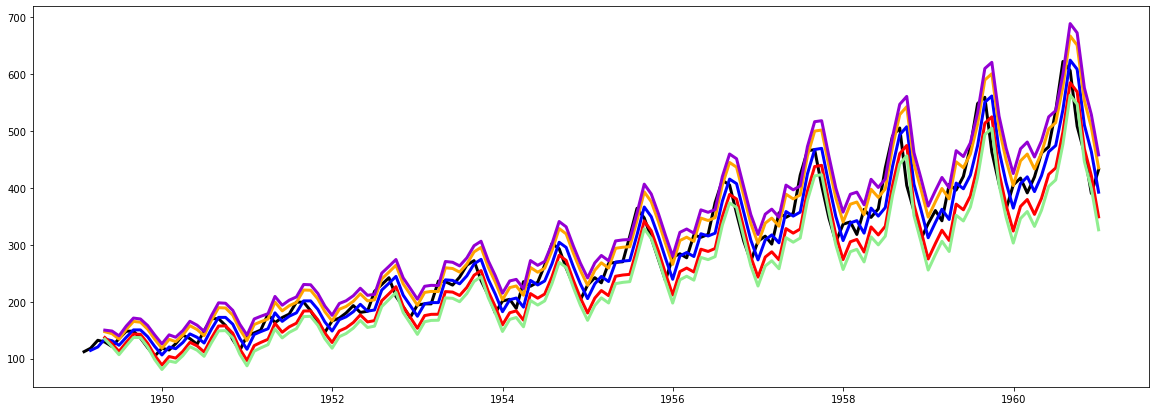

In [ ]:
#| hide
# In-sample prediction intervals 
rwd = RandomWalkWithDrift()
fcst_rwd = rwd.forecast(ap, 12, None, None, True, (80,95))

# fcst_rwd = rwd.fit(ap) 
# fcst_rwd = rwd.predict_in_sample((80,95))

fig, ax = plt.subplots(1, 1, figsize = (20,7))

sdate = date(1949,1,1) # start date 
edate = date(1961,1,1) # end date
dates = pd.date_range(sdate,edate-timedelta(days=1),freq='m')

df = pd.DataFrame({'dates': dates,
                   'actual': ap,
                   'fitted': fcst_rwd['fitted'],
                   'fitted_lo_80': fcst_rwd['fitted-lo-80'], 
                   'fitted_lo_95': fcst_rwd['fitted-lo-95'], 
                   'fitted_hi_80': fcst_rwd['fitted-hi-80'],
                   'fitted_hi_95': fcst_rwd['fitted-hi-95']})

plt.plot(df.dates, df.actual, color='black', label='fitted-lo-80', linewidth=3)
plt.plot(df.dates, df.fitted, color='blue', label='fitted-lo-80', linewidth=3)
plt.plot(df.dates, df.fitted_lo_80, color='red', label='fitted-lo-80', linewidth=3)
plt.plot(df.dates, df.fitted_lo_95, color='lightgreen', label='fitted-lo-95', linewidth=3)
plt.plot(df.dates, df.fitted_hi_80, color='orange', label='fitted-hi-80', linewidth=3)
plt.plot(df.dates, df.fitted_hi_95, color='darkviolet', label='fitted-hi-95', linewidth=3)

In [ ]:
#| hide
df.sum(axis=0) # this equals the results with the forecast R package

actual          40363.000000
fitted          40251.000000
fitted_lo_80    36410.378856
fitted_lo_95    34495.287715
fitted_hi_80    43645.765416
fitted_hi_95    45560.856557
dtype: float64

In [ ]:
#| hide 
# Test prediction intervals - forecast
rwd = RandomWalkWithDrift()
fcst_rwd = rwd.forecast(ap, 12, None, None, True, (80,95))

In [ ]:
#| hide 
# Test prediction intervals - fit & predict 
rwd = RandomWalkWithDrift()
fcst_rwd = rwd.fit(ap)
fcst_rwd = rwd.predict(12, None, (80,95))

In [ ]:
#| hide
rwd = RandomWalkWithDrift()
test_class(rwd, x=ap, h=12)
rwd = rwd.fit(ap)
fcst_rwd = rwd.predict(12)
test_close(fcst_rwd['mean'][:2], np.array([434.2378, 436.4755]), eps=1e-4)
np.testing.assert_almost_equal(
    rwd.predict_in_sample()['mean'][:3], 
    np.array([np.nan, 118 - 3.7622378, 132 - 11.7622378]),
    decimal=6
)

In [ ]:
#| hide 
rwd = RandomWalkWithDrift()
fcst_rwd = rwd.forecast(ap,12,None,None,False,(80,95))
np.testing.assert_almost_equal(
    fcst_rwd['lo-80'],
    np.array([390.9799, 375.0862, 363.2664, 353.5325, 345.1178, 337.6304, 330.8384, 324.5916, 318.7857, 313.3453, 308.2136, 303.3469]),
    decimal=1
)

In [ ]:
show_doc(RandomWalkWithDrift, title_level=3)

---

### RandomWalkWithDrift

>      RandomWalkWithDrift ()

RandomWalkWithDrift model.
[Source code](https://github.com/Nixtla/statsforecast/blob/main/statsforecast/simple_methods.py).

A variation of the naive method allows the forecasts to change over time. 
The amout of change, called drift, is the average change seen in the historical data. 

$$ \hat{y}_{t+1} = y_t+\frac{1}{t-1}\sum_{j=1}^t (y_j-y_{j-1}) = y_t+ \frac{y_t-y_1}{t-1} $$

From the previous equation, we can see that this is equivalent to extrapolating a line between 
the first and the last observation. 

**Parameters:**<br>

**References:**<br>
[Rob J. Hyndman and George Athanasopoulos (2018). "forecasting principles and practice, Simple Methods"](https://otexts.com/fpp3/simple-methods.html).

In [ ]:
show_doc(RandomWalkWithDrift.forecast, title_level=3)

---

#### RandomWalkWithDrift.forecast

>      RandomWalkWithDrift.forecast (y:numpy.ndarray, h:int,
>                                    X:numpy.ndarray=None,
>                                    X_future:numpy.ndarray=None,
>                                    fitted:bool=False,
>                                    level:Optional[Tuple[int]]=None)

Memory Efficient RandomWalkWithDrift predictions.

This method avoids memory burden due from object storage.
It is analogous to `fit_predict` without storing information.
It assumes you know the forecast horizon in advance.

**Parameters:**<br>
`y`: numpy array of shape (n,), clean time series.<br>
`h`: int, forecast horizon.<br>
`level`: float list 0-100, confidence levels for prediction intervals.<br>
`fitted`: bool, wether or not returns insample predictions.<br>

**Returns:**<br>
`forecasts`: dictionary, with entries 'mean' for point predictions and
    'level_*' for probabilistic predictions.<br>

In [ ]:
show_doc(RandomWalkWithDrift.fit, title_level=3)

---

#### RandomWalkWithDrift.fit

>      RandomWalkWithDrift.fit (y:numpy.ndarray, X:numpy.ndarray=None)

Fit the RandomWalkWithDrift model.

Fit an RandomWalkWithDrift to a time series (numpy array) `y`.

**Parameters:**<br>
`y`: numpy array of shape (t, ), clean time series.<br>

**Returns:**<br>
`self`: RandomWalkWithDrift fitted model.

In [ ]:
show_doc(RandomWalkWithDrift.predict, title_level=3)

---

#### RandomWalkWithDrift.predict

>      RandomWalkWithDrift.predict (h:int, X:numpy.ndarray=None,
>                                   level:Optional[Tuple[int]]=None)

Predict with fitted RandomWalkWithDrift.

**Parameters:**<br>
`h`: int, forecast horizon.<br>

**Returns:**<br>
`forecasts`: dictionary, with entries 'mean' for point predictions and
    'level_*' for probabilistic predictions.<br>

In [ ]:
show_doc(RandomWalkWithDrift.predict_in_sample, title_level=3)

---

#### RandomWalkWithDrift.predict_in_sample

>      RandomWalkWithDrift.predict_in_sample (level:Optional[Tuple[int]]=None)

Access fitted RandomWalkWithDrift insample predictions.

**Parameters:**<br>
`level`: float list 0-100, confidence levels for prediction intervals.<br>

**Returns:**<br>
`forecasts`: dictionary, with entries 'mean' for point predictions and
    'level_*' for probabilistic predictions.<br>

In [ ]:
# RandomWalkWithDrift's usage example

from statsforecast.models import RandomWalkWithDrift
from statsforecast.utils import AirPassengers as ap


model = RandomWalkWithDrift()
model = model.fit(y=ap)
y_hat_dict = model.predict(h=4)
y_hat_dict

{'mean': array([434.23776, 436.47552, 438.7133 , 440.95105], dtype=float32)}

## SeasonalNaive

In [ ]:
#| exporti
@njit
def _seasonal_naive(
        y: np.ndarray, # time series
        h: int, # forecasting horizon
        fitted: bool, #fitted values
        season_length: int, # season length
    ): 
    if y.size < season_length:
        return {'mean': np.full(h, np.nan, np.float32)}
    season_vals = np.empty(season_length, np.float32)
    fitted_vals = np.full(y.size, np.nan, np.float32)
    for i in range(season_length):
        s_naive = _naive(y[i::season_length], h=1, fitted=fitted)
        season_vals[i] = s_naive['mean'].item()
        if fitted:
            fitted_vals[i::season_length] = s_naive['fitted']
    out = _repeat_val_seas(season_vals=season_vals, h=h, season_length=season_length)
    fcst = {'mean': out}
    if fitted:
        fcst['fitted'] = fitted_vals
    return fcst

In [ ]:
#| export
class SeasonalNaive(_TS):
    
    def __init__(self, season_length: int):
        self.season_length = season_length

    def __repr__(self):
        return 'SeasonalNaive'
    
    def fit(
            self,
            y: np.ndarray,
            X: np.ndarray = None
        ):
        """Fit the SeasonalNaive model.

        Fit an SeasonalNaive to a time series (numpy array) `y`.

        **Parameters:**<br>
        `y`: numpy array of shape (t, ), clean time series.<br>

        **Returns:**<br>
        `self`: SeasonalNaive fitted model.
        """        
        mod = _seasonal_naive(
            y=y, 
            season_length=self.season_length, 
            h=self.season_length, 
            fitted=True,
        )
        mod = dict(mod) 
        residuals = y - mod['fitted']
        mod['sigma'] = _calculate_sigma(residuals, 
                                        len(y) - self.season_length)
        self.model_ = mod
        return self
        
        
    def predict(
            self,
            h: int,  
            X: np.ndarray = None,
            level: Optional[Tuple[int]] = None, 
        ):
        """Predict with fitted Naive.

        **Parameters:**<br>
        `h`: int, forecast horizon.<br>

        **Returns:**<br>
        `forecasts`: dictionary, with entries 'mean' for point predictions and
            'level_*' for probabilistic predictions.<br>
        """
        mean = _repeat_val_seas(season_vals=self.model_['mean'], 
                                season_length=self.season_length, h=h)
        res = {'mean': mean}
        
        if level is not None: 
            k = np.floor((h - 1) / self.season_length)
            sigma = self.model_['sigma']
            sigmah = sigma * np.sqrt(k + 1)
            pred_int = _calculate_intervals(res, level, h, sigmah)
            res = {**res, **pred_int}
        
        return res
        
    def predict_in_sample(self):
        """Access fitted SeasonalNaive insample predictions.

        **Parameters:**<br>
        `level`: float list 0-100, confidence levels for prediction intervals.<br>

        **Returns:**<br>
        `forecasts`: dictionary, with entries 'mean' for point predictions and
            'level_*' for probabilistic predictions.<br>
        """        
        res = {'mean': self.model_['fitted']}
        return res
    
    def forecast(
            self, 
            y: np.ndarray,
            h: int,
            X: np.ndarray = None,
            X_future: np.ndarray = None,
            fitted: bool = False,
            level: Optional[Tuple[int]] = None,
        ):
        """Memory Efficient SeasonalNaive predictions.

        This method avoids memory burden due from object storage.
        It is analogous to `fit_predict` without storing information.
        It assumes you know the forecast horizon in advance.

        **Parameters:**<br>
        `y`: numpy array of shape (n,), clean time series.<br>
        `h`: int, forecast horizon.<br>
        `level`: float list 0-100, confidence levels for prediction intervals.<br>
        `fitted`: bool, wether or not returns insample predictions.<br>

        **Returns:**<br>
        `forecasts`: dictionary, with entries 'mean' for point predictions and
            'level_*' for probabilistic predictions.<br>
        """
        fitted = fitted or (level is not None)
        out = _seasonal_naive(
            y=y, h=h, fitted=fitted, 
            season_length=self.season_length
        )
        res = {'mean': out['mean']}
        
        if fitted:
            res['fitted'] = out['fitted']
        
        if level is not None: 
            k = np.floor((h - 1) / self.season_length)
            residuals = y - out['fitted']
            sigma = _calculate_sigma(residuals, len(y) - self.season_length)
            sigmah = sigma * np.sqrt(k + 1)
            pred_int = _calculate_intervals(out, level, h, sigmah)
            res = {**res, **pred_int}
                
        return res    

In [ ]:
#| hide 
# Test prediction intervals - forecast
seas_naive = SeasonalNaive(season_length=12)
seas_naive.forecast(ap, 12, None, None, True, (80,95))

{'mean': array([417., 391., 419., 461., 472., 535., 622., 606., 508., 461., 390.,
        432.], dtype=float32),
 'fitted': array([ nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,
         nan, 112., 118., 132., 129., 121., 135., 148., 148., 136., 119.,
        104., 118., 115., 126., 141., 135., 125., 149., 170., 170., 158.,
        133., 114., 140., 145., 150., 178., 163., 172., 178., 199., 199.,
        184., 162., 146., 166., 171., 180., 193., 181., 183., 218., 230.,
        242., 209., 191., 172., 194., 196., 196., 236., 235., 229., 243.,
        264., 272., 237., 211., 180., 201., 204., 188., 235., 227., 234.,
        264., 302., 293., 259., 229., 203., 229., 242., 233., 267., 269.,
        270., 315., 364., 347., 312., 274., 237., 278., 284., 277., 317.,
        313., 318., 374., 413., 405., 355., 306., 271., 306., 315., 301.,
        356., 348., 355., 422., 465., 467., 404., 347., 305., 336., 340.,
        318., 362., 348., 363., 435., 491., 505., 404., 359., 3

In [ ]:
#| hide 
# Test prediction intervals - fit and predict 
seas_naive = SeasonalNaive(season_length=12)
seas_naive.fit(ap)
seas_naive.predict(12)
seas_naive.predict(12, None, (80,95))

{'mean': array([417., 391., 419., 461., 472., 535., 622., 606., 508., 461., 390.,
        432.], dtype=float32),
 'lo-80': array([370.45950017, 344.45950017, 372.45950017, 414.45950017,
        425.45950017, 488.45950017, 575.45950017, 559.45950017,
        461.45950017, 414.45950017, 343.45950017, 385.45950017]),
 'lo-95': array([345.82244777, 319.82244777, 347.82244777, 389.82244777,
        400.82244777, 463.82244777, 550.82244777, 534.82244777,
        436.82244777, 389.82244777, 318.82244777, 360.82244777]),
 'hi-80': array([463.54049983, 437.54049983, 465.54049983, 507.54049983,
        518.54049983, 581.54049983, 668.54049983, 652.54049983,
        554.54049983, 507.54049983, 436.54049983, 478.54049983]),
 'hi-95': array([488.17755223, 462.17755223, 490.17755223, 532.17755223,
        543.17755223, 606.17755223, 693.17755223, 677.17755223,
        579.17755223, 532.17755223, 461.17755223, 503.17755223])}

In [ ]:
#| hide
seas_naive = SeasonalNaive(season_length=12)
test_class(seas_naive, x=ap, h=12)
seas_naive = seas_naive.fit(ap)
fcst_seas_naive = seas_naive.predict(12)
test_eq(seas_naive.predict_in_sample()['mean'][-3:], np.array([461 - 54., 390 - 28., 432 - 27.]))

In [ ]:
#| hide 
seas_naive = SeasonalNaive(season_length=12)
fcst_seas_naive = seas_naive.forecast(ap, 12, None, None, False, (80,95))
np.testing.assert_almost_equal(
    fcst_seas_naive['lo-80'],
    np.array([370.4595, 344.4595, 372.4595, 414.4595, 425.4595, 488.4595, 
              575.4595, 559.4595, 461.4595, 414.4595, 343.4595, 385.4595]),
    decimal=4
)

In [ ]:
show_doc(SeasonalNaive, title_level=3)

---

### SeasonalNaive

>      SeasonalNaive (season_length:int)

Initialize self.  See help(type(self)) for accurate signature.

In [ ]:
show_doc(SeasonalNaive.forecast, title_level=3)

---

#### SeasonalNaive.forecast

>      SeasonalNaive.forecast (y:numpy.ndarray, h:int, X:numpy.ndarray=None,
>                              X_future:numpy.ndarray=None, fitted:bool=False,
>                              level:Optional[Tuple[int]]=None)

Memory Efficient SeasonalNaive predictions.

This method avoids memory burden due from object storage.
It is analogous to `fit_predict` without storing information.
It assumes you know the forecast horizon in advance.

**Parameters:**<br>
`y`: numpy array of shape (n,), clean time series.<br>
`h`: int, forecast horizon.<br>
`level`: float list 0-100, confidence levels for prediction intervals.<br>
`fitted`: bool, wether or not returns insample predictions.<br>

**Returns:**<br>
`forecasts`: dictionary, with entries 'mean' for point predictions and
    'level_*' for probabilistic predictions.<br>

In [ ]:
show_doc(SeasonalNaive.fit, title_level=3)

---

#### SeasonalNaive.fit

>      SeasonalNaive.fit (y:numpy.ndarray, X:numpy.ndarray=None)

Fit the SeasonalNaive model.

Fit an SeasonalNaive to a time series (numpy array) `y`.

**Parameters:**<br>
`y`: numpy array of shape (t, ), clean time series.<br>

**Returns:**<br>
`self`: SeasonalNaive fitted model.

In [ ]:
show_doc(SeasonalNaive.predict, title_level=3)

---

#### SeasonalNaive.predict

>      SeasonalNaive.predict (h:int, X:numpy.ndarray=None,
>                             level:Optional[Tuple[int]]=None)

Predict with fitted Naive.

**Parameters:**<br>
`h`: int, forecast horizon.<br>

**Returns:**<br>
`forecasts`: dictionary, with entries 'mean' for point predictions and
    'level_*' for probabilistic predictions.<br>

In [ ]:
show_doc(SeasonalNaive.predict_in_sample, title_level=3)

---

#### SeasonalNaive.predict_in_sample

>      SeasonalNaive.predict_in_sample ()

Access fitted SeasonalNaive insample predictions.

**Parameters:**<br>
`level`: float list 0-100, confidence levels for prediction intervals.<br>

**Returns:**<br>
`forecasts`: dictionary, with entries 'mean' for point predictions and
    'level_*' for probabilistic predictions.<br>

In [ ]:
# SeasonalNaive's usage example

from statsforecast.models import SeasonalNaive
from statsforecast.utils import AirPassengers as ap


model = SeasonalNaive(season_length=12)
model = model.fit(y=ap)
y_hat_dict = model.predict(h=4)
y_hat_dict

{'mean': array([417., 391., 419., 461.], dtype=float32)}

## WindowAverage

In [ ]:
#| exporti
@njit
def _window_average(
        y: np.ndarray, # time series
        h: int, # forecasting horizon
        fitted: bool, # fitted values
        window_size: int # window size
    ): 
    if fitted:
        raise NotImplementedError('return fitted')
    if y.size < window_size:
        return {'mean': np.full(h, np.nan, np.float32)}
    wavg = y[-window_size:].mean()
    mean = _repeat_val(val=wavg, h=h)
    return {'mean': mean}

In [ ]:
#| export
class WindowAverage(_TS):
    
    def __init__(
            self, 
            window_size: int
        ):
        """WindowAverage model.
        [Source code](https://github.com/Nixtla/statsforecast/blob/main/statsforecast/simple_methods.py).

        Uses the average of the last $k$ observations, with $k$ the length of the window.
        Wider windows will capture global trends, while narrow windows will reveal local trends.
        The length of the window selected should take into account the importance of past
        observations and how fast the series changes.

        **Parameters:**<br>
        `window_size`: int, size of truncated series on which average is estimated.

        **References:**<br>
        [Rob J. Hyndman and George Athanasopoulos (2018). "forecasting principles and practice, Simple Methods"](https://otexts.com/fpp3/simple-methods.html).
        """        
        self.window_size = window_size

    def __repr__(self):
        return 'WindowAverage'
    
    def fit(
            self,
            y: np.ndarray,
            X: np.ndarray = None
        ):
        """Fit the WindowAverage model.

        Fit an WindowAverage to a time series (numpy array) `y`
        and optionally exogenous variables (numpy array) `X`.

        **Parameters:**<br>
        `y`: numpy array of shape (t, ), clean time series.<br>
        `X`: array-like of shape (t, n_x) optional exogenous (default=None).<br>

        **Returns:**<br>
        `self`: WindowAverage fitted model.
        """
        mod = _window_average(y=y, h=1, window_size=self.window_size, fitted=False)
        mod = dict(mod)
        arima = arima_model(y[len(y)-self.window_size:len(y)], (0,0,0))
        mod['arima'] = arima
        self.model_ = mod
    
        return self
        
    def predict(
            self, 
            h: int,
            X: np.ndarray = None, 
            level: Optional[Tuple[int]] = None
        ):
        """Predict with fitted WindowAverage.

        **Parameters:**<br>
        `h`: int, forecast horizon.<br>

        **Returns:**<br>
        `forecasts`: dictionary, with entries 'mean' for point predictions and
            'level_*' for probabilistic predictions.<br>
        """
        mean = _repeat_val(self.model_['mean'][0], h=h)
        res = {'mean': mean}
        
        if level is not None: 
            fcst = forecast_arima(self.model_['arima'], h = h, level = level)
            pred_int = {**{f'lo-{lv}': fcst['lower'].iloc[:,i].to_numpy(dtype = np.float32) for i, lv in enumerate(level)},
                        **{f'hi-{lv}': fcst['upper'].iloc[:,i].to_numpy(dtype = np.float32) for i, lv in enumerate(level)}}  
            res = {**res, **pred_int}
        
        return res
    
    def predict_in_sample(self):
        """Access fitted WindowAverage insample predictions.

        **Parameters:**<br>
        `level`: float list 0-100, confidence levels for prediction intervals.<br>

        **Returns:**<br>
        `forecasts`: dictionary, with entries 'mean' for point predictions and
            'level_*' for probabilistic predictions.<br>
        """
        raise NotImplementedError
        
    def forecast(
            self, 
            y: np.ndarray,
            h: int,
            X: np.ndarray = None,
            X_future: np.ndarray = None,
            fitted: bool = False,
            level: Optional[Tuple[int]] = None
        ):
        """Memory Efficient WindowAverage predictions.

        This method avoids memory burden due from object storage.
        It is analogous to `fit_predict` without storing information.
        It assumes you know the forecast horizon in advance.

        **Parameters:**<br>
        `y`: numpy array of shape (n,), clean time series.<br>
        `h`: int, forecast horizon.<br>
        `level`: float list 0-100, confidence levels for prediction intervals.<br>
        `fitted`: bool, wether or not returns insample predictions.<br>

        **Returns:**<br>
        `forecasts`: dictionary, with entries 'mean' for point predictions and
            'level_*' for probabilistic predictions.<br>
        """
        out = _window_average(y=y, h=h, fitted=fitted, window_size=self.window_size)
        res = {'mean': out['mean']}
        
        if level is not None: 
            fcst = forecast_arima(arima_model(y[len(y)-self.window_size:len(y)], (0,0,0)), h = h, level = level)
            pred_int = {**{f'lo-{lv}': fcst['lower'].iloc[:,i].to_numpy(dtype = np.float32) for i, lv in enumerate(level)},
                        **{f'hi-{lv}': fcst['upper'].iloc[:,i].to_numpy(dtype = np.float32) for i, lv in enumerate(level)}}  
            res = {**res, **pred_int}
            
        return res 

In [ ]:
#| hide 
w_avg = WindowAverage(window_size=24) 
w_avg.forecast(ap, 12, None, None, False, (80,95))

{'mean': array([452.25, 452.25, 452.25, 452.25, 452.25, 452.25, 452.25, 452.25,
        452.25, 452.25, 452.25, 452.25], dtype=float32),
 'lo-80': array([352.29178, 352.29178, 352.29178, 352.29178, 352.29178, 352.29178,
        352.29178, 352.29178, 352.29178, 352.29178, 352.29178, 352.29178],
       dtype=float32),
 'lo-95': array([299.3771, 299.3771, 299.3771, 299.3771, 299.3771, 299.3771,
        299.3771, 299.3771, 299.3771, 299.3771, 299.3771, 299.3771],
       dtype=float32),
 'hi-80': array([552.20825, 552.20825, 552.20825, 552.20825, 552.20825, 552.20825,
        552.20825, 552.20825, 552.20825, 552.20825, 552.20825, 552.20825],
       dtype=float32),
 'hi-95': array([605.1229, 605.1229, 605.1229, 605.1229, 605.1229, 605.1229,
        605.1229, 605.1229, 605.1229, 605.1229, 605.1229, 605.1229],
       dtype=float32)}

In [ ]:
#| hide 
w_avg = WindowAverage(window_size=24) 
w_avg.fit(ap)
w_avg.predict(12, None, (80,95))

{'mean': array([452.25, 452.25, 452.25, 452.25, 452.25, 452.25, 452.25, 452.25,
        452.25, 452.25, 452.25, 452.25], dtype=float32),
 'lo-80': array([352.29178, 352.29178, 352.29178, 352.29178, 352.29178, 352.29178,
        352.29178, 352.29178, 352.29178, 352.29178, 352.29178, 352.29178],
       dtype=float32),
 'lo-95': array([299.3771, 299.3771, 299.3771, 299.3771, 299.3771, 299.3771,
        299.3771, 299.3771, 299.3771, 299.3771, 299.3771, 299.3771],
       dtype=float32),
 'hi-80': array([552.20825, 552.20825, 552.20825, 552.20825, 552.20825, 552.20825,
        552.20825, 552.20825, 552.20825, 552.20825, 552.20825, 552.20825],
       dtype=float32),
 'hi-95': array([605.1229, 605.1229, 605.1229, 605.1229, 605.1229, 605.1229,
        605.1229, 605.1229, 605.1229, 605.1229, 605.1229, 605.1229],
       dtype=float32)}

In [ ]:
#| hide
w_avg = WindowAverage(window_size=24)
test_class(w_avg, x=ap, h=12, skip_insample=True)
w_avg = w_avg.fit(ap)
fcst_w_avg = w_avg.predict(12)
test_close(fcst_w_avg['mean'], np.repeat(ap[-24:].mean(), 12))

In [ ]:
show_doc(WindowAverage, title_level=3)

---

### WindowAverage

>      WindowAverage (window_size:int)

WindowAverage model.
[Source code](https://github.com/Nixtla/statsforecast/blob/main/statsforecast/simple_methods.py).

Uses the average of the last $k$ observations, with $k$ the length of the window.
Wider windows will capture global trends, while narrow windows will reveal local trends.
The length of the window selected should take into account the importance of past
observations and how fast the series changes.

**Parameters:**<br>
`window_size`: int, size of truncated series on which average is estimated.

**References:**<br>
[Rob J. Hyndman and George Athanasopoulos (2018). "forecasting principles and practice, Simple Methods"](https://otexts.com/fpp3/simple-methods.html).

In [ ]:
show_doc(WindowAverage.forecast, title_level=3)

---

#### WindowAverage.forecast

>      WindowAverage.forecast (y:numpy.ndarray, h:int, X:numpy.ndarray=None,
>                              X_future:numpy.ndarray=None, fitted:bool=False,
>                              level:Optional[Tuple[int]]=None)

Memory Efficient WindowAverage predictions.

This method avoids memory burden due from object storage.
It is analogous to `fit_predict` without storing information.
It assumes you know the forecast horizon in advance.

**Parameters:**<br>
`y`: numpy array of shape (n,), clean time series.<br>
`h`: int, forecast horizon.<br>
`level`: float list 0-100, confidence levels for prediction intervals.<br>
`fitted`: bool, wether or not returns insample predictions.<br>

**Returns:**<br>
`forecasts`: dictionary, with entries 'mean' for point predictions and
    'level_*' for probabilistic predictions.<br>

In [ ]:
show_doc(WindowAverage.fit, title_level=3)

---

#### WindowAverage.fit

>      WindowAverage.fit (y:numpy.ndarray, X:numpy.ndarray=None)

Fit the WindowAverage model.

Fit an WindowAverage to a time series (numpy array) `y`
and optionally exogenous variables (numpy array) `X`.

**Parameters:**<br>
`y`: numpy array of shape (t, ), clean time series.<br>
`X`: array-like of shape (t, n_x) optional exogenous (default=None).<br>

**Returns:**<br>
`self`: WindowAverage fitted model.

In [ ]:
show_doc(WindowAverage.predict, title_level=3)

---

#### WindowAverage.predict

>      WindowAverage.predict (h:int, X:numpy.ndarray=None,
>                             level:Optional[Tuple[int]]=None)

Predict with fitted WindowAverage.

**Parameters:**<br>
`h`: int, forecast horizon.<br>

**Returns:**<br>
`forecasts`: dictionary, with entries 'mean' for point predictions and
    'level_*' for probabilistic predictions.<br>

In [ ]:
show_doc(WindowAverage.predict_in_sample, title_level=3)

---

#### WindowAverage.predict_in_sample

>      WindowAverage.predict_in_sample ()

Access fitted WindowAverage insample predictions.

**Parameters:**<br>
`level`: float list 0-100, confidence levels for prediction intervals.<br>

**Returns:**<br>
`forecasts`: dictionary, with entries 'mean' for point predictions and
    'level_*' for probabilistic predictions.<br>

In [ ]:
# WindowAverage's usage example

from statsforecast.models import WindowAverage
from statsforecast.utils import AirPassengers as ap


model = WindowAverage(window_size=12*4)
model = model.fit(y=ap)
y_hat_dict = model.predict(h=4)
y_hat_dict

{'mean': array([413.47916, 413.47916, 413.47916, 413.47916], dtype=float32)}

## SeasonalWindowAverage

In [ ]:
#| exporti
@njit
def _seasonal_window_average(
        y: np.ndarray,
        h: int,
        fitted: bool,
        season_length: int,
        window_size: int,
    ):
    if fitted:
        raise NotImplementedError('return fitted')
    min_samples = season_length * window_size
    if y.size < min_samples:
        return {'mean': np.full(h, np.nan, np.float32)}
    season_avgs = np.zeros(season_length, np.float32)
    for i, value in enumerate(y[-min_samples:]):
        season = i % season_length
        season_avgs[season] += value / window_size
    out = _repeat_val_seas(season_vals=season_avgs, h=h, season_length=season_length)
    return {'mean': out}

In [ ]:
#| export
class SeasonalWindowAverage(_TS):
    
    def __init__(
            self, 
            season_length: int,
            window_size: int
        ):
        """SeasonalWindowAverage model.
        [Source code](https://github.com/Nixtla/statsforecast/blob/main/statsforecast/simple_methods.py).

        An average of the last $k$ observations of the same period, with $k$ the length of the window.

        **Parameters:**<br>
        `window_size`: int, size of truncated series on which average is estimated.
        `seasonal_length`: int, number of observations per cycle.

        **References:**<br>
        [Rob J. Hyndman and George Athanasopoulos (2018). "forecasting principles and practice, Simple Methods"](https://otexts.com/fpp3/simple-methods.html).
        """        
        self.season_length = season_length
        self.window_size = window_size

    def __repr__(self):
        return 'SeasWA'
    
    def fit(
            self,
            y: np.ndarray,
            X: np.ndarray = None
        ):
        """Fit the SeasonalWindowAverage model.

        Fit an SeasonalWindowAverage to a time series (numpy array) `y`
        and optionally exogenous variables (numpy array) `X`.

        **Parameters:**<br>
        `y`: numpy array of shape (t, ), clean time series.<br>
        `X`: array-like of shape (t, n_x) optional exogenous (default=None).<br>

        **Returns:**<br>
        `self`: SeasonalWindowAverage fitted model.
        """        
        mod = _seasonal_window_average(
            y=y, 
            h=self.season_length,
            fitted=False,
            season_length=self.season_length, 
            window_size=self.window_size,
        )
        mod = dict(mod)
        data = np.zeros(shape=(self.season_length, self.window_size))
        for i in range(self.season_length): 
            for j in range(self.window_size): 
                data[i,j] = y[len(y)-self.season_length*(j+1)+i]
        data = np.flip(data,1)
        for k in range(data.shape[0]): 
            arima = arima_model(data[k,], (0,0,0))
            mod['arima '+str(k)] = arima
        self.model_ = mod
        return self
        
    def predict(
            self,
            h: int,
            X: np.ndarray = None, 
            level: Optional[Tuple[int]] = None 
        ):
        """Predict with fitted SeasonalWindowAverage.

        **Parameters:**<br>
        `h`: int, forecast horizon.<br>

        **Returns:**<br>
        `forecasts`: dictionary, with entries 'mean' for point predictions and
            'level_*' for probabilistic predictions.<br>
        """
        mean = _repeat_val_seas(season_vals=self.model_['mean'], 
                                season_length=self.season_length, h=h)
        res = {'mean': mean}
        
        if level is not None: 
            lst=[]
            for i in range(h): 
                fcst = forecast_arima(self.model_['arima '+str(i)], h = 1, level = level)
                lower = fcst['lower'][:1]
                upper = fcst['upper'][:1]
                vals = np.concatenate([lower, upper]).flatten()
                lst.append(vals)
            pi = np.array(lst, dtype = np.float32)
            pred_int = {**{f'lo-{lv}': pi[:,i] for i, lv in enumerate(level)},
                        **{f'hi-{lv}': pi[:,i+2] for i, lv in enumerate(level)}} 
            res = {**res, **pred_int}
        
        return res
    
    def predict_in_sample(self):
        """Access fitted SeasonalWindowAverage insample predictions.

        **Parameters:**<br>
        `level`: float list 0-100, confidence levels for prediction intervals.<br>

        **Returns:**<br>
        `forecasts`: dictionary, with entries 'mean' for point predictions and
            'level_*' for probabilistic predictions.<br>
        """
        raise NotImplementedError

    def forecast(
            self, 
            y: np.ndarray,
            h: int,
            X: np.ndarray = None,
            X_future: np.ndarray = None,
            fitted: bool = False,
            level: Optional[Tuple[int]] = None
        ):
        """Memory Efficient SeasonalWindowAverage predictions.

        This method avoids memory burden due from object storage.
        It is analogous to `fit_predict` without storing information.
        It assumes you know the forecast horizon in advance.

        **Parameters:**<br>
        `y`: numpy array of shape (n,), clean time series.<br>
        `h`: int, forecast horizon.<br>
        `level`: float list 0-100, confidence levels for prediction intervals.<br>
        `fitted`: bool, wether or not returns insample predictions.<br>

        **Returns:**<br>
        `forecasts`: dictionary, with entries 'mean' for point predictions and
            'level_*' for probabilistic predictions.<br>
        """        
        out = _seasonal_window_average(
            y=y, h=h, fitted=fitted, 
            season_length=self.season_length,
            window_size=self.window_size
        )
        res = {'mean': out['mean']}
        
        if level is not None: 
            data = np.zeros(shape=(h, self.window_size))
            for i in range(h): 
                for j in range(self.window_size): 
                    data[i,j] = y[len(y)-self.season_length*(j+1)+i]

            data = np.flip(data,1)
            lst=[]
            for k in range(data.shape[0]): 
                fcst = forecast_arima(arima_model(data[k,], (0,0,0)), h = 1, level = level)
                lower = fcst['lower'][:1]
                upper = fcst['upper'][:1]
                vals = np.concatenate([lower, upper]).flatten()
                lst.append(vals)
            pi = np.array(lst, dtype = np.float32)
            pred_int =  {**{f'lo-{lv}': pi[:,i] for i, lv in enumerate(level)},
                         **{f'hi-{lv}': pi[:,i+2] for i, lv in enumerate(level)}} 
            res = {**res, **pred_int}
        
        return res

In [ ]:
#| hide
seas_w_avg = SeasonalWindowAverage(season_length=12, window_size=3)
seas_w_avg.fit(ap)
seas_w_avg.predict(12, None, (80,95))

/home/ubuntu/statsforecast/statsforecast/arima.py:882: UserWarning: possible convergence problem: minimize gave code 2]
  warnings.warn(


{'mean': array([372.33334, 350.33334, 395.66666, 401.66666, 418.33334, 480.6667 ,
        553.6667 , 556.6666 , 458.33334, 409.     , 354.     , 391.33334],
       dtype=float32),
 'lo-80': array([299.92096, 282.9005 , 341.52713, 298.88123, 319.52356, 389.03198,
        434.62256, 465.06784, 363.80496, 316.51495, 280.4251 , 302.6127 ],
       dtype=float32),
 'lo-95': array([261.58813, 247.2037 , 312.86737, 244.4699 , 267.21686, 340.52353,
        371.6044 , 416.57837, 313.76468, 267.5563 , 241.4769 , 255.64682],
       dtype=float32),
 'hi-80': array([444.74573, 417.76617, 449.8062 , 504.45212, 517.14307, 572.30133,
        672.71075, 648.2655 , 552.8617 , 501.48505, 427.5749 , 480.054  ],
       dtype=float32),
 'hi-95': array([483.07852, 453.46295, 478.46597, 558.86346, 569.4498 , 620.8098 ,
        735.72894, 696.75494, 602.902  , 550.44366, 466.5231 , 527.01984],
       dtype=float32)}

In [ ]:
#|hide 
seas_w_avg = SeasonalWindowAverage(season_length=12, window_size=3)
seas_w_avg.forecast(ap, 12, None, None, False, (80,95))

/home/ubuntu/statsforecast/statsforecast/arima.py:882: UserWarning: possible convergence problem: minimize gave code 2]
  warnings.warn(


{'mean': array([372.33334, 350.33334, 395.66666, 401.66666, 418.33334, 480.6667 ,
        553.6667 , 556.6666 , 458.33334, 409.     , 354.     , 391.33334],
       dtype=float32),
 'lo-80': array([299.92096, 282.9005 , 341.52713, 298.88123, 319.52356, 389.03198,
        434.62256, 465.06784, 363.80496, 316.51495, 280.4251 , 302.6127 ],
       dtype=float32),
 'lo-95': array([261.58813, 247.2037 , 312.86737, 244.4699 , 267.21686, 340.52353,
        371.6044 , 416.57837, 313.76468, 267.5563 , 241.4769 , 255.64682],
       dtype=float32),
 'hi-80': array([444.74573, 417.76617, 449.8062 , 504.45212, 517.14307, 572.30133,
        672.71075, 648.2655 , 552.8617 , 501.48505, 427.5749 , 480.054  ],
       dtype=float32),
 'hi-95': array([483.07852, 453.46295, 478.46597, 558.86346, 569.4498 , 620.8098 ,
        735.72894, 696.75494, 602.902  , 550.44366, 466.5231 , 527.01984],
       dtype=float32)}

In [ ]:
#| hide
seas_w_avg = SeasonalWindowAverage(season_length=1, window_size=24)
test_class(seas_w_avg, x=ap, h=12, skip_insample=True)
seas_w_avg = seas_w_avg.fit(ap)
fcst_seas_w_avg = seas_w_avg.predict(12)
test_eq(fcst_w_avg['mean'], fcst_seas_w_avg['mean']) 

In [ ]:
show_doc(SeasonalWindowAverage, title_level=3)

---

### SeasonalWindowAverage

>      SeasonalWindowAverage (season_length:int, window_size:int)

SeasonalWindowAverage model.
[Source code](https://github.com/Nixtla/statsforecast/blob/main/statsforecast/simple_methods.py).

An average of the last $k$ observations of the same period, with $k$ the length of the window.

**Parameters:**<br>
`window_size`: int, size of truncated series on which average is estimated.
`seasonal_length`: int, number of observations per cycle.

**References:**<br>
[Rob J. Hyndman and George Athanasopoulos (2018). "forecasting principles and practice, Simple Methods"](https://otexts.com/fpp3/simple-methods.html).

In [ ]:
show_doc(SeasonalWindowAverage.forecast, title_level=3)

---

#### SeasonalWindowAverage.forecast

>      SeasonalWindowAverage.forecast (y:numpy.ndarray, h:int,
>                                      X:numpy.ndarray=None,
>                                      X_future:numpy.ndarray=None,
>                                      fitted:bool=False,
>                                      level:Optional[Tuple[int]]=None)

Memory Efficient SeasonalWindowAverage predictions.

This method avoids memory burden due from object storage.
It is analogous to `fit_predict` without storing information.
It assumes you know the forecast horizon in advance.

**Parameters:**<br>
`y`: numpy array of shape (n,), clean time series.<br>
`h`: int, forecast horizon.<br>
`level`: float list 0-100, confidence levels for prediction intervals.<br>
`fitted`: bool, wether or not returns insample predictions.<br>

**Returns:**<br>
`forecasts`: dictionary, with entries 'mean' for point predictions and
    'level_*' for probabilistic predictions.<br>

In [ ]:
show_doc(SeasonalWindowAverage.fit, title_level=3)

---

#### SeasonalWindowAverage.fit

>      SeasonalWindowAverage.fit (y:numpy.ndarray, X:numpy.ndarray=None)

Fit the SeasonalWindowAverage model.

Fit an SeasonalWindowAverage to a time series (numpy array) `y`
and optionally exogenous variables (numpy array) `X`.

**Parameters:**<br>
`y`: numpy array of shape (t, ), clean time series.<br>
`X`: array-like of shape (t, n_x) optional exogenous (default=None).<br>

**Returns:**<br>
`self`: SeasonalWindowAverage fitted model.

In [ ]:
show_doc(SeasonalWindowAverage.predict, title_level=3)

---

#### SeasonalWindowAverage.predict

>      SeasonalWindowAverage.predict (h:int, X:numpy.ndarray=None,
>                                     level:Optional[Tuple[int]]=None)

Predict with fitted SeasonalWindowAverage.

**Parameters:**<br>
`h`: int, forecast horizon.<br>

**Returns:**<br>
`forecasts`: dictionary, with entries 'mean' for point predictions and
    'level_*' for probabilistic predictions.<br>

In [ ]:
show_doc(SeasonalWindowAverage.predict_in_sample, title_level=3)

---

#### SeasonalWindowAverage.predict_in_sample

>      SeasonalWindowAverage.predict_in_sample ()

Access fitted SeasonalWindowAverage insample predictions.

**Parameters:**<br>
`level`: float list 0-100, confidence levels for prediction intervals.<br>

**Returns:**<br>
`forecasts`: dictionary, with entries 'mean' for point predictions and
    'level_*' for probabilistic predictions.<br>

In [ ]:
# SeasonalWindowAverage's usage example

from statsforecast.models import SeasonalWindowAverage
from statsforecast.utils import AirPassengers as ap


model = SeasonalWindowAverage(season_length=12, window_size=4)
model = model.fit(y=ap)
y_hat_dict = model.predict(h=4)
y_hat_dict

/home/ubuntu/statsforecast/statsforecast/arima.py:1388: RuntimeWarning: divide by zero encountered in long_scalars
  tmp["aicc"] = tmp["aic"] + 2 * npar * (nstar / (nstar - npar - 1) - 1)


{'mean': array([358.  , 338.  , 385.75, 388.25], dtype=float32)}

# <span style="color:DarkBlue"> 4. Sparse or Intermittent </span>

## ADIDA

In [ ]:
#| exporti
def _adida(
        y: np.ndarray, # time series
        h: int, # forecasting horizon
        fitted: bool, # fitted values
    ):
    if fitted:
        raise NotImplementedError('return fitted')
    if (y == 0).all():
        return {'mean': np.repeat(np.float32(0), h)}
    y_intervals = _intervals(y)
    mean_interval = y_intervals.mean()
    aggregation_level = round(mean_interval)
    lost_remainder_data = len(y) % aggregation_level
    y_cut = y[lost_remainder_data:]
    aggregation_sums = _chunk_sums(y_cut, aggregation_level)
    sums_forecast, _ = _optimized_ses_forecast(aggregation_sums)
    forecast = sums_forecast / aggregation_level
    mean = _repeat_val(val=forecast, h=h)
    return {'mean': mean}

In [ ]:
#| export
class ADIDA(_TS):

    def __init__(self):
        """ADIDA model.
        [Source code](https://github.com/Nixtla/statsforecast/blob/main/statsforecast/sparse.py).

        Aggregate-Dissagregate Intermittent Demand Approach: Uses temporal aggregation to reduce the 
        number of zero observations. Once the data has been agregated, it uses the optimized SES to 
        generate the forecasts at the new level. It then breaks down the forecast to the original 
        level using equal weights.

        ADIDA specializes on sparse or intermittent series are series with very few non-zero observations. 
        They are notoriously hard to forecast, and so, different methods have been developed 
        especifically for them.

        **Parameters:**<br>

        **References:**<br>
        [Nikolopoulos, K., Syntetos, A. A., Boylan, J. E., Petropoulos, F., & Assimakopoulos, V. (2011). An aggregate–disaggregate intermittent demand approach (ADIDA) to forecasting: an empirical proposition and analysis. Journal of the Operational Research Society, 62(3), 544-554.](https://researchportal.bath.ac.uk/en/publications/an-aggregate-disaggregate-intermittent-demand-approach-adida-to-f).
        """        
        pass

    def __repr__(self):
        return 'ADIDA'

    def fit(
            self,
            y: np.ndarray,
            X: np.ndarray = None
        ):
        """Fit the ADIDA model.

        Fit an ADIDA to a time series (numpy array) `y`.

        **Parameters:**<br>
        `y`: numpy array of shape (t, ), clean time series.<br>

        **Returns:**<br>
        `self`: ADIDA fitted model.
        """        
        mod = _adida(y=y, h=1, fitted=False)
        self.model_ = dict(mod)
        return self

    def predict(
            self,
            h: int,
            X: np.ndarray = None
        ):
        """Predict with fitted ADIDA.

        **Parameters:**<br>
        `h`: int, forecast horizon.<br>

        **Returns:**<br>
        `forecasts`: dictionary, with entries 'mean' for point predictions and
            'level_*' for probabilistic predictions.<br>
        """        
        mean = _repeat_val(val=self.model_['mean'][0], h=h)
        res = {'mean': mean}
        return res
    
    def predict_in_sample(self):
        """Access fitted ADIDA insample predictions.

        **Parameters:**<br>
        `level`: float list 0-100, confidence levels for prediction intervals.<br>

        **Returns:**<br>
        `forecasts`: dictionary, with entries 'mean' for point predictions and
            'level_*' for probabilistic predictions.<br>
        """
        raise NotImplementedError
        
    def forecast(
            self, 
            y: np.ndarray,
            h: int,
            X: np.ndarray = None,
            X_future: np.ndarray = None,
            fitted: bool = False,
        ):
        """Memory Efficient ADIDA predictions.

        This method avoids memory burden due from object storage.
        It is analogous to `fit_predict` without storing information.
        It assumes you know the forecast horizon in advance.

        **Parameters:**<br>
        `y`: numpy array of shape (n,), clean time series.<br>
        `h`: int, forecast horizon.<br>
        `level`: float list 0-100, confidence levels for prediction intervals.<br>
        `fitted`: bool, wether or not returns insample predictions.<br>

        **Returns:**<br>
        `forecasts`: dictionary, with entries 'mean' for point predictions and
            'level_*' for probabilistic predictions.<br>
        """
        out = _adida(y=y, h=h, fitted=fitted)
        return out

In [ ]:
#| hide
adida = ADIDA()
test_class(adida, x=ap, h=12, skip_insample=True)

In [ ]:
show_doc(ADIDA, title_level=3)

---

### ADIDA

>      ADIDA ()

ADIDA model.
[Source code](https://github.com/Nixtla/statsforecast/blob/main/statsforecast/sparse.py).

Aggregate-Dissagregate Intermittent Demand Approach: Uses temporal aggregation to reduce the 
number of zero observations. Once the data has been agregated, it uses the optimized SES to 
generate the forecasts at the new level. It then breaks down the forecast to the original 
level using equal weights.

ADIDA specializes on sparse or intermittent series are series with very few non-zero observations. 
They are notoriously hard to forecast, and so, different methods have been developed 
especifically for them.

**Parameters:**<br>

**References:**<br>
[Nikolopoulos, K., Syntetos, A. A., Boylan, J. E., Petropoulos, F., & Assimakopoulos, V. (2011). An aggregate–disaggregate intermittent demand approach (ADIDA) to forecasting: an empirical proposition and analysis. Journal of the Operational Research Society, 62(3), 544-554.](https://researchportal.bath.ac.uk/en/publications/an-aggregate-disaggregate-intermittent-demand-approach-adida-to-f).

In [ ]:
show_doc(ADIDA.forecast, title_level=3)

---

#### ADIDA.forecast

>      ADIDA.forecast (y:numpy.ndarray, h:int, X:numpy.ndarray=None,
>                      X_future:numpy.ndarray=None, fitted:bool=False)

Memory Efficient ADIDA predictions.

This method avoids memory burden due from object storage.
It is analogous to `fit_predict` without storing information.
It assumes you know the forecast horizon in advance.

**Parameters:**<br>
`y`: numpy array of shape (n,), clean time series.<br>
`h`: int, forecast horizon.<br>
`level`: float list 0-100, confidence levels for prediction intervals.<br>
`fitted`: bool, wether or not returns insample predictions.<br>

**Returns:**<br>
`forecasts`: dictionary, with entries 'mean' for point predictions and
    'level_*' for probabilistic predictions.<br>

In [ ]:
show_doc(ADIDA.fit, title_level=3)

---

#### ADIDA.fit

>      ADIDA.fit (y:numpy.ndarray, X:numpy.ndarray=None)

Fit the ADIDA model.

Fit an ADIDA to a time series (numpy array) `y`.

**Parameters:**<br>
`y`: numpy array of shape (t, ), clean time series.<br>

**Returns:**<br>
`self`: ADIDA fitted model.

In [ ]:
show_doc(ADIDA.predict, title_level=3)

---

#### ADIDA.predict

>      ADIDA.predict (h:int, X:numpy.ndarray=None)

Predict with fitted ADIDA.

**Parameters:**<br>
`h`: int, forecast horizon.<br>

**Returns:**<br>
`forecasts`: dictionary, with entries 'mean' for point predictions and
    'level_*' for probabilistic predictions.<br>

In [ ]:
show_doc(ADIDA.predict_in_sample, title_level=3)

---

#### ADIDA.predict_in_sample

>      ADIDA.predict_in_sample ()

Access fitted ADIDA insample predictions.

**Parameters:**<br>
`level`: float list 0-100, confidence levels for prediction intervals.<br>

**Returns:**<br>
`forecasts`: dictionary, with entries 'mean' for point predictions and
    'level_*' for probabilistic predictions.<br>

In [ ]:
# ADIDA's usage example

from statsforecast.models import ADIDA
from statsforecast.utils import AirPassengers as ap


model = ADIDA()
model = model.fit(y=ap)
y_hat_dict = model.predict(h=4)
y_hat_dict

{'mean': array([461.7666, 461.7666, 461.7666, 461.7666], dtype=float32)}

## CrostonClassic

In [ ]:
#| exporti
@njit
def _croston_classic(
        y: np.ndarray, # time series
        h: int, # forecasting horizon
        fitted: bool, # fitted values
    ): 
    if fitted:
        raise NotImplementedError('return fitted')
    yd = _demand(y)
    yi = _intervals(y)
    ydp, _ = _ses_forecast(yd, 0.1)
    yip, _ = _ses_forecast(yi, 0.1)
    if yip == 0.:
        mean = ydp / yip
    else:
        mean = ydp
    mean = _repeat_val(val=mean, h=h)
    return {'mean': mean}

In [ ]:
#| export
class CrostonClassic(_TS):
    
    def __init__(self):
        """CrostonClassic model.
        [Source code](https://github.com/Nixtla/statsforecast/blob/main/statsforecast/sparse.py).

        A method to forecast time series that exhibit intermittent demand.
        It decomposes the original time series into a non-zero demand size $z_t$ and 
        inter-demand intervals $p_t$. Then the forecast is given by:
        $$ \hat{y}_t = \\frac{\hat{z}_t}{\hat{p}_t} $$ 

        where $\hat{z}_t$ and $\hat{p}_t$ are forecasted using SES. The smoothing parameter 
        of both components is set equal to 0.1

        **Parameters:**<br>

        **References:**<br>
        [Croston, J. D. (1972). Forecasting and stock control for intermittent demands. Journal of the Operational Research Society, 23(3), 289-303.](https://link.springer.com/article/10.1057/jors.1972.50)
        """        
        pass

    def __repr__(self):
        return 'CrostonClassic'
    
    def fit(
            self,
            y: np.ndarray,
            X: np.ndarray = None
        ):
        """Fit the CrostonClassic model.

        Fit an CrostonClassic to a time series (numpy array) `y`.

        **Parameters:**<br>
        `y`: numpy array of shape (t, ), clean time series.<br>

        **Returns:**<br>
        `self`: CrostonClassic fitted model.
        """        
        mod = _croston_classic(y=y, h=1, fitted=False)
        self.model_ = dict(mod)
        return self
        
    def predict(
            self,
            h: int,
            X: np.ndarray = None
        ):
        """Predict with fitted CrostonClassic.

        **Parameters:**<br>
        `h`: int, forecast horizon.<br>

        **Returns:**<br>
        `forecasts`: dictionary, with entries 'mean' for point predictions and
            'level_*' for probabilistic predictions.<br>
        """
        mean = _repeat_val(val=self.model_['mean'][0], h=h)
        res = {'mean': mean}
        return res
    
    def predict_in_sample(self, level):
        """Access fitted CrostonClassic insample predictions.

        **Parameters:**<br>
        `level`: float list 0-100, confidence levels for prediction intervals.<br>

        **Returns:**<br>
        `forecasts`: dictionary, with entries 'mean' for point predictions and
            'level_*' for probabilistic predictions.<br>
        """
        raise NotImplementedError
        
    def forecast(
            self, 
            y: np.ndarray,
            h: int,
            X: np.ndarray = None,
            X_future: np.ndarray = None,
            fitted: bool = False,
        ):
        """Memory Efficient CrostonClassic predictions.

        This method avoids memory burden due from object storage.
        It is analogous to `fit_predict` without storing information.
        It assumes you know the forecast horizon in advance.

        **Parameters:**<br>
        `y`: numpy array of shape (n,), clean time series.<br>
        `h`: int, forecast horizon.<br>
        `level`: float list 0-100, confidence levels for prediction intervals.<br>
        `fitted`: bool, wether or not returns insample predictions.<br>

        **Returns:**<br>
        `forecasts`: dictionary, with entries 'mean' for point predictions and
            'level_*' for probabilistic predictions.<br>
        """        
        out = _croston_classic(y=y, h=h, fitted=fitted)
        return out

In [ ]:
#| hide
croston = CrostonClassic()
test_class(croston, x=ap, h=12, skip_insample=True)

In [ ]:
show_doc(CrostonClassic, title_level=3)

---

### CrostonClassic

>      CrostonClassic ()

CrostonClassic model.
[Source code](https://github.com/Nixtla/statsforecast/blob/main/statsforecast/sparse.py).

A method to forecast time series that exhibit intermittent demand.
It decomposes the original time series into a non-zero demand size $z_t$ and 
inter-demand intervals $p_t$. Then the forecast is given by:
$$ \hat{y}_t = \frac{\hat{z}_t}{\hat{p}_t} $$ 

where $\hat{z}_t$ and $\hat{p}_t$ are forecasted using SES. The smoothing parameter 
of both components is set equal to 0.1

**Parameters:**<br>

**References:**<br>
[Croston, J. D. (1972). Forecasting and stock control for intermittent demands. Journal of the Operational Research Society, 23(3), 289-303.](https://link.springer.com/article/10.1057/jors.1972.50)

In [ ]:
show_doc(CrostonClassic.forecast, title_level=3)

---

#### CrostonClassic.forecast

>      CrostonClassic.forecast (y:numpy.ndarray, h:int, X:numpy.ndarray=None,
>                               X_future:numpy.ndarray=None, fitted:bool=False)

Memory Efficient CrostonClassic predictions.

This method avoids memory burden due from object storage.
It is analogous to `fit_predict` without storing information.
It assumes you know the forecast horizon in advance.

**Parameters:**<br>
`y`: numpy array of shape (n,), clean time series.<br>
`h`: int, forecast horizon.<br>
`level`: float list 0-100, confidence levels for prediction intervals.<br>
`fitted`: bool, wether or not returns insample predictions.<br>

**Returns:**<br>
`forecasts`: dictionary, with entries 'mean' for point predictions and
    'level_*' for probabilistic predictions.<br>

In [ ]:
show_doc(CrostonClassic.fit, title_level=3)

---

#### CrostonClassic.fit

>      CrostonClassic.fit (y:numpy.ndarray, X:numpy.ndarray=None)

Fit the CrostonClassic model.

Fit an CrostonClassic to a time series (numpy array) `y`.

**Parameters:**<br>
`y`: numpy array of shape (t, ), clean time series.<br>

**Returns:**<br>
`self`: CrostonClassic fitted model.

In [ ]:
show_doc(CrostonClassic.predict, title_level=3)

---

#### CrostonClassic.predict

>      CrostonClassic.predict (h:int, X:numpy.ndarray=None)

Predict with fitted CrostonClassic.

**Parameters:**<br>
`h`: int, forecast horizon.<br>

**Returns:**<br>
`forecasts`: dictionary, with entries 'mean' for point predictions and
    'level_*' for probabilistic predictions.<br>

In [ ]:
show_doc(CrostonClassic.predict_in_sample, title_level=3)

---

#### CrostonClassic.predict_in_sample

>      CrostonClassic.predict_in_sample (level)

Access fitted CrostonClassic insample predictions.

**Parameters:**<br>
`level`: float list 0-100, confidence levels for prediction intervals.<br>

**Returns:**<br>
`forecasts`: dictionary, with entries 'mean' for point predictions and
    'level_*' for probabilistic predictions.<br>

In [ ]:
# CrostonClassic's usage example

from statsforecast.models import CrostonClassic
from statsforecast.utils import AirPassengers as ap


model = CrostonClassic()
model = model.fit(y=ap)
y_hat_dict = model.predict(h=4)
y_hat_dict

{'mean': array([460.30276, 460.30276, 460.30276, 460.30276], dtype=float32)}

## CrostonOptimized

In [ ]:
#| exporti
def _croston_optimized(
        y: np.ndarray, # time series
        h: int, # forecasting horizon
        fitted: bool, # fitted values
    ): 
    if fitted:
        raise NotImplementedError('return fitted')
    yd = _demand(y)
    yi = _intervals(y)
    ydp, _ = _optimized_ses_forecast(yd)
    yip, _ = _optimized_ses_forecast(yi)
    if yip == 0.:
        mean = ydp / yip
    else:
        mean = ydp
    mean = _repeat_val(val=mean, h=h)
    return {'mean': mean}

In [ ]:
#| export
class CrostonOptimized(_TS):
    
    def __init__(self):
        """CrostonOptimized model.
        [Source code](https://github.com/Nixtla/statsforecast/blob/main/statsforecast/sparse.py).

        A method to forecast time series that exhibit intermittent demand.
        It decomposes the original time series into a non-zero demand size $z_t$ and 
        inter-demand intervals $p_t$. Then the forecast is given by:
        $$ \hat{y}_t = \\frac{\hat{z}_t}{\hat{p}_t} $$

        A variation of the classic Croston's method where the smooting paramater is optimally 
        selected from the range $[0.1,0.3]$. Both the non-zero demand $z_t$ and the inter-demand 
        intervals $p_t$ are smoothed separately, so their smoothing parameters can be different.

        **Parameters:**<br>

        **References:**<br>
        [Croston, J. D. (1972). Forecasting and stock control for intermittent demands. Journal of the Operational Research Society, 23(3), 289-303.](https://link.springer.com/article/10.1057/jors.1972.50).
        """        
        pass
    
    def __repr__(self):
        return 'CrostonOptimized'
    
    def fit(
            self,
            y: np.ndarray,
            X: np.ndarray = None
        ):
        """Fit the CrostonOptimized model.

        Fit an CrostonOptimized to a time series (numpy array) `y`.

        **Parameters:**<br>
        `y`: numpy array of shape (t, ), clean time series.<br>

        **Returns:**<br>
        `self`: CrostonOptimized fitted model.
        """        
        mod = _croston_optimized(y=y, h=1, fitted=False)
        self.model_ = dict(mod)
        return self
        
    def predict(
            self,
            h: int,
            X: np.ndarray = None
        ):
        """Predict with fitted CrostonOptimized.

        **Parameters:**<br>
        `h`: int, forecast horizon.<br>

        **Returns:**<br>
        `forecasts`: dictionary, with entries 'mean' for point predictions and
            'level_*' for probabilistic predictions.<br>
        """
        mean = _repeat_val(val=self.model_['mean'][0], h=h)
        res = {'mean': mean}
        return res
    
    def predict_in_sample(self):
        """Access fitted CrostonOptimized insample predictions.

        **Parameters:**<br>
        `level`: float list 0-100, confidence levels for prediction intervals.<br>

        **Returns:**<br>
        `forecasts`: dictionary, with entries 'mean' for point predictions and
            'level_*' for probabilistic predictions.<br>
        """        
        raise NotImplementedError

    def forecast(
            self, 
            y: np.ndarray,
            h: int,
            X: np.ndarray = None,
            X_future: np.ndarray = None,
            fitted: bool = False,
        ):
        """Memory Efficient CrostonOptimized predictions.

        This method avoids memory burden due from object storage.
        It is analogous to `fit_predict` without storing information.
        It assumes you know the forecast horizon in advance.

        **Parameters:**<br>
        `y`: numpy array of shape (n,), clean time series.<br>
        `h`: int, forecast horizon.<br>
        `level`: float list 0-100, confidence levels for prediction intervals.<br>
        `fitted`: bool, wether or not returns insample predictions.<br>

        **Returns:**<br>
        `forecasts`: dictionary, with entries 'mean' for point predictions and
            'level_*' for probabilistic predictions.<br>
        """        
        out = _croston_optimized(y=y, h=h, fitted=fitted)
        return out

In [ ]:
#| hide
croston_op = CrostonOptimized()
test_class(croston_op, x=ap, h=12, skip_insample=True)

In [ ]:
show_doc(CrostonOptimized, title_level=3)

---

### CrostonOptimized

>      CrostonOptimized ()

CrostonOptimized model.
[Source code](https://github.com/Nixtla/statsforecast/blob/main/statsforecast/sparse.py).

A method to forecast time series that exhibit intermittent demand.
It decomposes the original time series into a non-zero demand size $z_t$ and 
inter-demand intervals $p_t$. Then the forecast is given by:
$$ \hat{y}_t = \frac{\hat{z}_t}{\hat{p}_t} $$

A variation of the classic Croston's method where the smooting paramater is optimally 
selected from the range $[0.1,0.3]$. Both the non-zero demand $z_t$ and the inter-demand 
intervals $p_t$ are smoothed separately, so their smoothing parameters can be different.

**Parameters:**<br>

**References:**<br>
[Croston, J. D. (1972). Forecasting and stock control for intermittent demands. Journal of the Operational Research Society, 23(3), 289-303.](https://link.springer.com/article/10.1057/jors.1972.50).

In [ ]:
show_doc(CrostonOptimized.forecast, title_level=3)

---

#### CrostonOptimized.forecast

>      CrostonOptimized.forecast (y:numpy.ndarray, h:int, X:numpy.ndarray=None,
>                                 X_future:numpy.ndarray=None,
>                                 fitted:bool=False)

Memory Efficient CrostonOptimized predictions.

This method avoids memory burden due from object storage.
It is analogous to `fit_predict` without storing information.
It assumes you know the forecast horizon in advance.

**Parameters:**<br>
`y`: numpy array of shape (n,), clean time series.<br>
`h`: int, forecast horizon.<br>
`level`: float list 0-100, confidence levels for prediction intervals.<br>
`fitted`: bool, wether or not returns insample predictions.<br>

**Returns:**<br>
`forecasts`: dictionary, with entries 'mean' for point predictions and
    'level_*' for probabilistic predictions.<br>

In [ ]:
show_doc(CrostonOptimized.fit, title_level=3)

---

#### CrostonOptimized.fit

>      CrostonOptimized.fit (y:numpy.ndarray, X:numpy.ndarray=None)

Fit the CrostonOptimized model.

Fit an CrostonOptimized to a time series (numpy array) `y`.

**Parameters:**<br>
`y`: numpy array of shape (t, ), clean time series.<br>

**Returns:**<br>
`self`: CrostonOptimized fitted model.

In [ ]:
show_doc(CrostonOptimized.predict, title_level=3)

---

#### CrostonOptimized.predict

>      CrostonOptimized.predict (h:int, X:numpy.ndarray=None)

Predict with fitted CrostonOptimized.

**Parameters:**<br>
`h`: int, forecast horizon.<br>

**Returns:**<br>
`forecasts`: dictionary, with entries 'mean' for point predictions and
    'level_*' for probabilistic predictions.<br>

In [ ]:
show_doc(CrostonOptimized.predict_in_sample, title_level=3)

---

#### CrostonOptimized.predict_in_sample

>      CrostonOptimized.predict_in_sample ()

Access fitted CrostonOptimized insample predictions.

**Parameters:**<br>
`level`: float list 0-100, confidence levels for prediction intervals.<br>

**Returns:**<br>
`forecasts`: dictionary, with entries 'mean' for point predictions and
    'level_*' for probabilistic predictions.<br>

#### Model description

In [ ]:
# CrostonOptimized's usage example

from statsforecast.models import CrostonOptimized
from statsforecast.utils import AirPassengers as ap


model = CrostonOptimized()
model = model.fit(y=ap)
y_hat_dict = model.predict(h=4)
y_hat_dict

{'mean': array([461.7666, 461.7666, 461.7666, 461.7666], dtype=float32)}

## CrostonSBA

In [ ]:
#| exporti
@njit
def _croston_sba(
        y: np.ndarray, # time series
        h: int, # forecasting horizon
        fitted: bool,  # fitted values
    ):
    if fitted:
        raise NotImplementedError('return fitted')
    mean = _croston_classic(y, h, fitted)
    mean['mean'] *= 0.95
    return mean

In [ ]:
#| export
class CrostonSBA(_TS):
    
    def __init__(self):
        """CrostonSBA model.
        [Source code](https://github.com/Nixtla/statsforecast/blob/main/statsforecast/sparse.py).

        A method to forecast time series that exhibit intermittent demand.
        It decomposes the original time series into a non-zero demand size $z_t$ and 
        inter-demand intervals $p_t$. Then the forecast is given by:
        $$ \hat{y}_t = \\frac{\hat{z}_t}{\hat{p}_t} $$

        A variation of the classic Croston's method that uses a debiasing factor, so that the 
        forecast is given by:
        $$ \hat{y}_t = 0.95  \\frac{\hat{z}_t}{\hat{p}_t} $$

        **Parameters:**<br>

        **References:**<br>
        [Croston, J. D. (1972). Forecasting and stock control for intermittent demands. Journal of the Operational Research Society, 23(3), 289-303.](https://link.springer.com/article/10.1057/jors.1972.50).
        """        
        pass

    def __repr__(self):
        return 'CrostonSBA'
    
    def fit(
            self,
            y: np.ndarray,
            X: np.ndarray = None
        ):
        """Fit the CrostonSBA model.

        Fit an CrostonSBA to a time series (numpy array) `y`.

        **Parameters:**<br>
        `y`: numpy array of shape (t, ), clean time series.<br>

        **Returns:**<br>
        `self`: CrostonSBA fitted model.
        """
        mod = _croston_sba(y=y, h=1, fitted=False)
        self.model_ = dict(mod)
        return self
        
    def predict(
            self,
            h: int,
            X: np.ndarray = None
        ):
        """Predict with fitted CrostonSBA.

        **Parameters:**<br>
        `h`: int, forecast horizon.<br>

        **Returns:**<br>
        `forecasts`: dictionary, with entries 'mean' for point predictions and
            'level_*' for probabilistic predictions.<br>
        """
        mean = _repeat_val(val=self.model_['mean'][0], h=h)
        res = {'mean': mean}
        return res
    
    def predict_in_sample(self):
        """Access fitted CrostonSBA insample predictions.

        **Parameters:**<br>
        `level`: float list 0-100, confidence levels for prediction intervals.<br>

        **Returns:**<br>
        `forecasts`: dictionary, with entries 'mean' for point predictions and
            'level_*' for probabilistic predictions.<br>
        """
        raise NotImplementedError
        
    def forecast(
            self,
            y: np.ndarray,
            h: int,
            X: np.ndarray = None,
            X_future: np.ndarray = None,
            fitted: bool = False,
        ):
        """Memory Efficient CrostonSBA predictions.

        This method avoids memory burden due from object storage.
        It is analogous to `fit_predict` without storing information.
        It assumes you know the forecast horizon in advance.

        **Parameters:**<br>
        `y`: numpy array of shape (n,), clean time series.<br>
        `h`: int, forecast horizon.<br>
        `level`: float list 0-100, confidence levels for prediction intervals.<br>
        `fitted`: bool, wether or not returns insample predictions.<br>

        **Returns:**<br>
        `forecasts`: dictionary, with entries 'mean' for point predictions and
            'level_*' for probabilistic predictions.<br>
        """        
        out = _croston_sba(y=y, h=h, fitted=fitted)
        return out

In [ ]:
#| hide
croston_sba = CrostonSBA()
test_class(croston_sba, x=ap, h=12, skip_insample=True)

In [ ]:
show_doc(CrostonSBA, title_level=3)

---

### CrostonSBA

>      CrostonSBA ()

CrostonSBA model.
[Source code](https://github.com/Nixtla/statsforecast/blob/main/statsforecast/sparse.py).

A method to forecast time series that exhibit intermittent demand.
It decomposes the original time series into a non-zero demand size $z_t$ and 
inter-demand intervals $p_t$. Then the forecast is given by:
$$ \hat{y}_t = \frac{\hat{z}_t}{\hat{p}_t} $$

A variation of the classic Croston's method that uses a debiasing factor, so that the 
forecast is given by:
$$ \hat{y}_t = 0.95  \frac{\hat{z}_t}{\hat{p}_t} $$

**Parameters:**<br>

**References:**<br>
[Croston, J. D. (1972). Forecasting and stock control for intermittent demands. Journal of the Operational Research Society, 23(3), 289-303.](https://link.springer.com/article/10.1057/jors.1972.50).

In [ ]:
show_doc(CrostonSBA.forecast, title_level=3)

---

#### CrostonSBA.forecast

>      CrostonSBA.forecast (y:numpy.ndarray, h:int, X:numpy.ndarray=None,
>                           X_future:numpy.ndarray=None, fitted:bool=False)

Memory Efficient CrostonSBA predictions.

This method avoids memory burden due from object storage.
It is analogous to `fit_predict` without storing information.
It assumes you know the forecast horizon in advance.

**Parameters:**<br>
`y`: numpy array of shape (n,), clean time series.<br>
`h`: int, forecast horizon.<br>
`level`: float list 0-100, confidence levels for prediction intervals.<br>
`fitted`: bool, wether or not returns insample predictions.<br>

**Returns:**<br>
`forecasts`: dictionary, with entries 'mean' for point predictions and
    'level_*' for probabilistic predictions.<br>

In [ ]:
show_doc(CrostonSBA.fit, title_level=3)

---

#### CrostonSBA.fit

>      CrostonSBA.fit (y:numpy.ndarray, X:numpy.ndarray=None)

Fit the CrostonSBA model.

Fit an CrostonSBA to a time series (numpy array) `y`.

**Parameters:**<br>
`y`: numpy array of shape (t, ), clean time series.<br>

**Returns:**<br>
`self`: CrostonSBA fitted model.

In [ ]:
show_doc(CrostonSBA.predict, title_level=3)

---

#### CrostonSBA.predict

>      CrostonSBA.predict (h:int, X:numpy.ndarray=None)

Predict with fitted CrostonSBA.

**Parameters:**<br>
`h`: int, forecast horizon.<br>

**Returns:**<br>
`forecasts`: dictionary, with entries 'mean' for point predictions and
    'level_*' for probabilistic predictions.<br>

In [ ]:
show_doc(CrostonSBA.predict_in_sample, title_level=3)

---

#### CrostonSBA.predict_in_sample

>      CrostonSBA.predict_in_sample ()

Access fitted CrostonSBA insample predictions.

**Parameters:**<br>
`level`: float list 0-100, confidence levels for prediction intervals.<br>

**Returns:**<br>
`forecasts`: dictionary, with entries 'mean' for point predictions and
    'level_*' for probabilistic predictions.<br>

In [ ]:
# CrostonSBA's usage example

from statsforecast.models import CrostonSBA
from statsforecast.utils import AirPassengers as ap


model = CrostonSBA()
model = model.fit(y=ap)
y_hat_dict = model.predict(h=4)
y_hat_dict

{'mean': array([437.28763, 437.28763, 437.28763, 437.28763], dtype=float32)}

## IMAPA

In [ ]:
#| exporti
def _imapa(
        y: np.ndarray, # time series
        h: int, # forecasting horizon
        fitted: bool, # fitted values
    ): 
    if fitted:
        raise NotImplementedError('return fitted')
    if (y == 0).all():
        return {'mean': np.repeat(np.float32(0), h)}
    y_intervals = _intervals(y)
    mean_interval = y_intervals.mean().item()
    max_aggregation_level = round(mean_interval)
    forecasts = np.empty(max_aggregation_level, np.float32)
    for aggregation_level in range(1, max_aggregation_level + 1):
        lost_remainder_data = len(y) % aggregation_level
        y_cut = y[lost_remainder_data:]
        aggregation_sums = _chunk_sums(y_cut, aggregation_level)
        forecast, _ = _optimized_ses_forecast(aggregation_sums)
        forecasts[aggregation_level - 1] = (forecast / aggregation_level)
    forecast = forecasts.mean()
    mean = _repeat_val(val=forecast, h=h)
    return {'mean': mean}

In [ ]:
#| export
class IMAPA(_TS):
    
    def __init__(self):
        """IMAPA model.
        [Source code](https://github.com/Nixtla/statsforecast/blob/main/statsforecast/sparse.py).

        Intermittent Multiple Aggregation Prediction Algorithm: Similar to ADIDA, but instead of
        using a single aggregation level, it considers multiple in order to capture different
        dynamics of the data. Uses the optimized SES to generate the forecasts at the new levels
        and then combines them using a simple average.

        **Parameters:**<br>

        **References:**<br>
        - [Syntetos, A. A., & Boylan, J. E. (2021). Intermittent demand forecasting: Context, methods and applications. John Wiley & Sons.](https://www.ifors.org/intermittent-demand-forecasting-context-methods-and-applications/).
        """
        pass

    def __repr__(self):
        return 'IMAPA'
    
    def fit(
            self,
            y: np.ndarray,
            X: np.ndarray = None
        ):
        """Fit the IMAPA model.

        Fit an IMAPA to a time series (numpy array) `y`.

        **Parameters:**<br>
        `y`: numpy array of shape (t, ), clean time series.<br>

        **Returns:**<br>
        `self`: IMAPA fitted model.
        """
        mod = _imapa(y=y, h=1, fitted=False)
        self.model_ = dict(mod)
        return self
        
    def predict(
            self,
            h: int,
            X: np.ndarray = None
        ):
        """Predict with fitted IMAPA.

        **Parameters:**<br>
        `h`: int, forecast horizon.<br>

        **Returns:**<br>
        `forecasts`: dictionary, with entries 'mean' for point predictions and
            'level_*' for probabilistic predictions.<br>
        """
        mean = _repeat_val(val=self.model_['mean'][0], h=h)
        res = {'mean': mean}
        return res
    
    def predict_in_sample(self):
        """Access fitted IMAPA insample predictions.

        **Parameters:**<br>
        `level`: float list 0-100, confidence levels for prediction intervals.<br>

        **Returns:**<br>
        `forecasts`: dictionary, with entries 'mean' for point predictions and
            'level_*' for probabilistic predictions.<br>
        """
        raise NotImplementedError
        
    def forecast(
        self, 
        y: np.ndarray,
        h: int,
        X: np.ndarray = None,
        X_future: np.ndarray = None,
        fitted: bool = False,
    ):
        """Memory Efficient IMAPA predictions.

        This method avoids memory burden due from object storage.
        It is analogous to `fit_predict` without storing information.
        It assumes you know the forecast horizon in advance.

        **Parameters:**<br>
        `y`: numpy array of shape (n,), clean time series.<br>
        `h`: int, forecast horizon.<br>
        `level`: float list 0-100, confidence levels for prediction intervals.<br>
        `fitted`: bool, wether or not returns insample predictions.<br>

        **Returns:**<br>
        `forecasts`: dictionary, with entries 'mean' for point predictions and
            'level_*' for probabilistic predictions.<br>
        """
        out = _imapa(y=y, h=h, fitted=fitted)
        return out

In [ ]:
#| hide
imapa = IMAPA()
test_class(imapa, x=ap, h=12, skip_insample=True)

In [ ]:
show_doc(IMAPA, title_level=3)

---

### IMAPA

>      IMAPA ()

IMAPA model.
[Source code](https://github.com/Nixtla/statsforecast/blob/main/statsforecast/sparse.py).

Intermittent Multiple Aggregation Prediction Algorithm: Similar to ADIDA, but instead of
using a single aggregation level, it considers multiple in order to capture different
dynamics of the data. Uses the optimized SES to generate the forecasts at the new levels
and then combines them using a simple average.

**Parameters:**<br>

**References:**<br>
- [Syntetos, A. A., & Boylan, J. E. (2021). Intermittent demand forecasting: Context, methods and applications. John Wiley & Sons.](https://www.ifors.org/intermittent-demand-forecasting-context-methods-and-applications/).

In [ ]:
show_doc(IMAPA.forecast, title_level=3)

---

#### IMAPA.forecast

>      IMAPA.forecast (y:numpy.ndarray, h:int, X:numpy.ndarray=None,
>                      X_future:numpy.ndarray=None, fitted:bool=False)

Memory Efficient IMAPA predictions.

This method avoids memory burden due from object storage.
It is analogous to `fit_predict` without storing information.
It assumes you know the forecast horizon in advance.

**Parameters:**<br>
`y`: numpy array of shape (n,), clean time series.<br>
`h`: int, forecast horizon.<br>
`level`: float list 0-100, confidence levels for prediction intervals.<br>
`fitted`: bool, wether or not returns insample predictions.<br>

**Returns:**<br>
`forecasts`: dictionary, with entries 'mean' for point predictions and
    'level_*' for probabilistic predictions.<br>

In [ ]:
show_doc(IMAPA.fit, title_level=3)

---

#### IMAPA.fit

>      IMAPA.fit (y:numpy.ndarray, X:numpy.ndarray=None)

Fit the IMAPA model.

Fit an IMAPA to a time series (numpy array) `y`.

**Parameters:**<br>
`y`: numpy array of shape (t, ), clean time series.<br>

**Returns:**<br>
`self`: IMAPA fitted model.

In [ ]:
show_doc(IMAPA.predict, title_level=3)

---

#### IMAPA.predict

>      IMAPA.predict (h:int, X:numpy.ndarray=None)

Predict with fitted IMAPA.

**Parameters:**<br>
`h`: int, forecast horizon.<br>

**Returns:**<br>
`forecasts`: dictionary, with entries 'mean' for point predictions and
    'level_*' for probabilistic predictions.<br>

In [ ]:
show_doc(IMAPA.predict_in_sample, title_level=3)

---

#### IMAPA.predict_in_sample

>      IMAPA.predict_in_sample ()

Access fitted IMAPA insample predictions.

**Parameters:**<br>
`level`: float list 0-100, confidence levels for prediction intervals.<br>

**Returns:**<br>
`forecasts`: dictionary, with entries 'mean' for point predictions and
    'level_*' for probabilistic predictions.<br>

In [ ]:
# IMAPA's usage example

from statsforecast.models import IMAPA
from statsforecast.utils import AirPassengers as ap


model = IMAPA()
model = model.fit(y=ap)
y_hat_dict = model.predict(h=4)
y_hat_dict

{'mean': array([461.7666, 461.7666, 461.7666, 461.7666], dtype=float32)}

## TSB

In [ ]:
#| exporti
@njit
def _tsb(
        y: np.ndarray, # time series
        h: int, # forecasting horizon
        fitted: int, # fitted values
        alpha_d: float,
        alpha_p: float,
    ):
    if fitted:
        raise NotImplementedError('return fitted')
    if (y == 0).all():
        return {'mean': np.repeat(np.float32(0), h)}
    yd = _demand(y)
    yp = _probability(y)
    ypf, _ = _ses_forecast(yp, alpha_p)
    ydf, _ = _ses_forecast(yd, alpha_d)
    forecast = np.float32(ypf * ydf)
    mean = _repeat_val(val=forecast, h=h)
    return {'mean': mean}

In [ ]:
#| export
class TSB(_TS):
    
    def __init__(
            self, 
            alpha_d: float,
            alpha_p: float
        ):
        """TSB model.
        [Source code](https://github.com/Nixtla/statsforecast/blob/main/statsforecast/sparse.py).

        Teunter-Syntetos-Babai: A modification of Croston's method that replaces the inter-demand 
        intervals with the demand probability $d_t$, which is defined as follows.

        $$
        d_t = \\begin{cases}
            1  & \\text{if demand occurs at time t} \\\ 
            0  & \\text{otherwise.}
        \\end{cases}
        $$

        Hence, the forecast is given by 

        $$\hat{y}_t= \hat{d}_t\hat{z_t}$$

        Both $d_t$ and $z_t$ are forecasted using SES. The smooting paramaters of each may differ, 
        like in the optimized Croston's method.

        **Parameters:**<br>
        `alpha_d`: float, smoothing parameter for demand<br>
        `alpha_p`: float, smoothing parameter for probability<br>

        **References:**<br>
        - [Teunter, R. H., Syntetos, A. A., & Babai, M. Z. (2011). Intermittent demand: Linking forecasting to inventory obsolescence. European Journal of Operational Research, 214(3), 606-615.](https://www.sciencedirect.com/science/article/abs/pii/S0377221711004437)
        """
        self.alpha_d = alpha_d
        self.alpha_p = alpha_p
        
    def __repr__(self):
        return 'TSB'
    
    def fit(
            self,
            y: np.ndarray,
            X: np.ndarray = None
        ):
        """Fit the TSB model.

        Fit an TSB to a time series (numpy array) `y`.

        **Parameters:**<br>
        `y`: numpy array of shape (t, ), clean time series.<br>

        **Returns:**<br>
        `self`: TSB fitted model.
        """
        mod = _tsb(
            y=y, h=1, 
            fitted=False, 
            alpha_d=self.alpha_d, 
            alpha_p=self.alpha_p
        )
        self.model_ = dict(mod)
        return self
        
    def predict(
            self,
            h: int,
            X: np.ndarray = None
        ):
        """Predict with fitted TSB.

        **Parameters:**<br>
        `h`: int, forecast horizon.<br>

        **Returns:**<br>
        `forecasts`: dictionary, with entries 'mean' for point predictions and
            'level_*' for probabilistic predictions.<br>
        """        
        mean = _repeat_val(self.model_['mean'][0], h=h)
        res = {'mean': mean}
        return res
    
    def predict_in_sample(self):
        """Access fitted TSB insample predictions.

        **Parameters:**<br>
        `level`: float list 0-100, confidence levels for prediction intervals.<br>

        **Returns:**<br>
        `forecasts`: dictionary, with entries 'mean' for point predictions and
            'level_*' for probabilistic predictions.<br>
        """
        raise NotImplementedError
        
    def forecast(
            self, 
            y: np.ndarray,
            h: int,
            X: np.ndarray = None,
            X_future: np.ndarray = None,
            fitted: bool = False,
        ):
        """Memory Efficient TSB predictions.

        This method avoids memory burden due from object storage.
        It is analogous to `fit_predict` without storing information.
        It assumes you know the forecast horizon in advance.

        **Parameters:**<br>
        `y`: numpy array of shape (n,), clean time series.<br>
        `h`: int, forecast horizon.<br>
        `level`: float list 0-100, confidence levels for prediction intervals.<br>
        `fitted`: bool, wether or not returns insample predictions.<br>

        **Returns:**<br>
        `forecasts`: dictionary, with entries 'mean' for point predictions and
            'level_*' for probabilistic predictions.<br>
        """
        out = _tsb(
            y=y, h=h, 
            fitted=fitted, 
            alpha_d=self.alpha_d, 
            alpha_p=self.alpha_p
        )
        return out

In [ ]:
#| hide
tsb = TSB(alpha_d=0.9, alpha_p=0.1)
test_class(tsb, x=ap, h=12, skip_insample=True)

In [ ]:
show_doc(TSB, title_level=3)

---

### TSB

>      TSB (alpha_d:float, alpha_p:float)

TSB model.
[Source code](https://github.com/Nixtla/statsforecast/blob/main/statsforecast/sparse.py).

Teunter-Syntetos-Babai: A modification of Croston's method that replaces the inter-demand 
intervals with the demand probability $d_t$, which is defined as follows.

$$
d_t = \begin{cases}
    1  & \text{if demand occurs at time t} \\ 
    0  & \text{otherwise.}
\end{cases}
$$

Hence, the forecast is given by 

$$\hat{y}_t= \hat{d}_t\hat{z_t}$$

Both $d_t$ and $z_t$ are forecasted using SES. The smooting paramaters of each may differ, 
like in the optimized Croston's method.

**Parameters:**<br>
`alpha_d`: float, smoothing parameter for demand<br>
`alpha_p`: float, smoothing parameter for probability<br>

**References:**<br>
- [Teunter, R. H., Syntetos, A. A., & Babai, M. Z. (2011). Intermittent demand: Linking forecasting to inventory obsolescence. European Journal of Operational Research, 214(3), 606-615.](https://www.sciencedirect.com/science/article/abs/pii/S0377221711004437)

In [ ]:
show_doc(TSB.forecast, title_level=3)

---

#### TSB.forecast

>      TSB.forecast (y:numpy.ndarray, h:int, X:numpy.ndarray=None,
>                    X_future:numpy.ndarray=None, fitted:bool=False)

Memory Efficient TSB predictions.

This method avoids memory burden due from object storage.
It is analogous to `fit_predict` without storing information.
It assumes you know the forecast horizon in advance.

**Parameters:**<br>
`y`: numpy array of shape (n,), clean time series.<br>
`h`: int, forecast horizon.<br>
`level`: float list 0-100, confidence levels for prediction intervals.<br>
`fitted`: bool, wether or not returns insample predictions.<br>

**Returns:**<br>
`forecasts`: dictionary, with entries 'mean' for point predictions and
    'level_*' for probabilistic predictions.<br>

In [ ]:
show_doc(TSB.fit, title_level=3)

---

#### TSB.fit

>      TSB.fit (y:numpy.ndarray, X:numpy.ndarray=None)

Fit the TSB model.

Fit an TSB to a time series (numpy array) `y`.

**Parameters:**<br>
`y`: numpy array of shape (t, ), clean time series.<br>

**Returns:**<br>
`self`: TSB fitted model.

In [ ]:
show_doc(TSB.predict, title_level=3)

---

#### TSB.predict

>      TSB.predict (h:int, X:numpy.ndarray=None)

Predict with fitted TSB.

**Parameters:**<br>
`h`: int, forecast horizon.<br>

**Returns:**<br>
`forecasts`: dictionary, with entries 'mean' for point predictions and
    'level_*' for probabilistic predictions.<br>

In [ ]:
show_doc(TSB.predict_in_sample, title_level=3)

---

#### TSB.predict_in_sample

>      TSB.predict_in_sample ()

Access fitted TSB insample predictions.

**Parameters:**<br>
`level`: float list 0-100, confidence levels for prediction intervals.<br>

**Returns:**<br>
`forecasts`: dictionary, with entries 'mean' for point predictions and
    'level_*' for probabilistic predictions.<br>

In [ ]:
# TSB's usage example

from statsforecast.models import TSB
from statsforecast.utils import AirPassengers as ap


model = TSB(alpha_d=0.5, alpha_p=0.5)
model = model.fit(y=ap)
y_hat_dict = model.predict(h=4)
y_hat_dict

{'mean': array([439.256, 439.256, 439.256, 439.256], dtype=float32)}

# <span style="color:DarkBlue"> References </span>

#### **General**
-  [Hyndman, R.J., & Athanasopoulos, G. (2021). "Forecasting: principles and practice, 3rd edition". OTexts: Melbourne, Australia. OTexts.com/fpp3  Accessed on July 2022](https://otexts.com/fpp3/).

- [Shmueli, G., & Lichtendahl Jr, K. C. (2016). "Practical time series forecasting with R: A hands-on guide". Axelrod Schnall Publishers](https://www.forecastingbook.com/).

#### **Automatic Forecasting**
- [Rob J. Hyndman, Yeasmin Khandakar (2008). "Automatic Time Series Forecasting: The forecast package for R"](https://www.jstatsoft.org/article/view/v027i03).

#### **Exponential Smoothing**
- [Charles. C. Holt (1957). "Forecasting seasonals and trends by exponentially weighted moving averages", ONR Research Memorandum, Carnegie Institute of Technology 52](https://www.sciencedirect.com/science/article/abs/pii/S0169207003001134).

- [Peter R. Winters (1960). "Forecasting sales by exponentially weighted moving averages". Management Science](https://pubsonline.informs.org/doi/abs/10.1287/mnsc.6.3.324).

- [Hyndman, Rob, et al (2008). "Forecasting with exponential smoothing: the state space approach"](https://robjhyndman.com/expsmooth/).

- [Rob J. Hyndman and George Athanasopoulos (2018). "Forecasting principles and practice, Methods with trend"](https://otexts.com/fpp3/holt.html).

- [Rob J. Hyndman and George Athanasopoulos (2018). "Forecasting principles and practice, Methods with seasonality"](https://otexts.com/fpp3/holt-winters.html).

#### **Simple Methods**
- [Rob J. Hyndman and George Athanasopoulos (2018). "Forecasting principles and practice, Simple Methods"](https://otexts.com/fpp3/simple-methods.html).

#### **Sparse Intermittent**
- [Croston, J. D. (1972). "Forecasting and stock control for intermittent demands". Journal of the Operational Research Society, 23(3), 289-303](https://link.springer.com/article/10.1057/jors.1972.50).

- [Nikolopoulos, K., Syntetos, A. A., Boylan, J. E., Petropoulos, F., & Assimakopoulos, V. (2011). "An aggregate–disaggregate intermittent demand approach (ADIDA) to forecasting: an empirical proposition and analysis". Journal of the Operational Research Society, 62(3), 544-554](https://researchportal.bath.ac.uk/en/publications/an-aggregate-disaggregate-intermittent-demand-approach-adida-to-f).

- [Syntetos, A. A., & Boylan, J. E. (2005). "The accuracy of intermittent demand estimates". International Journal of forecasting, 21(2), 303-314](https://www.academia.edu/1527250/The_accuracy_of_intermittent_demand_estimates).

- [Syntetos, A. A., & Boylan, J. E. (2021). "Intermittent demand forecasting: Context, methods and applications". John Wiley & Sons](https://www.ifors.org/intermittent-demand-forecasting-context-methods-and-applications/).

- [Teunter, R. H., Syntetos, A. A., & Babai, M. Z. (2011). "Intermittent demand: Linking forecasting to inventory obsolescence". European Journal of Operational Research, 214(3), 606-615](https://www.sciencedirect.com/science/article/abs/pii/S0377221711004437).
